In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

from skopt import gp_minimize
from skopt.space import Integer, Real

tf.keras.backend.set_floatx('float32')

plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif"
})

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

array = np.array
float32 = np.float32
int32 = np.int32
float64 = np.float64
int64 = np.int64

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_cdv


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, return_hilbert_x0
from tools.ae_v2 import Autoencoder
from tools.GRU_SingleStep_v1 import RNN_GRU
from tools.GRU_AR_v1 import AR_RNN_GRU
from tools.AEGRU_AR_v1 import AR_AERNN_GRU
from tools.hyper_param_GRU import trainGRU_and_return_PH

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-07-11 20:37:45.528153: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-11 20:37:45.574829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-11 20:37:45.575112: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-11 20:37:45.576374: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
# from numpy import *

# making RNN save directory
dir_name_rnn = os.getcwd() + dir_sep + 'GRU_params_Search'
if not os.path.isdir(dir_name_rnn):
    os.makedirs(dir_name_rnn)

counter = 0
while True:
    dir_check = 'params_search_' + str(counter).zfill(3)
    if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
        counter += 1
    else:
        break

dir_name_rnn = dir_name_rnn + dir_sep + dir_check
os.makedirs(dir_name_rnn)
dir_name_rnn_plots = dir_name_rnn+dir_sep+'plots'
os.makedirs(dir_name_rnn_plots)

# whether to use AE data or just work on raw data
use_ae_data = True # if false, specifying ae_idx will only show which dataset to use

# autoencoder directory
# ae_idx = '046'
# dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_008'.format(ds=dir_sep)

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('use_ae_data : ' + str(use_ae_data) + ', dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003
use_ae_data : True, dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_008
data_dir_idx: 004
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.027086916024239262, lyapunov time : 36.91819381713867s


In [14]:
positve_lp_idx = np.where(lyapunov_time_arr > 0)[0]
print(positve_lp_idx)

[0]


In [15]:
last_idx = all_data.shape[0]
temp_bia = np.zeros(shape=1+boundary_idx_arr.shape[0], dtype=np.int32)
temp_bia[1:] = boundary_idx_arr
print(temp_bia)
for i in range(boundary_idx_arr.shape[0]-1, -1, -1):
    if not (i in positve_lp_idx):
        print(i)
        num_idxs = last_idx - temp_bia[i+1]
        all_data[temp_bia[i]:temp_bia[i]+num_idxs] = all_data[temp_bia[i+1]:last_idx]
        last_idx = last_idx - (temp_bia[i+1]-temp_bia[i])

[     0 500001]


In [16]:
new_bia = np.empty_like(boundary_idx_arr)
new_bia[:] = boundary_idx_arr
new_pmat = np.empty_like(params_mat)
new_pmat[:, :] = params_mat
counter = 0
bia_counter = boundary_idx_arr.shape[0]
for i in range(boundary_idx_arr.shape[0]):
    if not (i in positve_lp_idx):
        new_bia[i:] -= temp_bia[i+1] - temp_bia[i]
        new_bia[i:bia_counter-1] = new_bia[i+1:bia_counter]
        new_pmat[i:bia_counter-1] = new_pmat[i+1:bia_counter]
        bia_counter -= 1

In [17]:
new_bia = new_bia[0:bia_counter]
new_pmat = new_pmat[0:bia_counter]

In [18]:
all_data = all_data[0:new_bia[-1]]

In [19]:
new_bia, boundary_idx_arr = boundary_idx_arr, new_bia
new_pmat, params_mat = params_mat, new_pmat

In [20]:
# delaing with normalizing the data before feeding into autoencoder
num_params = params_mat.shape[1]
og_vars = all_data.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

time_stddev_ogdata = np.std(all_data[:, 0:og_vars], axis=0)
time_mean_ogdata = np.mean(all_data[:, 0:og_vars], axis=0)
    
if use_ae_data == True:
    if ae_data_with_params == True and alldata_withparams_flag == False:
        new_all_data = np.empty(shape=(all_data.shape[0], og_vars+num_params), dtype=FTYPE)
        new_all_data[:, 0:og_vars] = all_data[:, 0:og_vars]
        del(all_data)
        all_data = new_all_data
        prev_idx = 0
        for i in range(boundary_idx_arr.shape[0]):
            all_data[prev_idx:boundary_idx_arr[i], num_params:] = params_mat[i]
            prev_idx = boundary_idx_arr[i]

    if normalizeforae_flag == True:
        for i in range(all_data.shape[1]):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    if ae_data_with_params == False:
        all_data = all_data[:, 0:og_vars]
else:
    # using raw data, neglecting the params attached (if any)
    all_data = all_data[:, 0:og_vars]

# Autoencoder

In [21]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [22]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [23]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    # del(all_data)
else:
    latent_states_all = all_data
num_latent_states = latent_states_all.shape[1]

# GRU

In [24]:
# RNN data parameters
num_lyaptimesteps_totrain = 3 # int(5000/np.mean(lyapunov_time_arr))#
dt_rnn = 0.5
T_sample_input = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
T_offset = dt_rnn
normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
normalization_arr = None
skip_intermediate = 'full sample'
noise_type = 'normal' # can be 'uniform' or 'normal'

# can be 'minmax', 'minmax2', 'stddev', or a list with
# sequential order of any of these; if it is 'minmax'
# then stddev_multiplier has no effect
normalization_type = 'stddev'
stddev_multiplier = 3

dense_layer_act_func = ['tanh']
use_weights_post_dense = True
stateful = True
use_learnable_state = False
use_trainable_weights_with_reslayers = False

if return_params_arr != False:
    params = params_arr
else:
    params = None

scalar_weights = None
num_layers = 1
if not isinstance(scalar_weights, type(None)):
    num_layers += int(((8*len(scalar_weights)+1)**0.5 - 1)/2)
rnn_layers_units = [20*num_latent_states]*num_layers
    
zoneout_x0 = 0.00
vary_zoneout = False


if return_params_arr != False:
    params = params_arr
else:
    params = None

# saving simulation data
sim_data = {
    'params_mat':params_mat,
    'init_state_mat':init_state_mat,
    't0':t0,
    'T':T,
    'delta_t':delta_t,
    'return_params_arr':return_params_arr,
    'dir_name_ae':dir_name_ae,
    'normalize_dataset':normalize_dataset,
    'stddev_multiplier':stddev_multiplier,
    'use_ae_data':use_ae_data,
}

# saving RNN specific data
RNN_specific_data = {    
    'dt_rnn':dt_rnn,
    'T_sample_input':T_sample_input,
    'T_sample_output':T_sample_output,
    'T_offset':T_offset,
    'boundary_idx_arr':boundary_idx_arr,
    'delta_t':delta_t,
    'params':params,
    'return_params_arr':return_params_arr,
    'normalize_dataset':normalize_dataset,
    'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
    'stddev_multiplier':stddev_multiplier,
    'skip_intermediate':skip_intermediate,
    'module':RNN_GRU.__module__,
    'noise_type':noise_type,
    'normalization_type':normalization_type,
    'dense_layer_act_func':dense_layer_act_func,
    'stateful':stateful,
    'use_learnable_state':use_learnable_state,
    'use_weights_post_dense':use_weights_post_dense,
    'use_trainable_weights_with_reslayers':use_trainable_weights_with_reslayers,
}

In [25]:
# latent_states_all = latent_states_all[0:375009]
# boundary_idx_arr = [375009]

In [26]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [27]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [28]:
rnn_res_dict = create_data_for_RNN(
    all_data,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=False,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
AR_data_rnn_input = rnn_res_dict['data_rnn_input']
AR_data_rnn_output = rnn_res_dict['data_rnn_output']
AR_org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
AR_org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
AR_num_samples = rnn_res_dict['num_samples']
AR_normalization_arr = rnn_res_dict['normalization_arr']
AR_rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

del(AR_org_data_idx_arr_input)
del(AR_org_data_idx_arr_output)
del(AR_rnn_data_boundary_idx_arr)

In [29]:
# setting up training params
learning_rate_list = [1e-2, 1e-3, 1e-4]#, 1e-5]
epochs = 150
patience = 10 # parameter for early stopping
min_delta = 1e-6  # parameter for early stopping
train_split = 0.8
val_split = 0.1
test_split = 1 - train_split - val_split
batch_size = 32
rnncell_dropout_rate = 0.0
denselayer_dropout_rate = 0.0

lambda_reg_x0 = 1e-7 # weight for regularizer
fRMS_x0 = 1e-3

rnncell_dropout_rate = 0.0
denselayer_dropout_rate = 0.0

# ph computation parameters
num_runs = 50
T_sample_input_AR_ratio = 1
T_sample_output_AR_ratio = 3

# saving training params
training_specific_params = {
    'epochs':epochs,
    'prng_seed':prng_seed,
    'train_split':train_split,
    'val_split':val_split,
    'batch_size':batch_size,
    # 'fRMS':fRMS,
    'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
    # 'stddev':stddev,
    # 'lambda_reg':lambda_reg,
    'min_delta':min_delta,
    'patience':patience,
    'rnncell_dropout_rate':rnncell_dropout_rate,
    'denselayer_dropout_rate':denselayer_dropout_rate,
    'learning_rate_list':learning_rate_list,
}

In [30]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_val_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_test_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_samples_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
begin_idx = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    num_samples = batch_size * int((rnn_data_boundary_idx_arr[i] - begin_idx) // batch_size)
    num_train_arr[i] = batch_size * int( np.round(train_split*num_samples/batch_size) )
    num_val_arr[i] = batch_size * int( np.round(val_split*num_samples/batch_size) )
    num_test_arr[i] = batch_size * int( np.round((num_samples - num_train_arr[i] - num_val_arr[i])/batch_size) )
    num_samples_arr[i] = num_train_arr[i] + num_val_arr[i] + num_test_arr[i]
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [np.sum(num_train_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [np.sum(num_train_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [np.sum(num_val_arr)]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [np.sum(num_val_arr)]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [np.sum(num_test_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [np.sum(num_test_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape, dtype=FTYPE)
training_data_rnn_output = np.empty(shape=training_output_shape, dtype=FTYPE)

val_data_rnn_input = np.empty(shape=val_input_shape, dtype=FTYPE)
val_data_rnn_output = np.empty(shape=val_output_shape, dtype=FTYPE)

testing_data_rnn_input = np.empty(shape=testing_input_shape, dtype=FTYPE)
testing_data_rnn_output = np.empty(shape=testing_output_shape, dtype=FTYPE)

AR_testing_data_rnn_input = np.empty(shape=tuple(testing_input_shape[0:2])+tuple(AR_data_rnn_input.shape[2:]), dtype=FTYPE)
AR_testing_data_rnn_output = np.empty(shape=tuple(testing_input_shape[0:2])+tuple(AR_data_rnn_input.shape[2:]), dtype=FTYPE)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( np.round(train_split*num_samples/batch_size) )*batch_size
    # num_val = int( np.round(val_split*num_samples/batch_size) )*batch_size
    
    num_samples = num_samples_arr[i]
    num_train = num_train_arr[i]
    num_val = num_val_arr[i]
    num_test = num_test_arr[i]
    
    nbatches_train = num_train // batch_size
    nbatches_val = num_val // batch_size
    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        training_data_rnn_input[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_input[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        training_data_rnn_output[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_output[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        
        val_data_rnn_input[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_input[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]
        val_data_rnn_output[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_output[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]

        testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_input[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_output[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]

    AR_testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = AR_data_rnn_input[idx[num_train+num_val:num_samples]]
    AR_testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = AR_data_rnn_output[idx[num_train+num_val:num_samples]]

    # training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    # training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    # val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    # val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    # num_test = num_samples-num_train-num_val+1
    # testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    # testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)
del(AR_data_rnn_input)
del(AR_data_rnn_output)

# further shuffling
if stateful == False:
    idx = np.arange(0, training_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    training_data_rnn_input = training_data_rnn_input[idx]
    training_data_rnn_output = training_data_rnn_output[idx]

    idx = np.arange(0, val_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    val_data_rnn_input = val_data_rnn_input[idx]
    val_data_rnn_output = val_data_rnn_output[idx]

    idx = np.arange(0, testing_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    testing_data_rnn_input = testing_data_rnn_input[idx]
    testing_data_rnn_output = testing_data_rnn_output[idx]

    del(idx)

In [31]:
s_in = AR_testing_data_rnn_input.shape
AR_testing_data_rnn_input = AR_testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])

s_out = AR_testing_data_rnn_output.shape
AR_testing_data_rnn_output = AR_testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])

T_sample_input_AR = T_sample_input_AR_ratio*np.mean(lyapunov_time_arr)#50.1*dt_rnn
num_sample_input_AR = int((T_sample_input_AR+0.5*dt_rnn)//dt_rnn)

T_sample_output_AR = T_sample_output_AR_ratio*np.mean(lyapunov_time_arr)
num_sample_output_AR = int((T_sample_output_AR+0.5*dt_rnn)//dt_rnn)

num_offset_AR = num_sample_input_AR
T_offset_AR = num_offset_AR*dt_rnn

batch_idx = np.random.randint(low=0, high=AR_testing_data_rnn_input.shape[0])
maxpossible_num_runs = AR_testing_data_rnn_input.shape[1]-(num_sample_input_AR+num_sample_output_AR)

num_runs = np.min([num_runs, maxpossible_num_runs])

print('num_runs : ', num_runs)

data_idx_arr = np.linspace(0, maxpossible_num_runs-1, num_runs, dtype=np.int32)

num_runs :  50


In [32]:
AR_data_in = np.empty(shape=(num_runs, num_sample_input_AR)+tuple(s_in[2:]))
AR_data_out = np.empty(shape=(num_runs, num_sample_output_AR)+tuple(s_out[2:]))

for i in range(num_runs):
    d_idx = data_idx_arr[i]
    AR_data_in[i] = AR_testing_data_rnn_input[0, d_idx:d_idx+num_sample_input_AR]
    AR_data_out[i] = AR_testing_data_rnn_input[0, d_idx+num_sample_input_AR:d_idx+num_sample_input_AR+num_sample_output_AR]

In [33]:
del(AR_testing_data_rnn_input)
del(AR_testing_data_rnn_output)
AR_testing_data_rnn_input = AR_data_in
AR_testing_data_rnn_output = AR_data_out

In [34]:
print('   training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print('  training_data_rnn_output.shape : ', training_data_rnn_output.shape)
print('    testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('   testing_data_rnn_output.shape : ', testing_data_rnn_output.shape)
print('        val_data_rnn_input.shape : ', val_data_rnn_input.shape)
print('       val_data_rnn_output.shape : ', val_data_rnn_output.shape)
print('')
print(' AR_testing_data_rnn_input.shape : ', AR_testing_data_rnn_input.shape)
print('AR_testing_data_rnn_output.shape : ', AR_testing_data_rnn_output.shape)

   training_data_rnn_input.shape :  (352, 222, 5)
  training_data_rnn_output.shape :  (352, 222, 5)
    testing_data_rnn_input.shape :  (64, 222, 5)
   testing_data_rnn_output.shape :  (64, 222, 5)
        val_data_rnn_input.shape :  (32, 222, 5)
       val_data_rnn_output.shape :  (32, 222, 5)

 AR_testing_data_rnn_input.shape :  (50, 74, 6)
AR_testing_data_rnn_output.shape :  (50, 222, 6)


In [35]:
training_data_rnn_input.dtype

dtype('float32')

In [36]:
def optim_func(
        x, # [fRMS, lambda_reg, zoneout]
        time_stddev=time_stddev,
        og_vars=og_vars,
        RNN_GRU=RNN_GRU,
        AR_RNN_GRU=AR_RNN_GRU,
        AR_AERNN_GRU=AR_AERNN_GRU,
        ae_net=ae_net,
        mytimecallback=mytimecallback,
        SaveLosses=SaveLosses,
        plot_losses=plot_losses,
        dir_name_rnn=dir_name_rnn,
        boundary_idx_arr=rnn_data_boundary_idx_arr,
        lyapunov_time_arr=lyapunov_time_arr,
        sim_data_dict=sim_data,
        RNN_specific_data_dict=RNN_specific_data,
        training_specific_params_dict=training_specific_params,
        normalization_arr=normalization_arr,
        training_data_rnn_input=training_data_rnn_input,
        training_data_rnn_output=training_data_rnn_output,
        testing_data_rnn_input=testing_data_rnn_input,
        testing_data_rnn_output=testing_data_rnn_output,
        val_data_rnn_input=val_data_rnn_input,
        val_data_rnn_output=val_data_rnn_output,
        AR_testing_data_rnn_input=AR_testing_data_rnn_input,
        AR_testing_data_rnn_output=AR_testing_data_rnn_output,
        return_params_arr=return_params_arr,
        normalize_dataset=normalize_dataset,
        dt_rnn=dt_rnn,
        noise_type=noise_type,
        ae_data_normalization_arr=normalization_constant_arr_aedata,
        time_stddev_ogdata=time_stddev_ogdata,
        time_mean_ogdata=time_mean_ogdata,
        T_sample_input=T_sample_input_AR,
        T_sample_output=T_sample_output_AR,
        rnn_layers_units=rnn_layers_units,
        stateful=stateful,
        reg_name='L2',
        dense_layer_act_func=dense_layer_act_func,
        use_learnable_state=use_learnable_state,
        use_weights_post_dense=use_weights_post_dense,
        rnncell_dropout_rate=rnncell_dropout_rate,
        denselayer_dropout_rate=denselayer_dropout_rate,
        scalar_weights=scalar_weights,
        prng_seed=prng_seed,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        zoneout=zoneout_x0,
    ):
    
    compute_time = time.time()
    
    x = [elem for elem in np.array(x).flatten()]
    if len(x) < 3:
        x.append(zoneout)

    median_PH = trainGRU_and_return_PH(
        x, # [fRMS, lambda_reg, zoneout]
        time_stddev,
        og_vars,
        RNN_GRU,
        AR_RNN_GRU,
        AR_AERNN_GRU,
        ae_net,
        mytimecallback,
        SaveLosses,
        plot_losses,
        dir_name_rnn,
        boundary_idx_arr,
        lyapunov_time_arr,
        sim_data_dict,
        RNN_specific_data_dict,
        training_specific_params_dict,
        normalization_arr,
        training_data_rnn_input,
        training_data_rnn_output,
        testing_data_rnn_input,
        testing_data_rnn_output,
        val_data_rnn_input,
        val_data_rnn_output,
        AR_testing_data_rnn_input,
        AR_testing_data_rnn_output,
        return_params_arr,
        normalize_dataset,
        dt_rnn,
        noise_type,
        ae_data_normalization_arr,
        time_stddev_ogdata,
        time_mean_ogdata,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output,
        rnn_layers_units=rnn_layers_units,
        stateful=stateful,
        reg_name=reg_name,
        dense_layer_act_func=dense_layer_act_func,
        use_learnable_state=use_learnable_state,
        use_weights_post_dense=use_weights_post_dense,
        rnncell_dropout_rate=rnncell_dropout_rate,
        denselayer_dropout_rate=denselayer_dropout_rate,
        scalar_weights=scalar_weights,
        prng_seed=prng_seed,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        error_threshold=0.5,
        xlabel_kwargs={'fontsize':15},
        ylabel_kwargs={'fontsize':15},
        legend_kwargs={'fontsize':12},
    )
    
    compute_time = time.time() - compute_time
    print('compute_time : {:.0f}h {:.0f}m {:.0f}s'.format(
        float(compute_time // 3600),
        float((compute_time%3600)//60),
        float((compute_time%3600)%60),
    ))
    
    return -median_PH

In [37]:
x_bounds = [
    [1e-4, 1e-1, "log-uniform", "Real"], # fRMS
    [1e-7, 1e-3, "log-uniform", "Real"], # lambda_reg
]
if vary_zoneout == True:
    x_bounds.append([0.0, 0.5, "uniform", "Real"])

In [38]:
h_dims = len(x_bounds)
# num_points = 10*h_dims
num_points = 20

h_order = 0
while(True):
    if 2**(h_dims*h_order) >= num_points:
        break
    else:
        h_order += 1

print('h_dims : {} ; num_points : {} ; h_order : {}'.format(h_dims, num_points, h_order))

h_dims : 2 ; num_points : 20 ; h_order : 3


In [39]:
locs = return_hilbert_x0(num_points, h_dims, h_order)
# print(locs)
locs = np.array(locs, dtype=np.float64)
locs /= 2**h_order-1
# print(locs)

for i in range(h_dims):
    x1 = x_bounds[i][0]
    x2 = x_bounds[i][1]
    if x_bounds[i][2] == "log-uniform":
        x1 = np.log10(x1)
        x2 = np.log10(x2)
    spread = x2 - x1
    locs[:, i] *= spread
    locs[:, i] += x1
    if x_bounds[i][2] == "log-uniform":
        locs[:, i] = 10**(locs[:, i])

# print(locs)

In [40]:
dimensions = [
    eval(elem[3])(*elem[0:3]) for elem in x_bounds
]

In [41]:
print(locs)

x0 = [
    [elem2 for elem2 in elem1] for elem1 in locs
]

print(x0)

[[1.00000000e-04 1.00000000e-07]
 [2.68269580e-04 1.00000000e-07]
 [1.93069773e-03 3.72759372e-07]
 [1.93069773e-03 1.38949549e-06]
 [2.68269580e-04 5.17947468e-06]
 [1.00000000e-04 1.93069773e-05]
 [1.00000000e-04 7.19685673e-05]
 [2.68269580e-04 1.00000000e-03]
 [7.19685673e-04 1.00000000e-03]
 [1.93069773e-03 7.19685673e-05]
 [5.17947468e-03 1.93069773e-05]
 [5.17947468e-03 7.19685673e-05]
 [1.38949549e-02 1.00000000e-03]
 [3.72759372e-02 1.00000000e-03]
 [1.00000000e-01 7.19685673e-05]
 [1.00000000e-01 5.17947468e-06]
 [3.72759372e-02 5.17947468e-06]
 [5.17947468e-03 1.38949549e-06]
 [5.17947468e-03 3.72759372e-07]
 [3.72759372e-02 1.00000000e-07]]
[[0.0001, 1e-07], [0.00026826957952797245, 1e-07], [0.0019306977288832496, 3.727593720314938e-07], [0.0019306977288832496, 1.389495494373136e-06], [0.00026826957952797245, 5.179474679231212e-06], [0.0001, 1.9306977288832496e-05], [0.0001, 7.196856730011529e-05], [0.00026826957952797245, 0.001], [0.0007196856730011522, 0.001], [0.00193069

In [42]:
acq_func = "EI"
n_initial_points = 0
n_calls = n_initial_points + len(x0) + 10

In [43]:
optim_dict = {
    'fRMS_bounds':x_bounds[0],
    'lambda_reg_bounds':x_bounds[1],
    'n_calls':n_calls,
    'acq_func':acq_func,
    'n_initial_points':n_initial_points,
    'random_state':prng_seed,
    'vary_zoneout':vary_zoneout,
}
if vary_zoneout == True:
    optim_dict['zoneout_bounds'] = x_bounds[2]
with open(dir_name_rnn + '/optim_params.txt', 'w') as f:
    f.write(str(optim_dict))

In [44]:
res = gp_minimize(
    optim_func,
    dimensions,
    x0=x0,
    n_calls=n_calls,
    n_initial_points=n_initial_points,
    random_state=prng_seed,
    acq_func=acq_func,
)



--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0257 - mse: 0.0257 - NMSE: 0.2316 - tot_time: 0h 0m 4.5s

Epoch 1: val_NMSE improved from inf to 0.05092, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 237ms/step - loss: 0.0257 - mse: 0.0257 - NMSE: 0.2316 - val_loss: 0.0057 - val_mse: 0.0057 - val_NMSE: 0.0509
Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 0.0032 - mse: 0.0032 - NMSE: 0.0284

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 1.9431e-04 - mse: 1.6226e-04 - NMSE: 0.0015 - tot_time: 0h 0m 30.5s

Epoch 13: val_NMSE improved from 0.00302 to 0.00289, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 193ms/step - loss: 1.9431e-04 - mse: 1.6226e-04 - NMSE: 0.0015 - val_loss: 3.5276e-04 - val_mse: 3.2068e-04 - val_NMSE: 0.0029
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 1.8169e-04 - mse: 1.4959e-04 - NMSE: 0.0013 - tot_time: 0h 0m 32.7s

Epoch 14: val_NMSE improved from 0.00289 to 0.00278, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoi

11/11 [==============================] - ETA: 0s - loss: 1.0739e-04 - mse: 7.5700e-05 - NMSE: 6.8139e-04 - tot_time: 0h 0m 56.7s

Epoch 25: val_NMSE improved from 0.00209 to 0.00204, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 199ms/step - loss: 1.0739e-04 - mse: 7.5700e-05 - NMSE: 6.8139e-04 - val_loss: 2.5826e-04 - val_mse: 2.2665e-04 - val_NMSE: 0.0020
Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 1.0334e-04 - mse: 7.1818e-05 - NMSE: 6.4645e-04 - tot_time: 0h 0m 58.8s

Epoch 26: val_NMSE improved from 0.00204 to 0.00199, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoin

Epoch 37/150
11/11 [==============================] - ETA: 0s - loss: 7.4250e-05 - mse: 4.5065e-05 - NMSE: 4.0564e-04 - tot_time: 0h 1m 22.8s

Epoch 37: val_NMSE improved from 0.00156 to 0.00152, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 207ms/step - loss: 7.4250e-05 - mse: 4.5065e-05 - NMSE: 4.0564e-04 - val_loss: 1.9831e-04 - val_mse: 1.6924e-04 - val_NMSE: 0.0015
Epoch 38/150
11/11 [==============================] - ETA: 0s - loss: 7.2221e-05 - mse: 4.3253e-05 - NMSE: 3.8933e-04 - tot_time: 0h 1m 25.1s

Epoch 38: val_NMSE improved from 0.00152 to 0.00148, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

Epoch 49/150
11/11 [==============================] - ETA: 0s - loss: 5.6685e-05 - mse: 3.0118e-05 - NMSE: 2.7110e-04 - tot_time: 0h 1m 48.9s

Epoch 49: val_NMSE improved from 0.00118 to 0.00115, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 201ms/step - loss: 5.6685e-05 - mse: 3.0118e-05 - NMSE: 2.7110e-04 - val_loss: 1.5393e-04 - val_mse: 1.2748e-04 - val_NMSE: 0.0011
Epoch 50/150
11/11 [==============================] - ETA: 0s - loss: 5.5785e-05 - mse: 2.9429e-05 - NMSE: 2.6490e-04 - tot_time: 0h 1m 51.1s

Epoch 50: val_NMSE improved from 0.00115 to 0.00112, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

Epoch 62/150
11/11 [==============================] - ETA: 0s - loss: 7.7912e-05 - mse: 5.3787e-05 - NMSE: 4.8415e-04 - tot_time: 0h 2m 16.8s

Epoch 62: val_NMSE did not improve from 0.00094
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 192ms/step - loss: 7.7912e-05 - mse: 5.3787e-05 - NMSE: 4.8415e-04 - val_loss: 1.3483e-04 - val_mse: 1.1077e-04 - val_NMSE: 9.9704e-04
Epoch 63/150
11/11 [==============================] - ETA: 0s - loss: 6.7156e-05 - mse: 4.3135e-05 - NMSE: 3.8828e-04 - tot_time: 0h 2m 18.9s

Epoch 63: val_NMSE did not improve from 0.00094
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 194ms/step - loss: 6.7156e-05 - mse: 4.3135e-05 - NMSE:

Epoch 75/150
11/11 [==============================] - ETA: 0s - loss: 3.8211e-05 - mse: 1.6008e-05 - NMSE: 1.4410e-04 - tot_time: 0h 2m 44.4s

Epoch 75: val_NMSE improved from 0.00068 to 0.00068, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 196ms/step - loss: 3.8211e-05 - mse: 1.6008e-05 - NMSE: 1.4410e-04 - val_loss: 9.7748e-05 - val_mse: 7.5635e-05 - val_NMSE: 6.8081e-04
Epoch 76/150
11/11 [==============================] - ETA: 0s - loss: 3.9312e-05 - mse: 1.7281e-05 - NMSE: 1.5556e-04 - tot_time: 0h 2m 46.5s

Epoch 76: val_NMSE did not improve from 0.00068
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rn

Epoch 88/150
11/11 [==============================] - ETA: 0s - loss: 3.8130e-05 - mse: 1.7494e-05 - NMSE: 1.5747e-04 - tot_time: 0h 3m 12.2s

Epoch 88: val_NMSE did not improve from 0.00055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 181ms/step - loss: 3.8130e-05 - mse: 1.7494e-05 - NMSE: 1.5747e-04 - val_loss: 8.3018e-05 - val_mse: 6.2443e-05 - val_NMSE: 5.6206e-04
Epoch 89/150
11/11 [==============================] - ETA: 0s - loss: 4.1366e-05 - mse: 2.0856e-05 - NMSE: 1.8774e-04 - tot_time: 0h 3m 14.2s

Epoch 89: val_NMSE did not improve from 0.00055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 183ms/step - loss: 4.1366e-05 - mse: 2.0856e-05 - NMSE:

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 194ms/step - loss: 3.3297e-05 - mse: 1.3815e-05 - NMSE: 1.2436e-04 - val_loss: 7.0195e-05 - val_mse: 5.0753e-05 - val_NMSE: 4.5683e-04
Epoch 102/150
11/11 [==============================] - ETA: 0s - loss: 3.5857e-05 - mse: 1.6464e-05 - NMSE: 1.4819e-04 - tot_time: 0h 3m 42.0s

Epoch 102: val_NMSE did not improve from 0.00046
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 195ms/step - loss: 3.5857e-05 - mse: 1.6464e-05 - NMSE: 1.4819e-04 - val_loss: 6.9961e-05 - val_mse: 5.0608e-05 - val_NMSE: 4.5553e-04
Epoch 103/150
11/11 [==============================] - ETA: 0s - loss: 4.0624e-05 - mse: 2.1319e-05 - NMSE: 1

11/11 [==============================] - ETA: 0s - loss: 3.7242e-05 - mse: 1.8674e-05 - NMSE: 1.6809e-04 - tot_time: 0h 4m 9.4s

Epoch 115: val_NMSE improved from 0.00038 to 0.00038, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 194ms/step - loss: 3.7242e-05 - mse: 1.8674e-05 - NMSE: 1.6809e-04 - val_loss: 6.0634e-05 - val_mse: 4.2089e-05 - val_NMSE: 3.7885e-04
Epoch 116/150
11/11 [==============================] - ETA: 0s - loss: 3.5570e-05 - mse: 1.7064e-05 - NMSE: 1.5360e-04 - tot_time: 0h 4m 11.6s

Epoch 116: val_NMSE improved from 0.00038 to 0.00037, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/che

Epoch 129/150
11/11 [==============================] - ETA: 0s - loss: 3.1686e-05 - mse: 1.3722e-05 - NMSE: 1.2352e-04 - tot_time: 0h 4m 39.1s

Epoch 129: val_NMSE improved from 0.00034 to 0.00032, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 191ms/step - loss: 3.1686e-05 - mse: 1.3722e-05 - NMSE: 1.2352e-04 - val_loss: 5.3143e-05 - val_mse: 3.5203e-05 - val_NMSE: 3.1687e-04
Epoch 130/150
11/11 [==============================] - ETA: 0s - loss: 2.9807e-05 - mse: 1.1907e-05 - NMSE: 1.0718e-04 - tot_time: 0h 4m 41.2s

Epoch 130: val_NMSE improved from 0.00032 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/t

Epoch 143/150
11/11 [==============================] - ETA: 0s - loss: 2.8056e-05 - mse: 1.0824e-05 - NMSE: 9.7432e-05 - tot_time: 0h 5m 8.8s

Epoch 143: val_NMSE improved from 0.00026 to 0.00026, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 193ms/step - loss: 2.8056e-05 - mse: 1.0824e-05 - NMSE: 9.7432e-05 - val_loss: 4.5732e-05 - val_mse: 2.8528e-05 - val_NMSE: 2.5679e-04
Epoch 144/150
11/11 [==============================] - ETA: 0s - loss: 2.7198e-05 - mse: 1.0031e-05 - NMSE: 9.0297e-05 - tot_time: 0h 5m 10.9s

Epoch 144: val_NMSE improved from 0.00026 to 0.00024, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/te

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 194ms/step - loss: 2.2443e-05 - mse: 5.5697e-06 - NMSE: 5.0135e-05 - val_loss: 3.9759e-05 - val_mse: 2.2888e-05 - val_NMSE: 2.0602e-04
Epoch 7/150
11/11 [==============================] - ETA: 0s - loss: 2.2273e-05 - mse: 5.4031e-06 - NMSE: 4.8635e-05 - tot_time: 0h 5m 38.4s

Epoch 7: val_NMSE improved from 0.00021 to 0.00020, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 195ms/step - loss: 2.2273e-05 - mse: 5.4031e-06 - NMSE: 4.8635e-05 - val_loss: 3.9636e-05 - val_ms

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 195ms/step - loss: 2.1919e-05 - mse: 5.1377e-06 - NMSE: 4.6246e-05 - val_loss: 3.9129e-05 - val_mse: 2.2353e-05 - val_NMSE: 2.0120e-04
Epoch 19/150
11/11 [==============================] - ETA: 0s - loss: 2.1898e-05 - mse: 5.1262e-06 - NMSE: 4.6143e-05 - tot_time: 0h 6m 3.9s

Epoch 19: val_NMSE improved from 0.00020 to 0.00020, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 192ms/step - loss: 2.1898e-05 - mse: 5.1262e-06 - NMSE: 4.6143e-05 - val_loss: 3.9087e-05 - val_m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 181ms/step - loss: 2.1667e-05 - mse: 5.0091e-06 - NMSE: 4.5089e-05 - val_loss: 3.8614e-05 - val_mse: 2.1962e-05 - val_NMSE: 1.9769e-04
Epoch 31/150
11/11 [==============================] - ETA: 0s - loss: 2.1645e-05 - mse: 4.9987e-06 - NMSE: 4.4995e-05 - tot_time: 0h 6m 29.4s

Epoch 31: val_NMSE improved from 0.00020 to 0.00020, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 189ms/step - loss: 2.1645e-05 - mse: 4.9987e-06 - NMSE: 4.4995e-05 - val_loss: 3.8569e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 193ms/step - loss: 2.1396e-05 - mse: 4.8747e-06 - NMSE: 4.3878e-05 - val_loss: 3.8041e-05 - val_mse: 2.1526e-05 - val_NMSE: 1.9376e-04
Epoch 43/150
11/11 [==============================] - ETA: 0s - loss: 2.1373e-05 - mse: 4.8630e-06 - NMSE: 4.3774e-05 - tot_time: 0h 6m 55.0s

Epoch 43: val_NMSE improved from 0.00019 to 0.00019, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 196ms/step - loss: 2.1373e-05 - mse: 4.8630e-06 - NMSE: 4.3774e-05 - val_loss: 3.7991e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 199ms/step - loss: 2.1124e-05 - mse: 4.7448e-06 - NMSE: 4.2710e-05 - val_loss: 3.7444e-05 - val_mse: 2.1072e-05 - val_NMSE: 1.8967e-04
Epoch 55/150
11/11 [==============================] - ETA: 0s - loss: 2.1102e-05 - mse: 4.7347e-06 - NMSE: 4.2619e-05 - tot_time: 0h 7m 20.4s

Epoch 55: val_NMSE improved from 0.00019 to 0.00019, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 197ms/step - loss: 2.1102e-05 - mse: 4.7347e-06 - NMSE: 4.2619e-05 - val_loss: 3.7396e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 197ms/step - loss: 2.0862e-05 - mse: 4.6300e-06 - NMSE: 4.1676e-05 - val_loss: 3.6866e-05 - val_mse: 2.0641e-05 - val_NMSE: 1.8579e-04
Epoch 67/150
11/11 [==============================] - ETA: 0s - loss: 2.0839e-05 - mse: 4.6193e-06 - NMSE: 4.1580e-05 - tot_time: 0h 7m 46.1s

Epoch 67: val_NMSE improved from 0.00019 to 0.00019, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 199ms/step - loss: 2.0839e-05 - mse: 4.6193e-06 - NMSE: 4.1580e-05 - val_loss: 3.6817e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 190ms/step - loss: 2.0584e-05 - mse: 4.5019e-06 - NMSE: 4.0523e-05 - val_loss: 3.6249e-05 - val_mse: 2.0174e-05 - val_NMSE: 1.8159e-04
Epoch 79/150
11/11 [==============================] - ETA: 0s - loss: 2.0562e-05 - mse: 4.4917e-06 - NMSE: 4.0431e-05 - tot_time: 0h 8m 11.5s

Epoch 79: val_NMSE improved from 0.00018 to 0.00018, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 193ms/step - loss: 2.0562e-05 - mse: 4.4917e-06 - NMSE: 4.0431e-05 - val_loss: 3.6197e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 186ms/step - loss: 2.0318e-05 - mse: 4.3874e-06 - NMSE: 3.9492e-05 - val_loss: 3.5638e-05 - val_mse: 1.9715e-05 - val_NMSE: 1.7746e-04
Epoch 91/150
11/11 [==============================] - ETA: 0s - loss: 2.0296e-05 - mse: 4.3784e-06 - NMSE: 3.9412e-05 - tot_time: 0h 8m 37.0s

Epoch 91: val_NMSE improved from 0.00018 to 0.00018, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 181ms/step - loss: 2.0296e-05 - mse: 4.3784e-06 - NMSE: 3.9412e-05 - val_loss: 3.5586e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 195ms/step - loss: 2.0054e-05 - mse: 4.2784e-06 - NMSE: 3.8511e-05 - val_loss: 3.5020e-05 - val_mse: 1.9252e-05 - val_NMSE: 1.7329e-04
Epoch 103/150
11/11 [==============================] - ETA: 0s - loss: 2.0032e-05 - mse: 4.2690e-06 - NMSE: 3.8427e-05 - tot_time: 0h 9m 2.8s

Epoch 103: val_NMSE improved from 0.00017 to 0.00017, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 198ms/step - loss: 2.0032e-05 - mse: 4.2690e-06 - NMSE: 3.8427e-05 - val_loss: 3.4968e-05 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 197ms/step - loss: 1.9793e-05 - mse: 4.1733e-06 - NMSE: 3.7565e-05 - val_loss: 3.4403e-05 - val_mse: 1.8791e-05 - val_NMSE: 1.6914e-04
Epoch 115/150
11/11 [==============================] - ETA: 0s - loss: 1.9771e-05 - mse: 4.1648e-06 - NMSE: 3.7489e-05 - tot_time: 0h 9m 28.2s

Epoch 115: val_NMSE improved from 0.00017 to 0.00017, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 197ms/step - loss: 1.9771e-05 - mse: 4.1648e-06 - NMSE: 3.7489e-05 - val_loss: 3.4352e-05 - va

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 195ms/step - loss: 1.9547e-05 - mse: 4.0855e-06 - NMSE: 3.6775e-05 - val_loss: 3.3805e-05 - val_mse: 1.8351e-05 - val_NMSE: 1.6518e-04
Epoch 127/150
11/11 [==============================] - ETA: 0s - loss: 1.9528e-05 - mse: 4.0798e-06 - NMSE: 3.6723e-05 - tot_time: 0h 9m 53.7s

Epoch 127: val_NMSE improved from 0.00017 to 0.00016, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 195ms/step - loss: 1.9528e-05 - mse: 4.0798e-06 - NMSE: 3.6723e-05 - val_loss: 3.3757e-05 - va

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 186ms/step - loss: 1.9350e-05 - mse: 4.0479e-06 - NMSE: 3.6437e-05 - val_loss: 3.3267e-05 - val_mse: 1.7973e-05 - val_NMSE: 1.6178e-04
Epoch 139/150
11/11 [==============================] - ETA: 0s - loss: 1.9336e-05 - mse: 4.0473e-06 - NMSE: 3.6431e-05 - tot_time: 0h 10m 19.1s

Epoch 139: val_NMSE improved from 0.00016 to 0.00016, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 197ms/step - loss: 1.9336e-05 - mse: 4.0473e-06 - NMSE: 3.6431e-05 - val_loss: 3.3231e-05 - v

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 195ms/step - loss: 1.9133e-05 - mse: 3.9917e-06 - NMSE: 3.5931e-05 - val_loss: 3.2890e-05 - val_mse: 1.7757e-05 - val_NMSE: 1.5983e-04


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 1.9044e-05 - mse: 3.9115e-06 - NMSE: 3.5209e-05 - tot_time: 0h 10m 44.8s

Epoch 1: val_NMSE improved from 0.00016 to 0.00016, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/ML

11/11 [==============================] - ETA: 0s - loss: 1.8900e-05 - mse: 3.7822e-06 - NMSE: 3.4044e-05 - tot_time: 0h 11m 8.2s

Epoch 12: val_NMSE improved from 0.00016 to 0.00016, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 194ms/step - loss: 1.8900e-05 - mse: 3.7822e-06 - NMSE: 3.4044e-05 - val_loss: 3.2534e-05 - val_mse: 1.7417e-05 - val_NMSE: 1.5678e-04
Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 1.8898e-05 - mse: 3.7815e-06 - NMSE: 3.4039e-05 - tot_time: 0h 11m 10.3s

Epoch 13: val_NMSE improved from 0.00016 to 0.00016, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_000/chec

analysis time : 39.00038480758667 s

compute_time : 0h 12m 25s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0257 - mse: 0.0257 - NMSE: 0.2316 - tot_time: 0h 0m 3.7s

Epoch 1: val_NMSE improved from inf to 0.05092, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 224ms/step - loss: 0.0257 - mse: 0.0257 - NMSE: 0.2316 - val_loss: 0.0057 - val_mse: 0.0057 - val_NMSE: 0.0509
Epoch 2/150
11/11 [======================

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 1.9432e-04 - mse: 1.6227e-04 - NMSE: 0.0015 - tot_time: 0h 0m 29.1s

Epoch 13: val_NMSE improved from 0.00302 to 0.00289, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 196ms/step - loss: 1.9432e-04 - mse: 1.6227e-04 - NMSE: 0.0015 - val_loss: 3.5276e-04 - val_mse: 3.2068e-04 - val_NMSE: 0.0029
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 1.8169e-04 - mse: 1.4959e-04 - NMSE: 0.0013 - tot_time: 0h 0m 31.3s

Epoch 14: val_NMSE improved from 0.00289 to 0.00278, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoi

11/11 [==============================] - ETA: 0s - loss: 1.0739e-04 - mse: 7.5704e-05 - NMSE: 6.8143e-04 - tot_time: 0h 0m 54.7s

Epoch 25: val_NMSE improved from 0.00209 to 0.00204, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 196ms/step - loss: 1.0739e-04 - mse: 7.5704e-05 - NMSE: 6.8143e-04 - val_loss: 2.5825e-04 - val_mse: 2.2664e-04 - val_NMSE: 0.0020
Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 1.0335e-04 - mse: 7.1825e-05 - NMSE: 6.4651e-04 - tot_time: 0h 0m 56.9s

Epoch 26: val_NMSE improved from 0.00204 to 0.00199, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoin

Epoch 37/150
11/11 [==============================] - ETA: 0s - loss: 7.4259e-05 - mse: 4.5074e-05 - NMSE: 4.0572e-04 - tot_time: 0h 1m 20.3s

Epoch 37: val_NMSE improved from 0.00156 to 0.00152, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 187ms/step - loss: 7.4259e-05 - mse: 4.5074e-05 - NMSE: 4.0572e-04 - val_loss: 1.9831e-04 - val_mse: 1.6925e-04 - val_NMSE: 0.0015
Epoch 38/150
11/11 [==============================] - ETA: 0s - loss: 7.2230e-05 - mse: 4.3262e-05 - NMSE: 3.8941e-04 - tot_time: 0h 1m 22.3s

Epoch 38: val_NMSE improved from 0.00152 to 0.00148, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

Epoch 49/150
11/11 [==============================] - ETA: 0s - loss: 5.6689e-05 - mse: 3.0122e-05 - NMSE: 2.7114e-04 - tot_time: 0h 1m 45.8s

Epoch 49: val_NMSE improved from 0.00118 to 0.00115, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 195ms/step - loss: 5.6689e-05 - mse: 3.0122e-05 - NMSE: 2.7114e-04 - val_loss: 1.5393e-04 - val_mse: 1.2748e-04 - val_NMSE: 0.0011
Epoch 50/150
11/11 [==============================] - ETA: 0s - loss: 5.5781e-05 - mse: 2.9426e-05 - NMSE: 2.6487e-04 - tot_time: 0h 1m 48.0s

Epoch 50: val_NMSE improved from 0.00115 to 0.00112, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

Epoch 62/150
11/11 [==============================] - ETA: 0s - loss: 7.8502e-05 - mse: 5.4378e-05 - NMSE: 4.8948e-04 - tot_time: 0h 2m 13.5s

Epoch 62: val_NMSE did not improve from 0.00094
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 197ms/step - loss: 7.8502e-05 - mse: 5.4378e-05 - NMSE: 4.8948e-04 - val_loss: 1.3486e-04 - val_mse: 1.1080e-04 - val_NMSE: 9.9730e-04
Epoch 63/150
11/11 [==============================] - ETA: 0s - loss: 6.7696e-05 - mse: 4.3676e-05 - NMSE: 3.9315e-04 - tot_time: 0h 2m 15.6s

Epoch 63: val_NMSE did not improve from 0.00094
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 196ms/step - loss: 6.7696e-05 - mse: 4.3676e-05 - NMSE:

Epoch 75/150
11/11 [==============================] - ETA: 0s - loss: 3.8184e-05 - mse: 1.5981e-05 - NMSE: 1.4385e-04 - tot_time: 0h 2m 41.0s

Epoch 75: val_NMSE improved from 0.00068 to 0.00068, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 197ms/step - loss: 3.8184e-05 - mse: 1.5981e-05 - NMSE: 1.4385e-04 - val_loss: 9.7731e-05 - val_mse: 7.5617e-05 - val_NMSE: 6.8065e-04
Epoch 76/150
11/11 [==============================] - ETA: 0s - loss: 3.9162e-05 - mse: 1.7130e-05 - NMSE: 1.5420e-04 - tot_time: 0h 2m 43.2s

Epoch 76: val_NMSE did not improve from 0.00068
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rn

Epoch 88/150
11/11 [==============================] - ETA: 0s - loss: 3.8006e-05 - mse: 1.7373e-05 - NMSE: 1.5638e-04 - tot_time: 0h 3m 8.6s

Epoch 88: val_NMSE did not improve from 0.00055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 197ms/step - loss: 3.8006e-05 - mse: 1.7373e-05 - NMSE: 1.5638e-04 - val_loss: 8.2332e-05 - val_mse: 6.1759e-05 - val_NMSE: 5.5590e-04
Epoch 89/150
11/11 [==============================] - ETA: 0s - loss: 4.0357e-05 - mse: 1.9847e-05 - NMSE: 1.7865e-04 - tot_time: 0h 3m 10.7s

Epoch 89: val_NMSE did not improve from 0.00055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 193ms/step - loss: 4.0357e-05 - mse: 1.9847e-05 - NMSE: 

Epoch 101/150
11/11 [==============================] - ETA: 0s - loss: 3.5590e-05 - mse: 1.6116e-05 - NMSE: 1.4506e-04 - tot_time: 0h 3m 36.1s

Epoch 101: val_NMSE improved from 0.00045 to 0.00044, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 195ms/step - loss: 3.5590e-05 - mse: 1.6116e-05 - NMSE: 1.4506e-04 - val_loss: 6.8333e-05 - val_mse: 4.8898e-05 - val_NMSE: 4.4014e-04
Epoch 102/150
11/11 [==============================] - ETA: 0s - loss: 3.6564e-05 - mse: 1.7179e-05 - NMSE: 1.5463e-04 - tot_time: 0h 3m 38.2s

Epoch 102: val_NMSE did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/teste

Epoch 115/150
11/11 [==============================] - ETA: 0s - loss: 3.0958e-05 - mse: 1.2375e-05 - NMSE: 1.1139e-04 - tot_time: 0h 4m 5.7s

Epoch 115: val_NMSE improved from 0.00036 to 0.00036, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 194ms/step - loss: 3.0958e-05 - mse: 1.2375e-05 - NMSE: 1.1139e-04 - val_loss: 5.8188e-05 - val_mse: 3.9648e-05 - val_NMSE: 3.5688e-04
Epoch 116/150
11/11 [==============================] - ETA: 0s - loss: 3.1656e-05 - mse: 1.3160e-05 - NMSE: 1.1846e-04 - tot_time: 0h 4m 7.8s

Epoch 116: val_NMSE did not improve from 0.00036
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_

11/11 [==============================] - ETA: 0s - loss: 4.1154e-05 - mse: 2.3369e-05 - NMSE: 2.1035e-04 - tot_time: 0h 4m 35.3s

Epoch 129: val_NMSE improved from 0.00033 to 0.00033, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 188ms/step - loss: 4.1154e-05 - mse: 2.3369e-05 - NMSE: 2.1035e-04 - val_loss: 5.4150e-05 - val_mse: 3.6371e-05 - val_NMSE: 3.2738e-04
Epoch 130/150
11/11 [==============================] - ETA: 0s - loss: 4.0237e-05 - mse: 2.2485e-05 - NMSE: 2.0239e-04 - tot_time: 0h 4m 37.4s

Epoch 130: val_NMSE did not improve from 0.00033
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn

Epoch 143/150
11/11 [==============================] - ETA: 0s - loss: 3.8992e-05 - mse: 2.1663e-05 - NMSE: 1.9499e-04 - tot_time: 0h 5m 5.0s

Epoch 143: val_NMSE did not improve from 0.00027
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 180ms/step - loss: 3.8992e-05 - mse: 2.1663e-05 - NMSE: 1.9499e-04 - val_loss: 4.9803e-05 - val_mse: 3.2468e-05 - val_NMSE: 2.9225e-04
Epoch 144/150
11/11 [==============================] - ETA: 0s - loss: 3.6871e-05 - mse: 1.9546e-05 - NMSE: 1.7594e-04 - tot_time: 0h 5m 7.1s

Epoch 144: val_NMSE did not improve from 0.00027
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 187ms/step - loss: 3.6871e-05 - mse: 1.9546e-05 - NMS

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 194ms/step - loss: 2.2155e-05 - mse: 5.2331e-06 - NMSE: 4.7104e-05 - val_loss: 3.9832e-05 - val_mse: 2.2916e-05 - val_NMSE: 2.0627e-04
Epoch 6/150
11/11 [==============================] - ETA: 0s - loss: 2.2119e-05 - mse: 5.2073e-06 - NMSE: 4.6873e-05 - tot_time: 0h 5m 32.9s

Epoch 6: val_NMSE improved from 0.00021 to 0.00021, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 196ms/step - loss: 2.2119e-05 - mse: 5.2073e-06 - NMSE: 4.6873e-05 - val_loss: 3.9771e-05 - val_ms

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 196ms/step - loss: 2.1876e-05 - mse: 5.0840e-06 - NMSE: 4.5763e-05 - val_loss: 3.9252e-05 - val_mse: 2.2467e-05 - val_NMSE: 2.0223e-04
Epoch 18/150
11/11 [==============================] - ETA: 0s - loss: 2.1856e-05 - mse: 5.0754e-06 - NMSE: 4.5685e-05 - tot_time: 0h 5m 58.3s

Epoch 18: val_NMSE improved from 0.00020 to 0.00020, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 198ms/step - loss: 2.1856e-05 - mse: 5.0754e-06 - NMSE: 4.5685e-05 - val_loss: 3.9207e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 193ms/step - loss: 2.1633e-05 - mse: 4.9789e-06 - NMSE: 4.4816e-05 - val_loss: 3.8705e-05 - val_mse: 2.2057e-05 - val_NMSE: 1.9854e-04
Epoch 30/150
11/11 [==============================] - ETA: 0s - loss: 2.1612e-05 - mse: 4.9692e-06 - NMSE: 4.4729e-05 - tot_time: 0h 6m 23.7s

Epoch 30: val_NMSE improved from 0.00020 to 0.00020, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 197ms/step - loss: 2.1612e-05 - mse: 4.9692e-06 - NMSE: 4.4729e-05 - val_loss: 3.8657e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 195ms/step - loss: 2.1371e-05 - mse: 4.8582e-06 - NMSE: 4.3730e-05 - val_loss: 3.8114e-05 - val_mse: 2.1609e-05 - val_NMSE: 1.9450e-04
Epoch 42/150
11/11 [==============================] - ETA: 0s - loss: 2.1347e-05 - mse: 4.8468e-06 - NMSE: 4.3628e-05 - tot_time: 0h 6m 49.2s

Epoch 42: val_NMSE improved from 0.00019 to 0.00019, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 199ms/step - loss: 2.1347e-05 - mse: 4.8468e-06 - NMSE: 4.3628e-05 - val_loss: 3.8063e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 185ms/step - loss: 2.1101e-05 - mse: 4.7335e-06 - NMSE: 4.2607e-05 - val_loss: 3.7506e-05 - val_mse: 2.1146e-05 - val_NMSE: 1.9034e-04
Epoch 54/150
11/11 [==============================] - ETA: 0s - loss: 2.1079e-05 - mse: 4.7238e-06 - NMSE: 4.2520e-05 - tot_time: 0h 7m 14.7s

Epoch 54: val_NMSE improved from 0.00019 to 0.00019, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 183ms/step - loss: 2.1079e-05 - mse: 4.7238e-06 - NMSE: 4.2520e-05 - val_loss: 3.7458e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 196ms/step - loss: 2.0838e-05 - mse: 4.6183e-06 - NMSE: 4.1571e-05 - val_loss: 3.6916e-05 - val_mse: 2.0703e-05 - val_NMSE: 1.8635e-04
Epoch 66/150
11/11 [==============================] - ETA: 0s - loss: 2.0816e-05 - mse: 4.6084e-06 - NMSE: 4.1482e-05 - tot_time: 0h 7m 40.4s

Epoch 66: val_NMSE improved from 0.00019 to 0.00019, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 194ms/step - loss: 2.0816e-05 - mse: 4.6084e-06 - NMSE: 4.1482e-05 - val_loss: 3.6865e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 193ms/step - loss: 2.0566e-05 - mse: 4.4955e-06 - NMSE: 4.0465e-05 - val_loss: 3.6294e-05 - val_mse: 2.0230e-05 - val_NMSE: 1.8210e-04
Epoch 78/150
11/11 [==============================] - ETA: 0s - loss: 2.0544e-05 - mse: 4.4865e-06 - NMSE: 4.0384e-05 - tot_time: 0h 8m 5.8s

Epoch 78: val_NMSE improved from 0.00018 to 0.00018, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 195ms/step - loss: 2.0544e-05 - mse: 4.4865e-06 - NMSE: 4.0384e-05 - val_loss: 3.6240e-05 - val_m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 194ms/step - loss: 2.0299e-05 - mse: 4.3801e-06 - NMSE: 3.9427e-05 - val_loss: 3.5663e-05 - val_mse: 1.9752e-05 - val_NMSE: 1.7779e-04
Epoch 90/150
11/11 [==============================] - ETA: 0s - loss: 2.0277e-05 - mse: 4.3706e-06 - NMSE: 3.9341e-05 - tot_time: 0h 8m 31.2s

Epoch 90: val_NMSE improved from 0.00018 to 0.00018, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 195ms/step - loss: 2.0277e-05 - mse: 4.3706e-06 - NMSE: 3.9341e-05 - val_loss: 3.5613e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 194ms/step - loss: 2.0034e-05 - mse: 4.2693e-06 - NMSE: 3.8430e-05 - val_loss: 3.5037e-05 - val_mse: 1.9279e-05 - val_NMSE: 1.7354e-04
Epoch 102/150
11/11 [==============================] - ETA: 0s - loss: 2.0012e-05 - mse: 4.2602e-06 - NMSE: 3.8348e-05 - tot_time: 0h 8m 56.7s

Epoch 102: val_NMSE improved from 0.00017 to 0.00017, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 198ms/step - loss: 2.0012e-05 - mse: 4.2602e-06 - NMSE: 3.8348e-05 - val_loss: 3.4987e-05 - va

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 189ms/step - loss: 1.9774e-05 - mse: 4.1644e-06 - NMSE: 3.7485e-05 - val_loss: 3.4421e-05 - val_mse: 1.8819e-05 - val_NMSE: 1.6939e-04
Epoch 114/150
11/11 [==============================] - ETA: 0s - loss: 1.9754e-05 - mse: 4.1573e-06 - NMSE: 3.7421e-05 - tot_time: 0h 9m 22.3s

Epoch 114: val_NMSE improved from 0.00017 to 0.00017, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 185ms/step - loss: 1.9754e-05 - mse: 4.1573e-06 - NMSE: 3.7421e-05 - val_loss: 3.4371e-05 - va

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 194ms/step - loss: 1.9528e-05 - mse: 4.0759e-06 - NMSE: 3.6689e-05 - val_loss: 3.3816e-05 - val_mse: 1.8371e-05 - val_NMSE: 1.6536e-04
Epoch 126/150
11/11 [==============================] - ETA: 0s - loss: 1.9508e-05 - mse: 4.0690e-06 - NMSE: 3.6627e-05 - tot_time: 0h 9m 47.9s

Epoch 126: val_NMSE improved from 0.00017 to 0.00017, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 197ms/step - loss: 1.9508e-05 - mse: 4.0690e-06 - NMSE: 3.6627e-05 - val_loss: 3.3766e-05 - va

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 194ms/step - loss: 1.9324e-05 - mse: 4.0313e-06 - NMSE: 3.6287e-05 - val_loss: 3.3246e-05 - val_mse: 1.7960e-05 - val_NMSE: 1.6167e-04
Epoch 138/150
11/11 [==============================] - ETA: 0s - loss: 1.9310e-05 - mse: 4.0301e-06 - NMSE: 3.6276e-05 - tot_time: 0h 10m 13.7s

Epoch 138: val_NMSE improved from 0.00016 to 0.00016, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 197ms/step - loss: 1.9310e-05 - mse: 4.0301e-06 - NMSE: 3.6276e-05 - val_loss: 3.3207e-05 - v

11/11 [==============================] - ETA: 0s - loss: 1.9181e-05 - mse: 3.8987e-06 - NMSE: 3.5094e-05 - tot_time: 0h 10m 39.5s

Epoch 3: val_NMSE did not improve from 0.00016
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 197ms/step - loss: 1.9181e-05 - mse: 3.8987e-06 - NMSE: 3.5094e-05 - val_loss: 3.3174e-05 - val_mse: 1.7892e-05 - val_NMSE: 1.6106e-04
Epoch 4/150
11/11 [==============================] - ETA: 0s - loss: 1.9177e-05 - mse: 3.8958e-06 - NMSE: 3.5068e-05 - tot_time: 0h 10m 41.7s

Epoch 4: val_NMSE did not improve from 0.00016
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 198ms/step - loss: 1.9177e-05 - mse: 3.8958e-06 - NMSE: 3.5068e-05 - 

analysis time : 38.97811794281006 s

compute_time : 0h 11m 59s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0258 - mse: 0.0257 - NMSE: 0.2316 - tot_time: 0h 0m 3.8s

Epoch 1: val_NMSE improved from inf to 0.05092, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 225ms/step - loss: 0.0258 - mse: 0.0257 - NMSE: 0.2316 - val_loss: 0.0057 - val_mse: 0.0057 - val_NMSE: 0.0509
Epoch 2/150
11/11 [======================

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 2.5803e-04 - mse: 1.6805e-04 - NMSE: 0.0015 - tot_time: 0h 0m 29.3s

Epoch 13: val_NMSE improved from 0.00309 to 0.00297, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 198ms/step - loss: 2.5803e-04 - mse: 1.6805e-04 - NMSE: 0.0015 - val_loss: 4.1922e-04 - val_mse: 3.3045e-04 - val_NMSE: 0.0030
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 2.4380e-04 - mse: 1.5602e-04 - NMSE: 0.0014 - tot_time: 0h 0m 31.4s

Epoch 14: val_NMSE improved from 0.00297 to 0.00287, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoi

11/11 [==============================] - ETA: 0s - loss: 1.5702e-04 - mse: 8.6161e-05 - NMSE: 7.7556e-04 - tot_time: 0h 0m 55.1s

Epoch 25: val_NMSE improved from 0.00225 to 0.00220, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 184ms/step - loss: 1.5702e-04 - mse: 8.6161e-05 - NMSE: 7.7556e-04 - val_loss: 3.1519e-04 - val_mse: 2.4492e-04 - val_NMSE: 0.0022
Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 1.5230e-04 - mse: 8.2506e-05 - NMSE: 7.4266e-04 - tot_time: 0h 0m 57.1s

Epoch 26: val_NMSE improved from 0.00220 to 0.00216, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoin

Epoch 37/150
11/11 [==============================] - ETA: 0s - loss: 1.1711e-04 - mse: 5.6323e-05 - NMSE: 5.0698e-04 - tot_time: 0h 1m 20.8s

Epoch 37: val_NMSE improved from 0.00175 to 0.00171, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 196ms/step - loss: 1.1711e-04 - mse: 5.6323e-05 - NMSE: 5.0698e-04 - val_loss: 2.5057e-04 - val_mse: 1.9013e-04 - val_NMSE: 0.0017
Epoch 38/150
11/11 [==============================] - ETA: 0s - loss: 1.1467e-04 - mse: 5.4527e-05 - NMSE: 4.9081e-04 - tot_time: 0h 1m 23.0s

Epoch 38: val_NMSE improved from 0.00171 to 0.00167, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

Epoch 49/150
11/11 [==============================] - ETA: 0s - loss: 9.4688e-05 - mse: 4.0177e-05 - NMSE: 3.6165e-04 - tot_time: 0h 1m 46.4s

Epoch 49: val_NMSE improved from 0.00133 to 0.00130, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 198ms/step - loss: 9.4688e-05 - mse: 4.0177e-05 - NMSE: 3.6165e-04 - val_loss: 1.9884e-04 - val_mse: 1.4454e-04 - val_NMSE: 0.0013
Epoch 50/150
11/11 [==============================] - ETA: 0s - loss: 9.5374e-05 - mse: 4.1277e-05 - NMSE: 3.7155e-04 - tot_time: 0h 1m 48.6s

Epoch 50: val_NMSE improved from 0.00130 to 0.00129, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

Epoch 62/150
11/11 [==============================] - ETA: 0s - loss: 9.1604e-05 - mse: 4.1694e-05 - NMSE: 3.7530e-04 - tot_time: 0h 2m 14.2s

Epoch 62: val_NMSE did not improve from 0.00106
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 194ms/step - loss: 9.1604e-05 - mse: 4.1694e-05 - NMSE: 3.7530e-04 - val_loss: 1.7407e-04 - val_mse: 1.2432e-04 - val_NMSE: 0.0011
Epoch 63/150
11/11 [==============================] - ETA: 0s - loss: 1.0846e-04 - mse: 5.8865e-05 - NMSE: 5.2986e-04 - tot_time: 0h 2m 16.3s

Epoch 63: val_NMSE did not improve from 0.00106
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 193ms/step - loss: 1.0846e-04 - mse: 5.8865e-05 - NMSE: 5.2

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 195ms/step - loss: 7.9829e-05 - mse: 3.3369e-05 - NMSE: 3.0037e-04 - val_loss: 1.3316e-04 - val_mse: 8.6804e-05 - val_NMSE: 7.8134e-04
Epoch 76/150
11/11 [==============================] - ETA: 0s - loss: 8.0690e-05 - mse: 3.4477e-05 - NMSE: 3.1034e-04 - tot_time: 0h 2m 44.1s

Epoch 76: val_NMSE did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 197ms/step - loss: 8.0690e-05 - mse: 3.4477e-05 - NMSE: 3.1034e-04 - val_loss: 1.3650e-04 - val_mse: 9.0402e-05 - val_NMSE: 8.1373e-04
Epoch 77/150
11/11 [==============================] - ETA: 0s - loss: 8.6255e-05 - mse: 4.0265e-05 - NMSE: 3.62

Epoch 89/150
11/11 [==============================] - ETA: 0s - loss: 6.5498e-05 - mse: 2.2045e-05 - NMSE: 1.9843e-04 - tot_time: 0h 3m 11.7s

Epoch 89: val_NMSE improved from 0.00064 to 0.00063, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 197ms/step - loss: 6.5498e-05 - mse: 2.2045e-05 - NMSE: 1.9843e-04 - val_loss: 1.1383e-04 - val_mse: 7.0498e-05 - val_NMSE: 6.3457e-04
Epoch 90/150
11/11 [==============================] - ETA: 0s - loss: 7.0634e-05 - mse: 2.7437e-05 - NMSE: 2.4698e-04 - tot_time: 0h 3m 13.8s

Epoch 90: val_NMSE did not improve from 0.00063
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rn

11/11 [==============================] - ETA: 0s - loss: 6.7896e-05 - mse: 2.6903e-05 - NMSE: 2.4216e-04 - tot_time: 0h 3m 41.4s

Epoch 103: val_NMSE did not improve from 0.00056
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 195ms/step - loss: 6.7896e-05 - mse: 2.6903e-05 - NMSE: 2.4216e-04 - val_loss: 1.0616e-04 - val_mse: 6.5222e-05 - val_NMSE: 5.8708e-04
Epoch 104/150
11/11 [==============================] - ETA: 0s - loss: 7.9240e-05 - mse: 3.8420e-05 - NMSE: 3.4583e-04 - tot_time: 0h 3m 43.6s

Epoch 104: val_NMSE did not improve from 0.00056
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 195ms/step - loss: 7.9240e-05 - mse: 3.8420e-05 - NMSE: 3.4583e-0

Epoch 117/150
11/11 [==============================] - ETA: 0s - loss: 5.9151e-05 - mse: 2.0251e-05 - NMSE: 1.8229e-04 - tot_time: 0h 4m 11.4s

Epoch 117: val_NMSE improved from 0.00046 to 0.00045, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 185ms/step - loss: 5.9151e-05 - mse: 2.0251e-05 - NMSE: 1.8229e-04 - val_loss: 8.9044e-05 - val_mse: 5.0231e-05 - val_NMSE: 4.5214e-04
Epoch 118/150
11/11 [==============================] - ETA: 0s - loss: 5.9798e-05 - mse: 2.1109e-05 - NMSE: 1.9001e-04 - tot_time: 0h 4m 13.5s

Epoch 118: val_NMSE did not improve from 0.00045
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/teste

Epoch 131/150
11/11 [==============================] - ETA: 0s - loss: 7.4310e-05 - mse: 3.7349e-05 - NMSE: 3.3619e-04 - tot_time: 0h 4m 41.3s

Epoch 131: val_NMSE did not improve from 0.00037
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 180ms/step - loss: 7.4310e-05 - mse: 3.7349e-05 - NMSE: 3.3619e-04 - val_loss: 1.1538e-04 - val_mse: 7.8481e-05 - val_NMSE: 7.0642e-04
Epoch 132/150
11/11 [==============================] - ETA: 0s - loss: 8.8520e-05 - mse: 5.1617e-05 - NMSE: 4.6461e-04 - tot_time: 0h 4m 43.3s

Epoch 132: val_NMSE did not improve from 0.00037
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 181ms/step - loss: 8.8520e-05 - mse: 5.1617e-05 - N

Epoch 145/150
11/11 [==============================] - ETA: 0s - loss: 5.7543e-05 - mse: 2.2518e-05 - NMSE: 2.0269e-04 - tot_time: 0h 5m 11.4s

Epoch 145: val_NMSE did not improve from 0.00033
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 199ms/step - loss: 5.7543e-05 - mse: 2.2518e-05 - NMSE: 2.0269e-04 - val_loss: 7.4397e-05 - val_mse: 3.9435e-05 - val_NMSE: 3.5497e-04
Epoch 146/150
11/11 [==============================] - ETA: 0s - loss: 5.7555e-05 - mse: 2.2660e-05 - NMSE: 2.0397e-04 - tot_time: 0h 5m 13.4s

Epoch 146: val_NMSE did not improve from 0.00033
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 184ms/step - loss: 5.7555e-05 - mse: 2.2660e-05 - N

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 199ms/step - loss: 4.3958e-05 - mse: 9.6572e-06 - NMSE: 8.6928e-05 - val_loss: 6.4955e-05 - val_mse: 3.0666e-05 - val_NMSE: 2.7603e-04
Epoch 9/150
11/11 [==============================] - ETA: 0s - loss: 4.3893e-05 - mse: 9.6134e-06 - NMSE: 8.6534e-05 - tot_time: 0h 5m 41.4s

Epoch 9: val_NMSE improved from 0.00028 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 197ms/step - loss: 4.3893e-05 - mse: 9.6134e-06 - NMSE: 8.6534e-05 - val_loss: 6.4901e-05 - val_ms

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 195ms/step - loss: 4.3452e-05 - mse: 9.4349e-06 - NMSE: 8.4926e-05 - val_loss: 6.4230e-05 - val_mse: 3.0227e-05 - val_NMSE: 2.7208e-04
Epoch 21/150
11/11 [==============================] - ETA: 0s - loss: 4.3414e-05 - mse: 9.4217e-06 - NMSE: 8.4808e-05 - tot_time: 0h 6m 6.9s

Epoch 21: val_NMSE improved from 0.00027 to 0.00027, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 195ms/step - loss: 4.3414e-05 - mse: 9.4217e-06 - NMSE: 8.4808e-05 - val_loss: 6.4180e-05 - val_m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 198ms/step - loss: 4.3001e-05 - mse: 9.2798e-06 - NMSE: 8.3531e-05 - val_loss: 6.3491e-05 - val_mse: 2.9783e-05 - val_NMSE: 2.6809e-04
Epoch 33/150
11/11 [==============================] - ETA: 0s - loss: 4.2949e-05 - mse: 9.2527e-06 - NMSE: 8.3287e-05 - tot_time: 0h 6m 32.6s

Epoch 33: val_NMSE improved from 0.00027 to 0.00027, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 196ms/step - loss: 4.2949e-05 - mse: 9.2527e-06 - NMSE: 8.3287e-05 - val_loss: 6.3428e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 194ms/step - loss: 4.2539e-05 - mse: 9.1180e-06 - NMSE: 8.2074e-05 - val_loss: 6.2735e-05 - val_mse: 2.9327e-05 - val_NMSE: 2.6398e-04
Epoch 45/150
11/11 [==============================] - ETA: 0s - loss: 4.2516e-05 - mse: 9.1200e-06 - NMSE: 8.2092e-05 - tot_time: 0h 6m 58.3s

Epoch 45: val_NMSE improved from 0.00026 to 0.00026, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 196ms/step - loss: 4.2516e-05 - mse: 9.1200e-06 - NMSE: 8.2092e-05 - val_loss: 6.2660e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 188ms/step - loss: 4.2095e-05 - mse: 8.9768e-06 - NMSE: 8.0803e-05 - val_loss: 6.1964e-05 - val_mse: 2.8861e-05 - val_NMSE: 2.5978e-04
Epoch 57/150
11/11 [==============================] - ETA: 0s - loss: 4.2056e-05 - mse: 8.9636e-06 - NMSE: 8.0685e-05 - tot_time: 0h 7m 24.0s

Epoch 57: val_NMSE improved from 0.00026 to 0.00026, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 186ms/step - loss: 4.2056e-05 - mse: 8.9636e-06 - NMSE: 8.0685e-05 - val_loss: 6.1904e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 200ms/step - loss: 4.1620e-05 - mse: 8.8101e-06 - NMSE: 7.9302e-05 - val_loss: 6.1173e-05 - val_mse: 2.8377e-05 - val_NMSE: 2.5543e-04
Epoch 69/150
11/11 [==============================] - ETA: 0s - loss: 4.1580e-05 - mse: 8.7961e-06 - NMSE: 7.9177e-05 - tot_time: 0h 7m 49.7s

Epoch 69: val_NMSE improved from 0.00026 to 0.00025, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 195ms/step - loss: 4.1580e-05 - mse: 8.7961e-06 - NMSE: 7.9177e-05 - val_loss: 6.1096e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 200ms/step - loss: 4.1140e-05 - mse: 8.6435e-06 - NMSE: 7.7803e-05 - val_loss: 6.0353e-05 - val_mse: 2.7871e-05 - val_NMSE: 2.5087e-04
Epoch 81/150
11/11 [==============================] - ETA: 0s - loss: 4.1101e-05 - mse: 8.6310e-06 - NMSE: 7.7691e-05 - tot_time: 0h 8m 15.2s

Epoch 81: val_NMSE improved from 0.00025 to 0.00025, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 195ms/step - loss: 4.1101e-05 - mse: 8.6310e-06 - NMSE: 7.7691e-05 - val_loss: 6.0293e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 197ms/step - loss: 4.0667e-05 - mse: 8.4903e-06 - NMSE: 7.6424e-05 - val_loss: 5.9548e-05 - val_mse: 2.7386e-05 - val_NMSE: 2.4651e-04
Epoch 93/150
11/11 [==============================] - ETA: 0s - loss: 4.0627e-05 - mse: 8.4771e-06 - NMSE: 7.6305e-05 - tot_time: 0h 8m 40.9s

Epoch 93: val_NMSE improved from 0.00025 to 0.00025, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 193ms/step - loss: 4.0627e-05 - mse: 8.4771e-06 - NMSE: 7.6305e-05 - val_loss: 5.9472e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 200ms/step - loss: 4.0177e-05 - mse: 8.3256e-06 - NMSE: 7.4942e-05 - val_loss: 5.8713e-05 - val_mse: 2.6878e-05 - val_NMSE: 2.4193e-04
Epoch 105/150
11/11 [==============================] - ETA: 0s - loss: 4.0133e-05 - mse: 8.3095e-06 - NMSE: 7.4797e-05 - tot_time: 0h 9m 6.7s

Epoch 105: val_NMSE improved from 0.00024 to 0.00024, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 193ms/step - loss: 4.0133e-05 - mse: 8.3095e-06 - NMSE: 7.4797e-05 - val_loss: 5.8652e-05 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 197ms/step - loss: 3.9693e-05 - mse: 8.1744e-06 - NMSE: 7.3581e-05 - val_loss: 5.7888e-05 - val_mse: 2.6385e-05 - val_NMSE: 2.3750e-04
Epoch 117/150
11/11 [==============================] - ETA: 0s - loss: 3.9667e-05 - mse: 8.1759e-06 - NMSE: 7.3594e-05 - tot_time: 0h 9m 32.5s

Epoch 117: val_NMSE improved from 0.00024 to 0.00024, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 185ms/step - loss: 3.9667e-05 - mse: 8.1759e-06 - NMSE: 7.3594e-05 - val_loss: 5.7827e-05 - va

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 198ms/step - loss: 3.9244e-05 - mse: 8.0642e-06 - NMSE: 7.2588e-05 - val_loss: 5.7106e-05 - val_mse: 2.5943e-05 - val_NMSE: 2.3352e-04
Epoch 129/150
11/11 [==============================] - ETA: 0s - loss: 3.9214e-05 - mse: 8.0621e-06 - NMSE: 7.2570e-05 - tot_time: 0h 9m 58.4s

Epoch 129: val_NMSE improved from 0.00023 to 0.00023, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 198ms/step - loss: 3.9214e-05 - mse: 8.0621e-06 - NMSE: 7.2570e-05 - val_loss: 5.7051e-05 - va

Epoch 141/150
11/11 [==============================] - ETA: 0s - loss: 3.8834e-05 - mse: 8.0289e-06 - NMSE: 7.2270e-05 - tot_time: 0h 10m 24.1s

Epoch 141: val_NMSE improved from 0.00023 to 0.00023, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 196ms/step - loss: 3.8834e-05 - mse: 8.0289e-06 - NMSE: 7.2270e-05 - val_loss: 5.6409e-05 - val_mse: 2.5621e-05 - val_NMSE: 2.3062e-04
Epoch 142/150
11/11 [==============================] - ETA: 0s - loss: 3.8801e-05 - mse: 8.0245e-06 - NMSE: 7.2232e-05 - tot_time: 0h 10m 26.3s

Epoch 142: val_NMSE improved from 0.00023 to 0.00023, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 197ms/step - loss: 3.8127e-05 - mse: 7.6040e-06 - NMSE: 6.8446e-05 - val_loss: 5.5444e-05 - val_mse: 2.4923e-05 - val_NMSE: 2.2434e-04
Epoch 3/150
11/11 [==============================] - ETA: 0s - loss: 3.8107e-05 - mse: 7.5871e-06 - NMSE: 6.8294e-05 - tot_time: 0h 10m 49.8s

Epoch 3: val_NMSE did not improve from 0.00022
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 200ms/step - loss: 3.8107e-05 - mse: 7.5871e-06 - NMSE: 6.8294e-05 - val_loss: 5.5449e-05 - val_mse: 2.4931e-05 - val_NMSE: 2.2441e-04
Epoch 4/150
11/11 [==============================] - ETA: 0s - loss: 3.8108e-05 - mse: 7.5910e-06 - NMSE: 6.8329

11/11 [==============================] - ETA: 0s - loss: 3.8046e-05 - mse: 7.5644e-06 - NMSE: 6.8090e-05 - tot_time: 0h 11m 15.5s

Epoch 15: val_NMSE improved from 0.00022 to 0.00022, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 196ms/step - loss: 3.8046e-05 - mse: 7.5644e-06 - NMSE: 6.8090e-05 - val_loss: 5.5345e-05 - val_mse: 2.4865e-05 - val_NMSE: 2.2381e-04
Epoch 16/150
11/11 [==============================] - ETA: 0s - loss: 3.8033e-05 - mse: 7.5546e-06 - NMSE: 6.8002e-05 - tot_time: 0h 11m 17.7s

Epoch 16: val_NMSE improved from 0.00022 to 0.00022, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_002/che

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 189ms/step - loss: 0.0011 - mse: 7.7238e-04 - NMSE: 0.0070 - val_loss: 0.0011 - val_mse: 8.2065e-04 - val_NMSE: 0.0074
Epoch 5/150
11/11 [==============================] - ETA: 0s - loss: 8.5294e-04 - mse: 5.4297e-04 - NMSE: 0.0049 - tot_time: 0h 0m 12.1s

Epoch 5: val_NMSE improved from 0.00739 to 0.00586, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 198ms/step - loss: 8.5294e-04 - mse: 5.4297e-04 - NMSE: 0.0049 - val_loss: 9.5208e-04 - val_mse: 6.5084e-04 - val_NMSE

Epoch 17/150
11/11 [==============================] - ETA: 0s - loss: 3.2735e-04 - mse: 1.4904e-04 - NMSE: 0.0013 - tot_time: 0h 0m 38.0s

Epoch 17: val_NMSE improved from 0.00301 to 0.00296, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 200ms/step - loss: 3.2735e-04 - mse: 1.4904e-04 - NMSE: 0.0013 - val_loss: 5.0489e-04 - val_mse: 3.2884e-04 - val_NMSE: 0.0030
Epoch 18/150
11/11 [==============================] - ETA: 0s - loss: 3.1679e-04 - mse: 1.4254e-04 - NMSE: 0.0013 - tot_time: 0h 0m 40.0s

Epoch 18: val_NMSE improved from 0.00296 to 0.00291, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoi

11/11 [==============================] - ETA: 0s - loss: 2.4160e-04 - mse: 9.5762e-05 - NMSE: 8.6198e-04 - tot_time: 0h 1m 3.6s

Epoch 29: val_NMSE improved from 0.00239 to 0.00235, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 195ms/step - loss: 2.4160e-04 - mse: 9.5762e-05 - NMSE: 8.6198e-04 - val_loss: 4.0555e-04 - val_mse: 2.6074e-04 - val_NMSE: 0.0023
Epoch 30/150
11/11 [==============================] - ETA: 0s - loss: 2.3701e-04 - mse: 9.3046e-05 - NMSE: 8.3753e-04 - tot_time: 0h 1m 5.8s

Epoch 30: val_NMSE improved from 0.00235 to 0.00230, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints

Epoch 41/150
11/11 [==============================] - ETA: 0s - loss: 2.0722e-04 - mse: 8.0766e-05 - NMSE: 7.2700e-04 - tot_time: 0h 1m 29.4s

Epoch 41: val_NMSE improved from 0.00196 to 0.00195, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 197ms/step - loss: 2.0722e-04 - mse: 8.0766e-05 - NMSE: 7.2700e-04 - val_loss: 3.4210e-04 - val_mse: 2.1637e-04 - val_NMSE: 0.0019
Epoch 42/150
11/11 [==============================] - ETA: 0s - loss: 2.0931e-04 - mse: 8.4152e-05 - NMSE: 7.5748e-04 - tot_time: 0h 1m 31.5s

Epoch 42: val_NMSE improved from 0.00195 to 0.00187, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

11/11 [==============================] - ETA: 0s - loss: 1.7830e-04 - mse: 6.6181e-05 - NMSE: 5.9571e-04 - tot_time: 0h 1m 57.0s

Epoch 54: val_NMSE improved from 0.00158 to 0.00156, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 196ms/step - loss: 1.7830e-04 - mse: 6.6181e-05 - NMSE: 5.9571e-04 - val_loss: 2.8436e-04 - val_mse: 1.7294e-04 - val_NMSE: 0.0016
Epoch 55/150
11/11 [==============================] - ETA: 0s - loss: 1.8299e-04 - mse: 7.2058e-05 - NMSE: 6.4862e-04 - tot_time: 0h 1m 59.2s

Epoch 55: val_NMSE did not improve from 0.00156
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/ch

11/11 [==============================] - ETA: 0s - loss: 1.4803e-04 - mse: 4.8045e-05 - NMSE: 4.3247e-04 - tot_time: 0h 2m 24.7s

Epoch 67: val_NMSE improved from 0.00119 to 0.00116, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 193ms/step - loss: 1.4803e-04 - mse: 4.8045e-05 - NMSE: 4.3247e-04 - val_loss: 2.2782e-04 - val_mse: 1.2839e-04 - val_NMSE: 0.0012
Epoch 68/150
11/11 [==============================] - ETA: 0s - loss: 1.4544e-04 - mse: 4.6446e-05 - NMSE: 4.1807e-04 - tot_time: 0h 2m 26.8s

Epoch 68: val_NMSE improved from 0.00116 to 0.00114, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoin

Epoch 81/150
11/11 [==============================] - ETA: 0s - loss: 1.2871e-04 - mse: 4.0283e-05 - NMSE: 3.6260e-04 - tot_time: 0h 2m 54.4s

Epoch 81: val_NMSE improved from 0.00103 to 0.00097, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 196ms/step - loss: 1.2871e-04 - mse: 4.0283e-05 - NMSE: 3.6260e-04 - val_loss: 1.9607e-04 - val_mse: 1.0807e-04 - val_NMSE: 9.7279e-04
Epoch 82/150
11/11 [==============================] - ETA: 0s - loss: 1.3109e-04 - mse: 4.3440e-05 - NMSE: 3.9102e-04 - tot_time: 0h 2m 56.6s

Epoch 82: val_NMSE did not improve from 0.00097
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rn

Epoch 95/150
11/11 [==============================] - ETA: 0s - loss: 1.2795e-04 - mse: 4.7598e-05 - NMSE: 4.2844e-04 - tot_time: 0h 3m 24.2s

Epoch 95: val_NMSE improved from 0.00089 to 0.00086, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 181ms/step - loss: 1.2795e-04 - mse: 4.7598e-05 - NMSE: 4.2844e-04 - val_loss: 1.7543e-04 - val_mse: 9.5393e-05 - val_NMSE: 8.5865e-04
Epoch 96/150
11/11 [==============================] - ETA: 0s - loss: 1.3073e-04 - mse: 5.0898e-05 - NMSE: 4.5815e-04 - tot_time: 0h 3m 26.4s

Epoch 96: val_NMSE did not improve from 0.00086
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rn

Epoch 109/150
11/11 [==============================] - ETA: 0s - loss: 1.1805e-04 - mse: 4.3397e-05 - NMSE: 3.9062e-04 - tot_time: 0h 3m 54.1s

Epoch 109: val_NMSE did not improve from 0.00083
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 185ms/step - loss: 1.1805e-04 - mse: 4.3397e-05 - NMSE: 3.9062e-04 - val_loss: 1.7141e-04 - val_mse: 9.6883e-05 - val_NMSE: 8.7207e-04
Epoch 110/150
11/11 [==============================] - ETA: 0s - loss: 1.1296e-04 - mse: 3.8639e-05 - NMSE: 3.4780e-04 - tot_time: 0h 3m 56.1s

Epoch 110: val_NMSE improved from 0.00083 to 0.00079, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/teste

Epoch 123/150
11/11 [==============================] - ETA: 0s - loss: 1.0800e-04 - mse: 3.8036e-05 - NMSE: 3.4237e-04 - tot_time: 0h 4m 24.1s

Epoch 123: val_NMSE did not improve from 0.00070
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 196ms/step - loss: 1.0800e-04 - mse: 3.8036e-05 - NMSE: 3.4237e-04 - val_loss: 1.5058e-04 - val_mse: 8.0750e-05 - val_NMSE: 7.2685e-04
Epoch 124/150
11/11 [==============================] - ETA: 0s - loss: 1.0829e-04 - mse: 3.8644e-05 - NMSE: 3.4784e-04 - tot_time: 0h 4m 26.1s

Epoch 124: val_NMSE did not improve from 0.00070
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 186ms/step - loss: 1.0829e-04 - mse: 3.8644e-05 - N

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 197ms/step - loss: 9.3967e-05 - mse: 2.3310e-05 - NMSE: 2.0982e-04 - val_loss: 1.4141e-04 - val_mse: 7.0788e-05 - val_NMSE: 6.3718e-04
Epoch 7/150
11/11 [==============================] - ETA: 0s - loss: 9.3867e-05 - mse: 2.3275e-05 - NMSE: 2.0950e-04 - tot_time: 0h 4m 54.0s

Epoch 7: val_NMSE improved from 0.00064 to 0.00064, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 200ms/step - loss: 9.3867e-05 - mse: 2.3275e-05 - NMSE: 2.0950e-04 - val_loss: 1.4128e-04 - val_ms

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 195ms/step - loss: 9.2858e-05 - mse: 2.2962e-05 - NMSE: 2.0669e-04 - val_loss: 1.4011e-04 - val_mse: 7.0250e-05 - val_NMSE: 6.3233e-04
Epoch 19/150
11/11 [==============================] - ETA: 0s - loss: 9.2741e-05 - mse: 2.2907e-05 - NMSE: 2.0619e-04 - tot_time: 0h 5m 19.6s

Epoch 19: val_NMSE improved from 0.00063 to 0.00063, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 198ms/step - loss: 9.2741e-05 - mse: 2.2907e-05 - NMSE: 2.0619e-04 - val_loss: 1.3999e-04 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 197ms/step - loss: 9.1815e-05 - mse: 2.2656e-05 - NMSE: 2.0394e-04 - val_loss: 1.3888e-04 - val_mse: 6.9755e-05 - val_NMSE: 6.2788e-04
Epoch 31/150
11/11 [==============================] - ETA: 0s - loss: 9.1723e-05 - mse: 2.2624e-05 - NMSE: 2.0364e-04 - tot_time: 0h 5m 45.1s

Epoch 31: val_NMSE improved from 0.00063 to 0.00063, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 195ms/step - loss: 9.1723e-05 - mse: 2.2624e-05 - NMSE: 2.0364e-04 - val_loss: 1.3878e-04 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 193ms/step - loss: 9.0859e-05 - mse: 2.2418e-05 - NMSE: 2.0179e-04 - val_loss: 1.3773e-04 - val_mse: 6.9319e-05 - val_NMSE: 6.2396e-04
Epoch 43/150
11/11 [==============================] - ETA: 0s - loss: 9.0783e-05 - mse: 2.2401e-05 - NMSE: 2.0163e-04 - tot_time: 0h 6m 10.5s

Epoch 43: val_NMSE improved from 0.00062 to 0.00062, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 193ms/step - loss: 9.0783e-05 - mse: 2.2401e-05 - NMSE: 2.0163e-04 - val_loss: 1.3766e-04 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 194ms/step - loss: 8.9897e-05 - mse: 2.2159e-05 - NMSE: 1.9946e-04 - val_loss: 1.3660e-04 - val_mse: 6.8896e-05 - val_NMSE: 6.2015e-04
Epoch 55/150
11/11 [==============================] - ETA: 0s - loss: 8.9815e-05 - mse: 2.2136e-05 - NMSE: 1.9925e-04 - tot_time: 0h 6m 36.2s

Epoch 55: val_NMSE improved from 0.00062 to 0.00062, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 182ms/step - loss: 8.9815e-05 - mse: 2.2136e-05 - NMSE: 1.9925e-04 - val_loss: 1.3649e-04 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 196ms/step - loss: 8.8837e-05 - mse: 2.1798e-05 - NMSE: 1.9621e-04 - val_loss: 1.3530e-04 - val_mse: 6.8290e-05 - val_NMSE: 6.1470e-04
Epoch 67/150
11/11 [==============================] - ETA: 0s - loss: 8.8749e-05 - mse: 2.1767e-05 - NMSE: 1.9593e-04 - tot_time: 0h 7m 1.7s

Epoch 67: val_NMSE improved from 0.00061 to 0.00061, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 192ms/step - loss: 8.8749e-05 - mse: 2.1767e-05 - NMSE: 1.9593e-04 - val_loss: 1.3516e-04 - val_m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 195ms/step - loss: 8.7768e-05 - mse: 2.1422e-05 - NMSE: 1.9283e-04 - val_loss: 1.3389e-04 - val_mse: 6.7577e-05 - val_NMSE: 6.0828e-04
Epoch 79/150
11/11 [==============================] - ETA: 0s - loss: 8.7692e-05 - mse: 2.1404e-05 - NMSE: 1.9266e-04 - tot_time: 0h 7m 27.1s

Epoch 79: val_NMSE improved from 0.00061 to 0.00061, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 193ms/step - loss: 8.7692e-05 - mse: 2.1404e-05 - NMSE: 1.9266e-04 - val_loss: 1.3375e-04 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 196ms/step - loss: 8.6763e-05 - mse: 2.1108e-05 - NMSE: 1.9000e-04 - val_loss: 1.3261e-04 - val_mse: 6.6982e-05 - val_NMSE: 6.0292e-04
Epoch 91/150
11/11 [==============================] - ETA: 0s - loss: 8.6669e-05 - mse: 2.1071e-05 - NMSE: 1.8967e-04 - tot_time: 0h 7m 52.6s

Epoch 91: val_NMSE improved from 0.00060 to 0.00060, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 198ms/step - loss: 8.6669e-05 - mse: 2.1071e-05 - NMSE: 1.8967e-04 - val_loss: 1.3250e-04 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 188ms/step - loss: 8.5766e-05 - mse: 2.0795e-05 - NMSE: 1.8718e-04 - val_loss: 1.3135e-04 - val_mse: 6.6402e-05 - val_NMSE: 5.9770e-04
Epoch 103/150
11/11 [==============================] - ETA: 0s - loss: 8.5681e-05 - mse: 2.0766e-05 - NMSE: 1.8692e-04 - tot_time: 0h 8m 18.2s

Epoch 103: val_NMSE improved from 0.00060 to 0.00060, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 196ms/step - loss: 8.5681e-05 - mse: 2.0766e-05 - NMSE: 1.8692e-04 - val_loss: 1.3126e-04 - va

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 195ms/step - loss: 8.4804e-05 - mse: 2.0507e-05 - NMSE: 1.8459e-04 - val_loss: 1.3017e-04 - val_mse: 6.5903e-05 - val_NMSE: 5.9321e-04
Epoch 115/150
11/11 [==============================] - ETA: 0s - loss: 8.4747e-05 - mse: 2.0505e-05 - NMSE: 1.8457e-04 - tot_time: 0h 8m 44.0s

Epoch 115: val_NMSE improved from 0.00059 to 0.00059, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 195ms/step - loss: 8.4747e-05 - mse: 2.0505e-05 - NMSE: 1.8457e-04 - val_loss: 1.3007e-04 - va

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 197ms/step - loss: 8.3970e-05 - mse: 2.0331e-05 - NMSE: 1.8300e-04 - val_loss: 1.2889e-04 - val_mse: 6.5279e-05 - val_NMSE: 5.8759e-04
Epoch 127/150
11/11 [==============================] - ETA: 0s - loss: 8.3912e-05 - mse: 2.0326e-05 - NMSE: 1.8296e-04 - tot_time: 0h 9m 9.6s

Epoch 127: val_NMSE improved from 0.00059 to 0.00059, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 196ms/step - loss: 8.3912e-05 - mse: 2.0326e-05 - NMSE: 1.8296e-04 - val_loss: 1.2876e-04 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 194ms/step - loss: 8.3194e-05 - mse: 2.0202e-05 - NMSE: 1.8185e-04 - val_loss: 1.2737e-04 - val_mse: 6.4411e-05 - val_NMSE: 5.7978e-04
Epoch 139/150
11/11 [==============================] - ETA: 0s - loss: 8.3077e-05 - mse: 2.0140e-05 - NMSE: 1.8128e-04 - tot_time: 0h 9m 35.1s

Epoch 139: val_NMSE did not improve from 0.00058
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 188ms/step - loss: 8.3077e-05 - mse: 2.0140e-05 - NMSE: 1.8128e-04 - val_loss: 1.2732e-04 - val_mse: 6.4419e-05 - val_NMSE: 5.7985e-04
Epoch 140/150
11/11 [==============================] - ETA: 0s - loss: 8.3022e-05 - mse: 2.0139e-05 - NMSE: 1



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 8.1686e-05 - mse: 1.9373e-05 - NMSE: 1.7438e-04 - tot_time: 0h 10m 0.6s

Epoch 1: val_NMSE improved from 0.00058 to 0.00057, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 199ms/step - loss: 8.1686e-05 - mse: 1.9373e-05 - NMSE: 1.7438e-04 - val_loss: 1.2611e-04 - val_mse: 6.3797e-05 - val_NMSE: 5.7425e-04
Epoch 2/150
11/11 [==============================] - ETA: 0s - 

analysis time : 39.01665449142456 s

compute_time : 0h 11m 26s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0264 - mse: 0.0257 - NMSE: 0.2316 - tot_time: 0h 0m 3.8s

Epoch 1: val_NMSE improved from inf to 0.05090, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 229ms/step - loss: 0.0264 - mse: 0.0257 - NMSE: 0.2316 - val_loss: 0.0064 - val_mse: 0.0057 - val_NMSE: 0.0509
Epoch 2/150
11/11 [======================

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 6.9986e-04 - mse: 2.1762e-04 - NMSE: 0.0020 - tot_time: 0h 0m 29.4s

Epoch 13: val_NMSE improved from 0.00389 to 0.00379, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 196ms/step - loss: 6.9986e-04 - mse: 2.1762e-04 - NMSE: 0.0020 - val_loss: 8.9547e-04 - val_mse: 4.2104e-04 - val_NMSE: 0.0038
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 6.7391e-04 - mse: 2.0583e-04 - NMSE: 0.0019 - tot_time: 0h 0m 31.5s

Epoch 14: val_NMSE improved from 0.00379 to 0.00370, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_004/checkpoi

11/11 [==============================] - ETA: 0s - loss: 4.8406e-04 - mse: 1.3511e-04 - NMSE: 0.0012 - tot_time: 0h 0m 54.9s

Epoch 25: val_NMSE improved from 0.00301 to 0.00293, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 189ms/step - loss: 4.8406e-04 - mse: 1.3511e-04 - NMSE: 0.0012 - val_loss: 6.7011e-04 - val_mse: 3.2571e-04 - val_NMSE: 0.0029
Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 4.7231e-04 - mse: 1.3176e-04 - NMSE: 0.0012 - tot_time: 0h 0m 57.1s

Epoch 26: val_NMSE improved from 0.00293 to 0.00288, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_004/checkpoints/checkpoin

Epoch 38/150
11/11 [==============================] - ETA: 0s - loss: 4.0073e-04 - mse: 1.3677e-04 - NMSE: 0.0012 - tot_time: 0h 1m 22.9s

Epoch 38: val_NMSE did not improve from 0.00238
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 194ms/step - loss: 4.0073e-04 - mse: 1.3677e-04 - NMSE: 0.0012 - val_loss: 5.3325e-04 - val_mse: 2.7137e-04 - val_NMSE: 0.0024
Epoch 39/150
11/11 [==============================] - ETA: 0s - loss: 3.8986e-04 - mse: 1.2989e-04 - NMSE: 0.0012 - tot_time: 0h 1m 24.9s

Epoch 39: val_NMSE improved from 0.00238 to 0.00232, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_004/c

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 196ms/step - loss: 3.1401e-04 - mse: 9.4803e-05 - NMSE: 8.5334e-04 - val_loss: 4.3960e-04 - val_mse: 2.2188e-04 - val_NMSE: 0.0020
Epoch 52/150
11/11 [==============================] - ETA: 0s - loss: 3.0845e-04 - mse: 9.2023e-05 - NMSE: 8.2832e-04 - tot_time: 0h 1m 52.7s

Epoch 52: val_NMSE did not improve from 0.00200
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 197ms/step - loss: 3.0845e-04 - mse: 9.2023e-05 - NMSE: 8.2832e-04 - val_loss: 4.3695e-04 - val_mse: 2.2200e-04 - val_NMSE: 0.0020
Epoch 53/150
11/11 [==============================] - ETA: 0s - loss: 3.0590e-04 - mse: 9.2182e-05 - NMSE: 8.2975e-04 -

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 192ms/step - loss: 2.7700e-04 - mse: 8.4665e-05 - NMSE: 7.6209e-04 - val_loss: 3.9399e-04 - val_mse: 2.0253e-04 - val_NMSE: 0.0018
Epoch 66/150
11/11 [==============================] - ETA: 0s - loss: 2.7226e-04 - mse: 8.1622e-05 - NMSE: 7.3470e-04 - tot_time: 0h 2m 22.4s

Epoch 66: val_NMSE improved from 0.00182 to 0.00181, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 193ms/step - loss: 2.7226e-04 - mse: 8.1622e-05 - NMSE: 7.3470e-04 - val_loss: 3.9074e-04 - val_mse:

Epoch 80/150
11/11 [==============================] - ETA: 0s - loss: 2.5890e-04 - mse: 8.1882e-05 - NMSE: 7.3704e-04 - tot_time: 0h 2m 52.2s

Epoch 80: val_NMSE did not improve from 0.00161
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 193ms/step - loss: 2.5890e-04 - mse: 8.1882e-05 - NMSE: 7.3704e-04 - val_loss: 3.7743e-04 - val_mse: 2.0097e-04 - val_NMSE: 0.0018
Epoch 81/150
11/11 [==============================] - ETA: 0s - loss: 2.7479e-04 - mse: 9.8497e-05 - NMSE: 8.8660e-04 - tot_time: 0h 2m 54.4s

Epoch 81: val_NMSE did not improve from 0.00161
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 195ms/step - loss: 2.7479e-04 - mse: 9.8497e-05 - NMSE: 8.8

11/11 [==============================] - ETA: 0s - loss: 2.3602e-04 - mse: 5.6381e-05 - NMSE: 5.0750e-04 - tot_time: 0h 3m 19.8s

Epoch 7: val_NMSE improved from 0.00152 to 0.00152, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 193ms/step - loss: 2.3602e-04 - mse: 5.6381e-05 - NMSE: 5.0750e-04 - val_loss: 3.4817e-04 - val_mse: 1.6861e-04 - val_NMSE: 0.0015
Epoch 8/150
11/11 [==============================] - ETA: 0s - loss: 2.3575e-04 - mse: 5.6263e-05 - NMSE: 5.0643e-04 - tot_time: 0h 3m 22.0s

Epoch 8: val_NMSE improved from 0.00152 to 0.00152, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_004/checkpoints/

Epoch 4/150
11/11 [==============================] - ETA: 0s - loss: 2.3601e-04 - mse: 5.6203e-05 - NMSE: 5.0590e-04 - tot_time: 0h 3m 45.4s

Epoch 4: val_NMSE did not improve from 0.00152
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 193ms/step - loss: 2.3601e-04 - mse: 5.6203e-05 - NMSE: 5.0590e-04 - val_loss: 3.4829e-04 - val_mse: 1.6849e-04 - val_NMSE: 0.0015
Epoch 5/150
11/11 [==============================] - ETA: 0s - loss: 2.3598e-04 - mse: 5.6192e-05 - NMSE: 5.0580e-04 - tot_time: 0h 3m 47.6s

Epoch 5: val_NMSE did not improve from 0.00152
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 197ms/step - loss: 2.3598e-04 - mse: 5.6192e-05 - NMSE: 5.0580e

Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 0.0054 - mse: 0.0032 - NMSE: 0.0288 - tot_time: 0h 0m 6.4s

Epoch 2: val_NMSE improved from 0.05104 to 0.01909, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 250ms/step - loss: 0.0054 - mse: 0.0032 - NMSE: 0.0288 - val_loss: 0.0043 - val_mse: 0.0021 - val_NMSE: 0.0191
Epoch 3/150
11/11 [==============================] - ETA: 0s - loss: 0.0036 - mse: 0.0015 - NMSE: 0.0137 - tot_time: 0h 0m 9.3s

Epoch 3: val_NMSE improved from 0.01909 to 0.01150, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss historie

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 254ms/step - loss: 0.0013 - mse: 2.7425e-04 - NMSE: 0.0025 - val_loss: 0.0015 - val_mse: 5.2353e-04 - val_NMSE: 0.0047
Epoch 15/150
11/11 [==============================] - ETA: 0s - loss: 0.0012 - mse: 2.6300e-04 - NMSE: 0.0024 - tot_time: 0h 0m 42.1s

Epoch 15: val_NMSE improved from 0.00471 to 0.00462, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 262ms/step - loss: 0.0012 - mse: 2.6300e-04 - NMSE: 0.0024 - val_loss: 0.0014 - val_mse: 5.1319e-04 - val_NMSE: 0.0046
E

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 256ms/step - loss: 8.2124e-04 - mse: 1.9251e-04 - NMSE: 0.0017 - val_loss: 0.0011 - val_mse: 4.3083e-04 - val_NMSE: 0.0039
Epoch 28/150
11/11 [==============================] - ETA: 0s - loss: 8.1064e-04 - mse: 1.9469e-04 - NMSE: 0.0018 - tot_time: 0h 1m 18.0s

Epoch 28: val_NMSE did not improve from 0.00385
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 261ms/step - loss: 8.1064e-04 - mse: 1.9469e-04 - NMSE: 0.0018 - val_loss: 0.0010 - val_mse: 4.3945e-04 - val_NMSE: 0.0040
Epoch 29/150
11/11 [==============================] - ETA: 0s - loss: 8.0156e-04 - mse: 1.9698e-04 - NMSE: 0.0018 - tot_time: 0h 1m 21.1s



Epoch 42/150
11/11 [==============================] - ETA: 0s - loss: 7.0832e-04 - mse: 1.8124e-04 - NMSE: 0.0016 - tot_time: 0h 1m 56.0s

Epoch 42: val_NMSE did not improve from 0.00365
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 231ms/step - loss: 7.0832e-04 - mse: 1.8124e-04 - NMSE: 0.0016 - val_loss: 9.3610e-04 - val_mse: 4.1167e-04 - val_NMSE: 0.0037
Epoch 43/150
11/11 [==============================] - ETA: 0s - loss: 7.0124e-04 - mse: 1.7684e-04 - NMSE: 0.0016 - tot_time: 0h 1m 58.5s

Epoch 43: val_NMSE improved from 0.00365 to 0.00354, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_005/c

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 265ms/step - loss: 6.4866e-04 - mse: 1.4678e-04 - NMSE: 0.0013 - val_loss: 8.6619e-04 - val_mse: 3.6524e-04 - val_NMSE: 0.0033
Epoch 56/150
11/11 [==============================] - ETA: 0s - loss: 6.5191e-04 - mse: 1.5165e-04 - NMSE: 0.0014 - tot_time: 0h 2m 34.1s

Epoch 56: val_NMSE improved from 0.00328 to 0.00325, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 248ms/step - loss: 6.5191e-04 - mse: 1.5165e-04 - NMSE: 0.0014 - val_loss: 8.6028e-04 - val_mse: 3.6095e-04 

Epoch 70/150
11/11 [==============================] - ETA: 0s - loss: 6.2758e-04 - mse: 1.3808e-04 - NMSE: 0.0012 - tot_time: 0h 3m 12.3s

Epoch 70: val_NMSE improved from 0.00306 to 0.00300, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 254ms/step - loss: 6.2758e-04 - mse: 1.3808e-04 - NMSE: 0.0012 - val_loss: 8.2265e-04 - val_mse: 3.3331e-04 - val_NMSE: 0.0030
Epoch 71/150
11/11 [==============================] - ETA: 0s - loss: 6.2156e-04 - mse: 1.3251e-04 - NMSE: 0.0012 - tot_time: 0h 3m 15.0s

Epoch 71: val_NMSE did not improve from 0.00300
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_005/c

Epoch 4/150
11/11 [==============================] - ETA: 0s - loss: 5.9357e-04 - mse: 1.0469e-04 - NMSE: 9.4235e-04 - tot_time: 0h 3m 50.7s

Epoch 4: val_NMSE did not improve from 0.00289
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 245ms/step - loss: 5.9357e-04 - mse: 1.0469e-04 - NMSE: 9.4235e-04 - val_loss: 8.1085e-04 - val_mse: 3.2203e-04 - val_NMSE: 0.0029
Epoch 5/150
11/11 [==============================] - ETA: 0s - loss: 5.9325e-04 - mse: 1.0448e-04 - NMSE: 9.4046e-04 - tot_time: 0h 3m 53.4s

Epoch 5: val_NMSE did not improve from 0.00289
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 245ms/step - loss: 5.9325e-04 - mse: 1.0448e-04 - NMSE: 9.4046e

Epoch 6/150
11/11 [==============================] - ETA: 0s - loss: 5.9316e-04 - mse: 1.0428e-04 - NMSE: 9.3868e-04 - tot_time: 0h 4m 31.8s

Epoch 6: val_NMSE did not improve from 0.00289
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 242ms/step - loss: 5.9316e-04 - mse: 1.0428e-04 - NMSE: 9.3868e-04 - val_loss: 8.1070e-04 - val_mse: 3.2183e-04 - val_NMSE: 0.0029
Epoch 7/150
11/11 [==============================] - ETA: 0s - loss: 5.9313e-04 - mse: 1.0427e-04 - NMSE: 9.3852e-04 - tot_time: 0h 4m 34.4s

Epoch 7: val_NMSE did not improve from 0.00289
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 241ms/step - loss: 5.9313e-04 - mse: 1.0427e-04 - NMSE: 9.3852e

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 237ms/step - loss: 0.0071 - mse: 0.0017 - NMSE: 0.0156 - val_loss: 0.0065 - val_mse: 0.0016 - val_NMSE: 0.0141
Epoch 4/150
11/11 [==============================] - ETA: 0s - loss: 0.0058 - mse: 0.0012 - NMSE: 0.0108 - tot_time: 0h 0m 12.2s

Epoch 4: val_NMSE improved from 0.01411 to 0.01160, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 282ms/step - loss: 0.0058 - mse: 0.0012 - NMSE: 0.0108 - val_loss: 0.0055 - val_mse: 0.0013 - val_NMSE: 0.0116
Epoch 5/150
11/11 [====

Epoch 17/150
11/11 [==============================] - ETA: 0s - loss: 0.0022 - mse: 5.0222e-04 - NMSE: 0.0045 - tot_time: 0h 0m 45.9s

Epoch 17: val_NMSE did not improve from 0.00748
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 235ms/step - loss: 0.0022 - mse: 5.0222e-04 - NMSE: 0.0045 - val_loss: 0.0025 - val_mse: 8.3610e-04 - val_NMSE: 0.0075
Epoch 18/150
11/11 [==============================] - ETA: 0s - loss: 0.0021 - mse: 4.9258e-04 - NMSE: 0.0044 - tot_time: 0h 0m 48.5s

Epoch 18: val_NMSE improved from 0.00748 to 0.00743, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_006/checkpoints/LossH

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 192ms/step - loss: 0.0019 - mse: 3.4765e-04 - NMSE: 0.0031 - val_loss: 0.0023 - val_mse: 7.1637e-04 - val_NMSE: 0.0064
Epoch 31/150
11/11 [==============================] - ETA: 0s - loss: 0.0019 - mse: 3.4526e-04 - NMSE: 0.0031 - tot_time: 0h 1m 20.3s

Epoch 31: val_NMSE improved from 0.00645 to 0.00643, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 211ms/step - loss: 0.0019 - mse: 3.4526e-04 - NMSE: 0.0031 - val_loss: 0.0023 - val_mse: 7.1389e-04 - val_NMSE: 0.0064
E

Epoch 44/150
11/11 [==============================] - ETA: 0s - loss: 0.0018 - mse: 3.0226e-04 - NMSE: 0.0027 - tot_time: 0h 1m 54.6s

Epoch 44: val_NMSE improved from 0.00615 to 0.00612, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 232ms/step - loss: 0.0018 - mse: 3.0226e-04 - NMSE: 0.0027 - val_loss: 0.0022 - val_mse: 6.7963e-04 - val_NMSE: 0.0061
Epoch 45/150
11/11 [==============================] - ETA: 0s - loss: 0.0018 - mse: 2.9954e-04 - NMSE: 0.0027 - tot_time: 0h 1m 57.2s

Epoch 45: val_NMSE improved from 0.00612 to 0.00603, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_006/checkpoints/checkpoint
 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 247ms/step - loss: 0.0018 - mse: 2.9966e-04 - NMSE: 0.0027 - val_loss: 0.0021 - val_mse: 6.3917e-04 - val_NMSE: 0.0058
Epoch 58/150
11/11 [==============================] - ETA: 0s - loss: 0.0018 - mse: 3.0223e-04 - NMSE: 0.0027 - tot_time: 0h 2m 32.9s

Epoch 58: val_NMSE did not improve from 0.00575
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 260ms/step - loss: 0.0018 - mse: 3.0223e-04 - NMSE: 0.0027 - val_loss: 0.0022 - val_mse: 6.5972e-04 - val_NMSE: 0.0059
Epoch 59/150
11/11 [==============================] - ETA: 0s - loss: 0.0018 - mse: 2.8745e-04 - NMSE: 0.0026 - tot_time: 0h 2m 35.6s

Epoch 59: val_NM

Epoch 73/150
11/11 [==============================] - ETA: 0s - loss: 0.0018 - mse: 2.9181e-04 - NMSE: 0.0026 - tot_time: 0h 3m 11.2s

Epoch 73: val_NMSE did not improve from 0.00551
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 226ms/step - loss: 0.0018 - mse: 2.9181e-04 - NMSE: 0.0026 - val_loss: 0.0021 - val_mse: 6.3575e-04 - val_NMSE: 0.0057
Epoch 74/150
11/11 [==============================] - ETA: 0s - loss: 0.0018 - mse: 2.9978e-04 - NMSE: 0.0027 - tot_time: 0h 3m 13.6s

Epoch 74: val_NMSE did not improve from 0.00551
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 219ms/step - loss: 0.0018 - mse: 2.9978e-04 - NMSE: 0.0027 - val_loss: 0.0021 - val_mse

Epoch 11/150
11/11 [==============================] - ETA: 0s - loss: 0.0017 - mse: 2.3444e-04 - NMSE: 0.0021 - tot_time: 0h 3m 50.1s

Epoch 11: val_NMSE did not improve from 0.00527
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 235ms/step - loss: 0.0017 - mse: 2.3444e-04 - NMSE: 0.0021 - val_loss: 0.0021 - val_mse: 5.9108e-04 - val_NMSE: 0.0053
Epoch 12/150
11/11 [==============================] - ETA: 0s - loss: 0.0017 - mse: 2.3428e-04 - NMSE: 0.0021Restoring model weights from the end of the best epoch: 2.
 - tot_time: 0h 3m 52.5s

Epoch 12: val_NMSE did not improve from 0.00527
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 216ms/step - loss: 0.0017 - 

    1 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    2 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    3 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    4 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    5 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    6 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    7 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    8 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    9 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    10 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    11 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    12 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    13 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    14 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    15 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    16 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    17 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    18 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    19 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    20 / 50 -- run_time : 0.00 s -- eta 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 239ms/step - loss: 0.0165 - mse: 0.0023 - NMSE: 0.0211 - val_loss: 0.0169 - val_mse: 0.0027 - val_NMSE: 0.0247
Epoch 10/150
11/11 [==============================] - ETA: 0s - loss: 0.0165 - mse: 0.0023 - NMSE: 0.0209 - tot_time: 0h 0m 26.7s

Epoch 10: val_NMSE improved from 0.02465 to 0.02461, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 234ms/step - loss: 0.0165 - mse: 0.0023 - NMSE: 0.0209 - val_loss: 0.0169 - val_mse: 0.0027 - val_NMSE: 0.0246
Epoch 11/150
11/11 [=

Epoch 23/150
11/11 [==============================] - ETA: 0s - loss: 0.0165 - mse: 0.0023 - NMSE: 0.0211 - tot_time: 0h 1m 1.9s

Epoch 23: val_NMSE did not improve from 0.02442
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 246ms/step - loss: 0.0165 - mse: 0.0023 - NMSE: 0.0211 - val_loss: 0.0169 - val_mse: 0.0027 - val_NMSE: 0.0245
Epoch 24/150
11/11 [==============================] - ETA: 0s - loss: 0.0165 - mse: 0.0024 - NMSE: 0.0212 - tot_time: 0h 1m 4.7s

Epoch 24: val_NMSE did not improve from 0.02442
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 258ms/step - loss: 0.0165 - mse: 0.0024 - NMSE: 0.0212 - val_loss: 0.0169 - val_mse: 0.0027 - val_NMSE: 0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 241ms/step - loss: 0.0164 - mse: 0.0023 - NMSE: 0.0205 - val_loss: 0.0169 - val_mse: 0.0027 - val_NMSE: 0.0243
Epoch 10/150
11/11 [==============================] - ETA: 0s - loss: 0.0164 - mse: 0.0023 - NMSE: 0.0205 - tot_time: 0h 1m 44.1s

Epoch 10: val_NMSE did not improve from 0.02429
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 251ms/step - loss: 0.0164 - mse: 0.0023 - NMSE: 0.0205 - val_loss: 0.0169 - val_mse: 0.0027 - val_NMSE: 0.0243
Epoch 11/150
11/11 [==============================] - ETA: 0s - loss: 0.0164 - mse: 0.0023 - NMSE: 0.0205 - tot_time: 0h 1m 47.0s

Epoch 11: val_NMSE did not improve from 

analysis time : 28.09286594390869 s

compute_time : 0h 3m 4s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0975 - mse: 0.0260 - NMSE: 0.2344 - tot_time: 0h 0m 3.6s

Epoch 1: val_NMSE improved from inf to 0.06021, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_008/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 253ms/step - loss: 0.0975 - mse: 0.0260 - NMSE: 0.2344 - val_loss: 0.0467 - val_mse: 0.0067 - val_NMSE: 0.0602
Epoch 2/150
11/11 [========================

Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 0.0165 - mse: 0.0023 - NMSE: 0.0209 - tot_time: 0h 0m 38.2s

Epoch 14: val_NMSE improved from 0.02454 to 0.02451, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_008/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 220ms/step - loss: 0.0165 - mse: 0.0023 - NMSE: 0.0209 - val_loss: 0.0169 - val_mse: 0.0027 - val_NMSE: 0.0245
Epoch 15/150
11/11 [==============================] - ETA: 0s - loss: 0.0165 - mse: 0.0023 - NMSE: 0.0209 - tot_time: 0h 0m 40.8s

Epoch 15: val_NMSE improved from 0.02451 to 0.02451, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_008/checkpoints/checkpoint
 - saving loss hi

Epoch 29/150
11/11 [==============================] - ETA: 0s - loss: 0.0165 - mse: 0.0024 - NMSE: 0.0214Restoring model weights from the end of the best epoch: 19.
 - tot_time: 0h 1m 18.0s

Epoch 29: val_NMSE did not improve from 0.02442
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 245ms/step - loss: 0.0165 - mse: 0.0024 - NMSE: 0.0214 - val_loss: 0.0169 - val_mse: 0.0028 - val_NMSE: 0.0248
Epoch 29: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0165 - mse: 0.0023 - NMSE: 0.0206 - tot_time: 0h 1m 20.6s

Epoch 1: val_NMSE did not improv

Epoch 3/150
11/11 [==============================] - ETA: 0s - loss: 0.0164 - mse: 0.0023 - NMSE: 0.0205 - tot_time: 0h 1m 56.1s

Epoch 3: val_NMSE did not improve from 0.02429
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 250ms/step - loss: 0.0164 - mse: 0.0023 - NMSE: 0.0205 - val_loss: 0.0169 - val_mse: 0.0027 - val_NMSE: 0.0243
Epoch 4/150
11/11 [==============================] - ETA: 0s - loss: 0.0164 - mse: 0.0023 - NMSE: 0.0205 - tot_time: 0h 1m 58.6s

Epoch 4: val_NMSE did not improve from 0.02429
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 238ms/step - loss: 0.0164 - mse: 0.0023 - NMSE: 0.0205 - val_loss: 0.0169 - val_mse: 0.0027 - val_NMSE: 0.0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 275ms/step - loss: 0.0328 - mse: 0.0258 - NMSE: 0.2323 - val_loss: 0.0118 - val_mse: 0.0058 - val_NMSE: 0.0518
Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 0.0093 - mse: 0.0033 - NMSE: 0.0300 - tot_time: 0h 0m 6.3s

Epoch 2: val_NMSE improved from 0.05177 to 0.01995, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 220ms/step - loss: 0.0093 - mse: 0.0033 - NMSE: 0.0300 - val_loss: 0.0080 - val_mse: 0.0022 - val_NMSE: 0.0199
Epoch 3/150
11/11 [=====

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 255ms/step - loss: 0.0023 - mse: 5.5157e-04 - NMSE: 0.0050 - val_loss: 0.0026 - val_mse: 8.4354e-04 - val_NMSE: 0.0076
Epoch 15/150
11/11 [==============================] - ETA: 0s - loss: 0.0023 - mse: 5.3512e-04 - NMSE: 0.0048 - tot_time: 0h 0m 41.5s

Epoch 15: val_NMSE improved from 0.00759 to 0.00748, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 250ms/step - loss: 0.0023 - mse: 5.3512e-04 - NMSE: 0.0048 - val_loss: 0.0025 - val_mse: 8.3095e-04 - val_NMSE: 0.0075
E

Epoch 28/150
11/11 [==============================] - ETA: 0s - loss: 0.0019 - mse: 3.6596e-04 - NMSE: 0.0033 - tot_time: 0h 1m 17.3s

Epoch 28: val_NMSE improved from 0.00672 to 0.00651, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 248ms/step - loss: 0.0019 - mse: 3.6596e-04 - NMSE: 0.0033 - val_loss: 0.0023 - val_mse: 7.2274e-04 - val_NMSE: 0.0065
Epoch 29/150
11/11 [==============================] - ETA: 0s - loss: 0.0019 - mse: 3.5314e-04 - NMSE: 0.0032 - tot_time: 0h 1m 20.0s

Epoch 29: val_NMSE improved from 0.00651 to 0.00646, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_009/checkpoints/checkpoint
 

Epoch 41/150
11/11 [==============================] - ETA: 0s - loss: 0.0018 - mse: 3.1247e-04 - NMSE: 0.0028 - tot_time: 0h 1m 53.6s

Epoch 41: val_NMSE improved from 0.00621 to 0.00621, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 270ms/step - loss: 0.0018 - mse: 3.1247e-04 - NMSE: 0.0028 - val_loss: 0.0022 - val_mse: 6.8999e-04 - val_NMSE: 0.0062
Epoch 42/150
11/11 [==============================] - ETA: 0s - loss: 0.0018 - mse: 3.0939e-04 - NMSE: 0.0028 - tot_time: 0h 1m 56.5s

Epoch 42: val_NMSE did not improve from 0.00621
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_009/checkpoints/LossH

Epoch 55/150
11/11 [==============================] - ETA: 0s - loss: 0.0018 - mse: 2.9451e-04 - NMSE: 0.0027 - tot_time: 0h 2m 32.1s

Epoch 55: val_NMSE improved from 0.00578 to 0.00577, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 250ms/step - loss: 0.0018 - mse: 2.9451e-04 - NMSE: 0.0027 - val_loss: 0.0021 - val_mse: 6.4110e-04 - val_NMSE: 0.0058
Epoch 56/150
11/11 [==============================] - ETA: 0s - loss: 0.0018 - mse: 2.9923e-04 - NMSE: 0.0027 - tot_time: 0h 2m 35.0s

Epoch 56: val_NMSE did not improve from 0.00577
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_009/checkpoints/LossH

Epoch 70/150
11/11 [==============================] - ETA: 0s - loss: 0.0018 - mse: 2.8099e-04 - NMSE: 0.0025 - tot_time: 0h 3m 13.1s

Epoch 70: val_NMSE did not improve from 0.00548
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 247ms/step - loss: 0.0018 - mse: 2.8099e-04 - NMSE: 0.0025 - val_loss: 0.0021 - val_mse: 6.3676e-04 - val_NMSE: 0.0057
Epoch 71/150
11/11 [==============================] - ETA: 0s - loss: 0.0018 - mse: 2.8992e-04 - NMSE: 0.0026 - tot_time: 0h 3m 15.9s

Epoch 71: val_NMSE did not improve from 0.00548
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 262ms/step - loss: 0.0018 - mse: 2.8992e-04 - NMSE: 0.0026 - val_loss: 0.0021 - val_mse

Epoch 9/150
11/11 [==============================] - ETA: 0s - loss: 0.0017 - mse: 2.3506e-04 - NMSE: 0.0021 - tot_time: 0h 3m 54.9s

Epoch 9: val_NMSE did not improve from 0.00528
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 267ms/step - loss: 0.0017 - mse: 2.3506e-04 - NMSE: 0.0021 - val_loss: 0.0021 - val_mse: 5.9079e-04 - val_NMSE: 0.0053
Epoch 10/150
11/11 [==============================] - ETA: 0s - loss: 0.0017 - mse: 2.3492e-04 - NMSE: 0.0021 - tot_time: 0h 3m 57.6s

Epoch 10: val_NMSE did not improve from 0.00528
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 247ms/step - loss: 0.0017 - mse: 2.3492e-04 - NMSE: 0.0021 - val_loss: 0.0021 - val_mse: 

Epoch 12/150
11/11 [==============================] - ETA: 0s - loss: 0.0017 - mse: 2.3572e-04 - NMSE: 0.0021 - tot_time: 0h 4m 36.2s

Epoch 12: val_NMSE did not improve from 0.00527
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 240ms/step - loss: 0.0017 - mse: 2.3572e-04 - NMSE: 0.0021 - val_loss: 0.0021 - val_mse: 5.8663e-04 - val_NMSE: 0.0053
Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 0.0017 - mse: 2.3564e-04 - NMSE: 0.0021Restoring model weights from the end of the best epoch: 3.
 - tot_time: 0h 4m 38.9s

Epoch 13: val_NMSE did not improve from 0.00527
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 249ms/step - loss: 0.0017 - 

Epoch 7/150
11/11 [==============================] - ETA: 0s - loss: 0.0020 - mse: 4.7956e-04 - NMSE: 0.0043 - tot_time: 0h 0m 19.9s

Epoch 7: val_NMSE improved from 0.00644 to 0.00583, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 248ms/step - loss: 0.0020 - mse: 4.7956e-04 - NMSE: 0.0043 - val_loss: 0.0021 - val_mse: 6.4763e-04 - val_NMSE: 0.0058
Epoch 8/150
11/11 [==============================] - ETA: 0s - loss: 0.0019 - mse: 4.1900e-04 - NMSE: 0.0038 - tot_time: 0h 0m 22.6s

Epoch 8: val_NMSE improved from 0.00583 to 0.00553, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_010/checkpoints/checkpoint
 - sa

Epoch 20/150
11/11 [==============================] - ETA: 0s - loss: 9.8750e-04 - mse: 2.1900e-04 - NMSE: 0.0020 - tot_time: 0h 0m 56.5s

Epoch 20: val_NMSE improved from 0.00431 to 0.00419, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 244ms/step - loss: 9.8750e-04 - mse: 2.1900e-04 - NMSE: 0.0020 - val_loss: 0.0012 - val_mse: 4.6524e-04 - val_NMSE: 0.0042
Epoch 21/150
11/11 [==============================] - ETA: 0s - loss: 9.5465e-04 - mse: 2.1320e-04 - NMSE: 0.0019 - tot_time: 0h 0m 59.3s

Epoch 21: val_NMSE improved from 0.00419 to 0.00415, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_010/checkpoints/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 240ms/step - loss: 7.6382e-04 - mse: 1.9387e-04 - NMSE: 0.0017 - val_loss: 9.9079e-04 - val_mse: 4.2478e-04 - val_NMSE: 0.0038
Epoch 34/150
11/11 [==============================] - ETA: 0s - loss: 7.5640e-04 - mse: 1.9309e-04 - NMSE: 0.0017 - tot_time: 0h 1m 34.7s

Epoch 34: val_NMSE did not improve from 0.00376
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 255ms/step - loss: 7.5640e-04 - mse: 1.9309e-04 - NMSE: 0.0017 - val_loss: 9.8277e-04 - val_mse: 4.2356e-04 - val_NMSE: 0.0038
Epoch 35/150
11/11 [==============================] - ETA: 0s - loss: 7.4498e-04 - mse: 1.8791e-04 - NMSE: 0.0017 - tot_time: 0h 1m

Epoch 48/150
11/11 [==============================] - ETA: 0s - loss: 6.8293e-04 - mse: 1.7076e-04 - NMSE: 0.0015 - tot_time: 0h 2m 12.6s

Epoch 48: val_NMSE did not improve from 0.00352
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 257ms/step - loss: 6.8293e-04 - mse: 1.7076e-04 - NMSE: 0.0015 - val_loss: 9.1611e-04 - val_mse: 4.0543e-04 - val_NMSE: 0.0036
Epoch 49/150
11/11 [==============================] - ETA: 0s - loss: 6.8084e-04 - mse: 1.7070e-04 - NMSE: 0.0015 - tot_time: 0h 2m 15.2s

Epoch 49: val_NMSE did not improve from 0.00352
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 242ms/step - loss: 6.8084e-04 - mse: 1.7070e-04 - NMSE: 0.0015 - val_lo

11/11 [==============================] - ETA: 0s - loss: 6.5768e-04 - mse: 1.6244e-04 - NMSE: 0.0015 - tot_time: 0h 2m 50.9s

Epoch 62: val_NMSE did not improve from 0.00322
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 258ms/step - loss: 6.5768e-04 - mse: 1.6244e-04 - NMSE: 0.0015 - val_loss: 8.7294e-04 - val_mse: 3.7737e-04 - val_NMSE: 0.0034
Epoch 63/150
11/11 [==============================] - ETA: 0s - loss: 6.5294e-04 - mse: 1.5841e-04 - NMSE: 0.0014 - tot_time: 0h 2m 53.6s

Epoch 63: val_NMSE did not improve from 0.00322
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 246ms/step - loss: 6.5294e-04 - mse: 1.5841e-04 - NMSE: 0.0014 - val_loss: 8.6521e-0

Epoch 77/150
11/11 [==============================] - ETA: 0s - loss: 6.5286e-04 - mse: 1.6727e-04 - NMSE: 0.0015 - tot_time: 0h 3m 31.5s

Epoch 77: val_NMSE did not improve from 0.00301
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 270ms/step - loss: 6.5286e-04 - mse: 1.6727e-04 - NMSE: 0.0015 - val_loss: 8.6383e-04 - val_mse: 3.7763e-04 - val_NMSE: 0.0034
Epoch 78/150
11/11 [==============================] - ETA: 0s - loss: 6.3736e-04 - mse: 1.5192e-04 - NMSE: 0.0014 - tot_time: 0h 3m 34.0s

Epoch 78: val_NMSE did not improve from 0.00301
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 227ms/step - loss: 6.3736e-04 - mse: 1.5192e-04 - NMSE: 0.0014 - val_lo

Epoch 12/150
11/11 [==============================] - ETA: 0s - loss: 5.9602e-04 - mse: 1.0609e-04 - NMSE: 9.5496e-04 - tot_time: 0h 4m 9.9s

Epoch 12: val_NMSE did not improve from 0.00287
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 269ms/step - loss: 5.9602e-04 - mse: 1.0609e-04 - NMSE: 9.5496e-04 - val_loss: 8.1196e-04 - val_mse: 3.2214e-04 - val_NMSE: 0.0029
Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 5.9575e-04 - mse: 1.0603e-04 - NMSE: 9.5438e-04Restoring model weights from the end of the best epoch: 3.
 - tot_time: 0h 4m 12.6s

Epoch 13: val_NMSE did not improve from 0.00287
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 2

analysis time : 28.150049448013306 s

compute_time : 0h 5m 27s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0328 - mse: 0.0258 - NMSE: 0.2323 - tot_time: 0h 0m 4.1s

Epoch 1: val_NMSE improved from inf to 0.05177, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 290ms/step - loss: 0.0328 - mse: 0.0258 - NMSE: 0.2323 - val_loss: 0.0118 - val_mse: 0.0058 - val_NMSE: 0.0518
Epoch 2/150
11/11 [======================

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 237ms/step - loss: 0.0024 - mse: 5.7224e-04 - NMSE: 0.0052 - val_loss: 0.0027 - val_mse: 8.6215e-04 - val_NMSE: 0.0078
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 0.0023 - mse: 5.5284e-04 - NMSE: 0.0050 - tot_time: 0h 0m 38.4s

Epoch 14: val_NMSE improved from 0.00776 to 0.00760, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 206ms/step - loss: 0.0023 - mse: 5.5284e-04 - NMSE: 0.0050 - val_loss: 0.0026 - val_mse: 8.4406e-04 - val_NMSE: 0.0076
E

Epoch 27/150
11/11 [==============================] - ETA: 0s - loss: 0.0019 - mse: 3.7924e-04 - NMSE: 0.0034 - tot_time: 0h 1m 14.0s

Epoch 27: val_NMSE improved from 0.00674 to 0.00670, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 240ms/step - loss: 0.0019 - mse: 3.7924e-04 - NMSE: 0.0034 - val_loss: 0.0023 - val_mse: 7.4405e-04 - val_NMSE: 0.0067
Epoch 28/150
11/11 [==============================] - ETA: 0s - loss: 0.0019 - mse: 3.6624e-04 - NMSE: 0.0033 - tot_time: 0h 1m 16.9s

Epoch 28: val_NMSE improved from 0.00670 to 0.00650, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_011/checkpoints/checkpoint
 

Epoch 40/150
11/11 [==============================] - ETA: 0s - loss: 0.0018 - mse: 3.1892e-04 - NMSE: 0.0029 - tot_time: 0h 1m 50.3s

Epoch 40: val_NMSE did not improve from 0.00621
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 251ms/step - loss: 0.0018 - mse: 3.1892e-04 - NMSE: 0.0029 - val_loss: 0.0022 - val_mse: 6.9890e-04 - val_NMSE: 0.0063
Epoch 41/150
11/11 [==============================] - ETA: 0s - loss: 0.0018 - mse: 3.1360e-04 - NMSE: 0.0028 - tot_time: 0h 1m 53.1s

Epoch 41: val_NMSE improved from 0.00621 to 0.00620, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_011/checkpoints/LossH

Epoch 54/150
11/11 [==============================] - ETA: 0s - loss: 0.0018 - mse: 2.9930e-04 - NMSE: 0.0027 - tot_time: 0h 2m 28.5s

Epoch 54: val_NMSE did not improve from 0.00579
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 253ms/step - loss: 0.0018 - mse: 2.9930e-04 - NMSE: 0.0027 - val_loss: 0.0022 - val_mse: 6.5342e-04 - val_NMSE: 0.0059
Epoch 55/150
11/11 [==============================] - ETA: 0s - loss: 0.0018 - mse: 2.9653e-04 - NMSE: 0.0027 - tot_time: 0h 2m 31.0s

Epoch 55: val_NMSE did not improve from 0.00579
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 238ms/step - loss: 0.0018 - mse: 2.9653e-04 - NMSE: 0.0027 - val_loss: 0.0022 - val_mse

Epoch 69/150
11/11 [==============================] - ETA: 0s - loss: 0.0018 - mse: 2.8260e-04 - NMSE: 0.0025 - tot_time: 0h 3m 9.0s

Epoch 69: val_NMSE did not improve from 0.00553
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 247ms/step - loss: 0.0018 - mse: 2.8260e-04 - NMSE: 0.0025 - val_loss: 0.0021 - val_mse: 6.4503e-04 - val_NMSE: 0.0058
Epoch 70/150
11/11 [==============================] - ETA: 0s - loss: 0.0018 - mse: 2.8945e-04 - NMSE: 0.0026 - tot_time: 0h 3m 11.9s

Epoch 70: val_NMSE did not improve from 0.00553
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 258ms/step - loss: 0.0018 - mse: 2.8945e-04 - NMSE: 0.0026 - val_loss: 0.0021 - val_mse:

Epoch 10/150
11/11 [==============================] - ETA: 0s - loss: 0.0017 - mse: 2.3669e-04 - NMSE: 0.0021 - tot_time: 0h 3m 50.9s

Epoch 10: val_NMSE did not improve from 0.00530
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 235ms/step - loss: 0.0017 - mse: 2.3669e-04 - NMSE: 0.0021 - val_loss: 0.0021 - val_mse: 5.9356e-04 - val_NMSE: 0.0053
Epoch 11/150
11/11 [==============================] - ETA: 0s - loss: 0.0017 - mse: 2.3638e-04 - NMSE: 0.0021 - tot_time: 0h 3m 53.5s

Epoch 11: val_NMSE did not improve from 0.00530
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 243ms/step - loss: 0.0017 - mse: 2.3638e-04 - NMSE: 0.0021 - val_loss: 0.0021 - val_mse

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 252ms/step - loss: 0.0017 - mse: 2.3776e-04 - NMSE: 0.0021 - val_loss: 0.0021 - val_mse: 5.8895e-04 - val_NMSE: 0.0053
Epoch 12: early stopping
2/2 [==============================] - 0s 34ms/step - loss: 0.0018 - mse: 3.4730e-04 - NMSE: 0.0031
tested_rnn/test_rnn_011
num_runs : 50
    1 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    2 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    3 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    4 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    5 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    6 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    7 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    8 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    9 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    10 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
   

Epoch 9/150
11/11 [==============================] - ETA: 0s - loss: 0.0165 - mse: 0.0023 - NMSE: 0.0211 - tot_time: 0h 0m 25.2s

Epoch 9: val_NMSE improved from 0.02485 to 0.02465, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_012/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 236ms/step - loss: 0.0165 - mse: 0.0023 - NMSE: 0.0211 - val_loss: 0.0169 - val_mse: 0.0027 - val_NMSE: 0.0247
Epoch 10/150
11/11 [==============================] - ETA: 0s - loss: 0.0165 - mse: 0.0023 - NMSE: 0.0210 - tot_time: 0h 0m 28.1s

Epoch 10: val_NMSE improved from 0.02465 to 0.02462, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_012/checkpoints/checkpoint
 - saving loss hist

Epoch 22/150
11/11 [==============================] - ETA: 0s - loss: 0.0165 - mse: 0.0024 - NMSE: 0.0212 - tot_time: 0h 1m 0.3s

Epoch 22: val_NMSE did not improve from 0.02443
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 228ms/step - loss: 0.0165 - mse: 0.0024 - NMSE: 0.0212 - val_loss: 0.0169 - val_mse: 0.0027 - val_NMSE: 0.0245
Epoch 23/150
11/11 [==============================] - ETA: 0s - loss: 0.0165 - mse: 0.0024 - NMSE: 0.0212 - tot_time: 0h 1m 2.8s

Epoch 23: val_NMSE did not improve from 0.02443
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 227ms/step - loss: 0.0165 - mse: 0.0024 - NMSE: 0.0212 - val_loss: 0.0169 - val_mse: 0.0027 - val_NMSE: 0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 220ms/step - loss: 0.0164 - mse: 0.0023 - NMSE: 0.0206 - val_loss: 0.0169 - val_mse: 0.0027 - val_NMSE: 0.0244
Epoch 8/150
11/11 [==============================] - ETA: 0s - loss: 0.0164 - mse: 0.0023 - NMSE: 0.0206 - tot_time: 0h 1m 40.9s

Epoch 8: val_NMSE did not improve from 0.02430
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 239ms/step - loss: 0.0164 - mse: 0.0023 - NMSE: 0.0206 - val_loss: 0.0169 - val_mse: 0.0027 - val_NMSE: 0.0244
Epoch 9/150
11/11 [==============================] - ETA: 0s - loss: 0.0164 - mse: 0.0023 - NMSE: 0.0206 - tot_time: 0h 1m 43.4s

Epoch 9: val_NMSE did not improve from 0.02

Epoch 11/150
11/11 [==============================] - ETA: 0s - loss: 0.0164 - mse: 0.0023 - NMSE: 0.0205Restoring model weights from the end of the best epoch: 1.
 - tot_time: 0h 2m 20.8s

Epoch 11: val_NMSE did not improve from 0.02430
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 234ms/step - loss: 0.0164 - mse: 0.0023 - NMSE: 0.0205 - val_loss: 0.0169 - val_mse: 0.0027 - val_NMSE: 0.0243
Epoch 11: early stopping
2/2 [==============================] - 0s 55ms/step - loss: 0.0167 - mse: 0.0026 - NMSE: 0.0231
tested_rnn/test_rnn_012
num_runs : 50
    1 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    2 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    3 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    4 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    5 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    6 / 50 -- run_time : 0.0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 252ms/step - loss: 0.0166 - mse: 0.0024 - NMSE: 0.0217 - val_loss: 0.0169 - val_mse: 0.0028 - val_NMSE: 0.0249
Epoch 9/150
11/11 [==============================] - ETA: 0s - loss: 0.0165 - mse: 0.0024 - NMSE: 0.0215 - tot_time: 0h 0m 27.3s

Epoch 9: val_NMSE improved from 0.02494 to 0.02472, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_013/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 250ms/step - loss: 0.0165 - mse: 0.0024 - NMSE: 0.0215 - val_loss: 0.0169 - val_mse: 0.0027 - val_NMSE: 0.0247
Epoch 10/150
11/11 [===

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 250ms/step - loss: 0.0165 - mse: 0.0024 - NMSE: 0.0215 - val_loss: 0.0169 - val_mse: 0.0027 - val_NMSE: 0.0246
Epoch 23/150
11/11 [==============================] - ETA: 0s - loss: 0.0165 - mse: 0.0024 - NMSE: 0.0216 - tot_time: 0h 1m 6.0s

Epoch 23: val_NMSE did not improve from 0.02451
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 272ms/step - loss: 0.0165 - mse: 0.0024 - NMSE: 0.0216 - val_loss: 0.0169 - val_mse: 0.0027 - val_NMSE: 0.0246
Epoch 24/150
11/11 [==============================] - ETA: 0s - loss: 0.0165 - mse: 0.0024 - NMSE: 0.0216 - tot_time: 0h 1m 8.7s

Epoch 24: val_NMSE did not improve from 0.

Epoch 8/150
11/11 [==============================] - ETA: 0s - loss: 0.0165 - mse: 0.0023 - NMSE: 0.0209 - tot_time: 0h 1m 45.5s

Epoch 8: val_NMSE did not improve from 0.02440
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 237ms/step - loss: 0.0165 - mse: 0.0023 - NMSE: 0.0209 - val_loss: 0.0169 - val_mse: 0.0027 - val_NMSE: 0.0245
Epoch 9/150
11/11 [==============================] - ETA: 0s - loss: 0.0165 - mse: 0.0023 - NMSE: 0.0209 - tot_time: 0h 1m 48.2s

Epoch 9: val_NMSE did not improve from 0.02440
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 243ms/step - loss: 0.0165 - mse: 0.0023 - NMSE: 0.0209 - val_loss: 0.0169 - val_mse: 0.0027 - val_NMSE: 0.0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 238ms/step - loss: 0.0165 - mse: 0.0023 - NMSE: 0.0209 - val_loss: 0.0169 - val_mse: 0.0027 - val_NMSE: 0.0244
Epoch 11: early stopping
2/2 [==============================] - 0s 40ms/step - loss: 0.0167 - mse: 0.0026 - NMSE: 0.0231
tested_rnn/test_rnn_013
num_runs : 50
    1 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    2 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    3 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    4 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    5 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    6 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    7 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    8 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    9 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    10 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    11 / 50 -- 

Epoch 8/150
11/11 [==============================] - ETA: 0s - loss: 0.0038 - mse: 0.0013 - NMSE: 0.0115 - tot_time: 0h 0m 23.8s

Epoch 8: val_NMSE improved from 0.01046 to 0.01009, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_014/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 251ms/step - loss: 0.0038 - mse: 0.0013 - NMSE: 0.0115 - val_loss: 0.0035 - val_mse: 0.0011 - val_NMSE: 0.0101
Epoch 9/150
11/11 [==============================] - ETA: 0s - loss: 0.0035 - mse: 0.0012 - NMSE: 0.0108 - tot_time: 0h 0m 26.7s

Epoch 9: val_NMSE improved from 0.01009 to 0.00973, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_014/checkpoints/checkpoint
 - saving loss histor

11/11 [==============================] - ETA: 0s - loss: 0.0024 - mse: 8.7705e-04 - NMSE: 0.0079 - tot_time: 0h 1m 2.5s

Epoch 22: val_NMSE did not improve from 0.00899
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_014/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 233ms/step - loss: 0.0024 - mse: 8.7705e-04 - NMSE: 0.0079 - val_loss: 0.0026 - val_mse: 0.0010 - val_NMSE: 0.0092
Epoch 23/150
11/11 [==============================] - ETA: 0s - loss: 0.0024 - mse: 8.1566e-04 - NMSE: 0.0073 - tot_time: 0h 1m 5.2s

Epoch 23: val_NMSE did not improve from 0.00899
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_014/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 244ms/step - loss: 0.0024 - mse: 8.1566e-04 - NMSE: 0.0073 - val_loss: 0.0026 - val_mse: 0.0010 - val_NMSE

11/11 [==============================] - ETA: 0s - loss: 0.0022 - mse: 7.2750e-04 - NMSE: 0.0065 - tot_time: 0h 1m 43.5s

Epoch 37: val_NMSE did not improve from 0.00873
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_014/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 251ms/step - loss: 0.0022 - mse: 7.2750e-04 - NMSE: 0.0065 - val_loss: 0.0025 - val_mse: 0.0010 - val_NMSE: 0.0093
Epoch 38/150
11/11 [==============================] - ETA: 0s - loss: 0.0022 - mse: 7.2869e-04 - NMSE: 0.0066 - tot_time: 0h 1m 46.2s

Epoch 38: val_NMSE did not improve from 0.00873
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_014/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 250ms/step - loss: 0.0022 - mse: 7.2869e-04 - NMSE: 0.0066 - val_loss: 0.0025 - val_mse: 0.0010 - val_NM

11/11 [==============================] - ETA: 0s - loss: 0.0022 - mse: 7.5481e-04 - NMSE: 0.0068 - tot_time: 0h 2m 24.1s

Epoch 52: val_NMSE did not improve from 0.00857
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_014/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 242ms/step - loss: 0.0022 - mse: 7.5481e-04 - NMSE: 0.0068 - val_loss: 0.0024 - val_mse: 9.8082e-04 - val_NMSE: 0.0088
Epoch 53/150
11/11 [==============================] - ETA: 0s - loss: 0.0022 - mse: 7.2231e-04 - NMSE: 0.0065 - tot_time: 0h 2m 26.9s

Epoch 53: val_NMSE did not improve from 0.00857
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_014/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 252ms/step - loss: 0.0022 - mse: 7.2231e-04 - NMSE: 0.0065 - val_loss: 0.0024 - val_mse: 9.7696e-04 

Epoch 68/150
11/11 [==============================] - ETA: 0s - loss: 0.0022 - mse: 6.9882e-04 - NMSE: 0.0063Restoring model weights from the end of the best epoch: 58.
 - tot_time: 0h 3m 8.5s

Epoch 68: val_NMSE did not improve from 0.00849
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_014/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 261ms/step - loss: 0.0022 - mse: 6.9882e-04 - NMSE: 0.0063 - val_loss: 0.0024 - val_mse: 9.8158e-04 - val_NMSE: 0.0088
Epoch 68: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0021 - mse: 6.2828e-04 - NMSE: 0.0057 - tot_time: 0h 3m 11.4s

Epoch 1: val_NMSE

Epoch 14: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0021 - mse: 6.2072e-04 - NMSE: 0.0056 - tot_time: 0h 3m 50.3s

Epoch 1: val_NMSE did not improve from 0.00825
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_014/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 253ms/step - loss: 0.0021 - mse: 6.2072e-04 - NMSE: 0.0056 - val_loss: 0.0024 - val_mse: 9.1797e-04 - val_NMSE: 0.0083
Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 0.0021 - mse: 6.1742e-04 - NMSE: 0.0056 - tot_time: 0h 3m 53.3s

Epoch 2: val_NMSE did not improve from 0.00825
 - saving loss histories at /ho

analysis time : 28.010374784469604 s

compute_time : 0h 5m 11s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0266 - mse: 0.0259 - NMSE: 0.2329 - tot_time: 0h 0m 5.0s

Epoch 1: val_NMSE improved from inf to 0.05108, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_015/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 273ms/step - loss: 0.0266 - mse: 0.0259 - NMSE: 0.2329 - val_loss: 0.0065 - val_mse: 0.0057 - val_NMSE: 0.0511
Epoch 2/150
11/11 [======================

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 0.0011 - mse: 6.3179e-04 - NMSE: 0.0057 - tot_time: 0h 0m 38.8s

Epoch 13: val_NMSE did not improve from 0.00524
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 254ms/step - loss: 0.0011 - mse: 6.3179e-04 - NMSE: 0.0057 - val_loss: 0.0011 - val_mse: 6.0362e-04 - val_NMSE: 0.0054
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 0.0011 - mse: 6.0110e-04 - NMSE: 0.0054 - tot_time: 0h 0m 41.4s

Epoch 14: val_NMSE did not improve from 0.00524
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 239ms/step - loss: 0.0011 - mse: 6.0110e-04 - NMSE: 0.0054 - val_loss: 0.0011 - val_mse

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 231ms/step - loss: 0.0012 - mse: 6.4523e-04 - NMSE: 0.0058 - val_loss: 0.0011 - val_mse: 5.8842e-04 - val_NMSE: 0.0053
Epoch 7/150
11/11 [==============================] - ETA: 0s - loss: 0.0011 - mse: 6.3979e-04 - NMSE: 0.0058 - tot_time: 0h 1m 21.0s

Epoch 7: val_NMSE did not improve from 0.00521
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 265ms/step - loss: 0.0011 - mse: 6.3979e-04 - NMSE: 0.0058 - val_loss: 0.0011 - val_mse: 5.8352e-04 - val_NMSE: 0.0053
Epoch 8/150
11/11 [==============================] - ETA: 0s - loss: 0.0011 - mse: 6.3697e-04 - NMSE: 0.0057 - tot_time: 0h 1m 23.8s

Epoch 8: val_NMSE d

Epoch 7/150
11/11 [==============================] - ETA: 0s - loss: 0.0011 - mse: 6.4472e-04 - NMSE: 0.0058 - tot_time: 0h 2m 3.1s

Epoch 7: val_NMSE did not improve from 0.00521
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 259ms/step - loss: 0.0011 - mse: 6.4472e-04 - NMSE: 0.0058 - val_loss: 0.0011 - val_mse: 5.7962e-04 - val_NMSE: 0.0052
Epoch 8/150
11/11 [==============================] - ETA: 0s - loss: 0.0011 - mse: 6.4519e-04 - NMSE: 0.0058 - tot_time: 0h 2m 6.2s

Epoch 8: val_NMSE did not improve from 0.00521
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 279ms/step - loss: 0.0011 - mse: 6.4519e-04 - NMSE: 0.0058 - val_loss: 0.0011 - val_mse: 5.84

analysis time : 28.461673259735107 s

compute_time : 0h 3m 15s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0264 - mse: 0.0257 - NMSE: 0.2317 - tot_time: 0h 0m 3.7s

Epoch 1: val_NMSE improved from inf to 0.05091, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_016/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 267ms/step - loss: 0.0264 - mse: 0.0257 - NMSE: 0.2317 - val_loss: 0.0064 - val_mse: 0.0057 - val_NMSE: 0.0509
Epoch 2/150
11/11 [======================

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 7.9042e-04 - mse: 3.1081e-04 - NMSE: 0.0028 - tot_time: 0h 0m 36.9s

Epoch 13: val_NMSE improved from 0.00398 to 0.00388, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_016/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 242ms/step - loss: 7.9042e-04 - mse: 3.1081e-04 - NMSE: 0.0028 - val_loss: 9.0303e-04 - val_mse: 4.3144e-04 - val_NMSE: 0.0039
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 7.6199e-04 - mse: 2.9690e-04 - NMSE: 0.0027 - tot_time: 0h 0m 39.5s

Epoch 14: val_NMSE improved from 0.00388 to 0.00378, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_016/checkpoi

11/11 [==============================] - ETA: 0s - loss: 5.5970e-04 - mse: 2.1594e-04 - NMSE: 0.0019 - tot_time: 0h 1m 10.9s

Epoch 25: val_NMSE improved from 0.00322 to 0.00320, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_016/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 255ms/step - loss: 5.5970e-04 - mse: 2.1594e-04 - NMSE: 0.0019 - val_loss: 6.9449e-04 - val_mse: 3.5534e-04 - val_NMSE: 0.0032
Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 5.4887e-04 - mse: 2.1368e-04 - NMSE: 0.0019 - tot_time: 0h 1m 13.6s

Epoch 26: val_NMSE improved from 0.00320 to 0.00313, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_016/checkpoints/checkpoin

11/11 [==============================] - ETA: 0s - loss: 4.3557e-04 - mse: 1.7969e-04 - NMSE: 0.0016 - tot_time: 0h 1m 50.2s

Epoch 39: val_NMSE improved from 0.00306 to 0.00301, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_016/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 269ms/step - loss: 4.3557e-04 - mse: 1.7969e-04 - NMSE: 0.0016 - val_loss: 5.8761e-04 - val_mse: 3.3449e-04 - val_NMSE: 0.0030
Epoch 40/150
11/11 [==============================] - ETA: 0s - loss: 4.2846e-04 - mse: 1.7704e-04 - NMSE: 0.0016 - tot_time: 0h 1m 53.1s

Epoch 40: val_NMSE improved from 0.00301 to 0.00298, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_016/checkpoints/checkpoin

11/11 [==============================] - ETA: 0s - loss: 4.0652e-04 - mse: 1.5881e-04 - NMSE: 0.0014 - tot_time: 0h 2m 30.1s

Epoch 3: val_NMSE improved from 0.00288 to 0.00287, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_016/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 257ms/step - loss: 4.0652e-04 - mse: 1.5881e-04 - NMSE: 0.0014 - val_loss: 5.6572e-04 - val_mse: 3.1834e-04 - val_NMSE: 0.0029
Epoch 4/150
11/11 [==============================] - ETA: 0s - loss: 4.0531e-04 - mse: 1.5819e-04 - NMSE: 0.0014 - tot_time: 0h 2m 32.8s

Epoch 4: val_NMSE improved from 0.00287 to 0.00286, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_016/checkpoints/checkpoint
 

11/11 [==============================] - ETA: 0s - loss: 4.0346e-04 - mse: 1.5768e-04 - NMSE: 0.0014 - tot_time: 0h 3m 9.3s

Epoch 1: val_NMSE did not improve from 0.00285
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 258ms/step - loss: 4.0346e-04 - mse: 1.5768e-04 - NMSE: 0.0014 - val_loss: 5.6314e-04 - val_mse: 3.1738e-04 - val_NMSE: 0.0029
Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 4.0237e-04 - mse: 1.5664e-04 - NMSE: 0.0014 - tot_time: 0h 3m 12.6s

Epoch 2: val_NMSE did not improve from 0.00285
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 293ms/step - loss: 4.0237e-04 - mse: 1.5664e-04 - NMSE: 0.0014 - val_loss: 5.6488e-04 - 

analysis time : 28.29729914665222 s

compute_time : 0h 4m 22s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0259 - mse: 0.0257 - NMSE: 0.2316 - tot_time: 0h 0m 3.8s

Epoch 1: val_NMSE improved from inf to 0.05091, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 270ms/step - loss: 0.0259 - mse: 0.0257 - NMSE: 0.2316 - val_loss: 0.0059 - val_mse: 0.0057 - val_NMSE: 0.0509
Epoch 2/150
11/11 [=======================

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 3.8714e-04 - mse: 1.8614e-04 - NMSE: 0.0017 - tot_time: 0h 0m 37.4s

Epoch 13: val_NMSE improved from 0.00335 to 0.00324, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 264ms/step - loss: 3.8714e-04 - mse: 1.8614e-04 - NMSE: 0.0017 - val_loss: 5.5716e-04 - val_mse: 3.6008e-04 - val_NMSE: 0.0032
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 3.6890e-04 - mse: 1.7482e-04 - NMSE: 0.0016 - tot_time: 0h 0m 40.3s

Epoch 14: val_NMSE improved from 0.00324 to 0.00315, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoi

11/11 [==============================] - ETA: 0s - loss: 2.6383e-04 - mse: 1.0979e-04 - NMSE: 9.8827e-04 - tot_time: 0h 1m 11.6s

Epoch 25: val_NMSE improved from 0.00257 to 0.00252, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 267ms/step - loss: 2.6383e-04 - mse: 1.0979e-04 - NMSE: 9.8827e-04 - val_loss: 4.3273e-04 - val_mse: 2.7989e-04 - val_NMSE: 0.0025
Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 2.5817e-04 - mse: 1.0634e-04 - NMSE: 9.5720e-04 - tot_time: 0h 1m 14.3s

Epoch 26: val_NMSE improved from 0.00252 to 0.00246, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoin

Epoch 37/150
11/11 [==============================] - ETA: 0s - loss: 2.1178e-04 - mse: 7.9553e-05 - NMSE: 7.1608e-04 - tot_time: 0h 1m 44.8s

Epoch 37: val_NMSE improved from 0.00203 to 0.00201, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 248ms/step - loss: 2.1178e-04 - mse: 7.9553e-05 - NMSE: 7.1608e-04 - val_loss: 3.5418e-04 - val_mse: 2.2278e-04 - val_NMSE: 0.0020
Epoch 38/150
11/11 [==============================] - ETA: 0s - loss: 2.0955e-04 - mse: 7.8863e-05 - NMSE: 7.0986e-04 - tot_time: 0h 1m 47.9s

Epoch 38: val_NMSE improved from 0.00201 to 0.00198, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

Epoch 50/150
11/11 [==============================] - ETA: 0s - loss: 1.9539e-04 - mse: 7.9572e-05 - NMSE: 7.1625e-04 - tot_time: 0h 2m 21.7s

Epoch 50: val_NMSE improved from 0.00170 to 0.00164, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 245ms/step - loss: 1.9539e-04 - mse: 7.9572e-05 - NMSE: 7.1625e-04 - val_loss: 2.9749e-04 - val_mse: 1.8208e-04 - val_NMSE: 0.0016
Epoch 51/150
11/11 [==============================] - ETA: 0s - loss: 1.8357e-04 - mse: 6.8640e-05 - NMSE: 6.1785e-04 - tot_time: 0h 2m 24.5s

Epoch 51: val_NMSE improved from 0.00164 to 0.00161, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

11/11 [==============================] - ETA: 0s - loss: 1.7961e-04 - mse: 7.6743e-05 - NMSE: 6.9079e-04 - tot_time: 0h 2m 58.0s

Epoch 63: val_NMSE did not improve from 0.00140
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 262ms/step - loss: 1.7961e-04 - mse: 7.6743e-05 - NMSE: 6.9079e-04 - val_loss: 2.7220e-04 - val_mse: 1.6975e-04 - val_NMSE: 0.0015
Epoch 64/150
11/11 [==============================] - ETA: 0s - loss: 1.8479e-04 - mse: 8.2643e-05 - NMSE: 7.4390e-04 - tot_time: 0h 3m 1.0s

Epoch 64: val_NMSE improved from 0.00140 to 0.00134, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/che

11/11 [==============================] - ETA: 0s - loss: 1.3386e-04 - mse: 4.1412e-05 - NMSE: 3.7276e-04 - tot_time: 0h 3m 35.0s

Epoch 76: val_NMSE improved from 0.00107 to 0.00105, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 255ms/step - loss: 1.3386e-04 - mse: 4.1412e-05 - NMSE: 3.7276e-04 - val_loss: 2.0829e-04 - val_mse: 1.1632e-04 - val_NMSE: 0.0010
Epoch 77/150
11/11 [==============================] - ETA: 0s - loss: 1.3484e-04 - mse: 4.3320e-05 - NMSE: 3.8994e-04 - tot_time: 0h 3m 37.7s

Epoch 77: val_NMSE did not improve from 0.00105
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/ch

Epoch 90/150
11/11 [==============================] - ETA: 0s - loss: 1.2319e-04 - mse: 4.0006e-05 - NMSE: 3.6011e-04 - tot_time: 0h 4m 13.9s

Epoch 90: val_NMSE improved from 0.00101 to 0.00098, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 259ms/step - loss: 1.2319e-04 - mse: 4.0006e-05 - NMSE: 3.6011e-04 - val_loss: 1.9170e-04 - val_mse: 1.0882e-04 - val_NMSE: 9.7947e-04
Epoch 91/150
11/11 [==============================] - ETA: 0s - loss: 1.2358e-04 - mse: 4.1074e-05 - NMSE: 3.6972e-04 - tot_time: 0h 4m 16.8s

Epoch 91: val_NMSE did not improve from 0.00098
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rn

Epoch 104/150
11/11 [==============================] - ETA: 0s - loss: 1.3091e-04 - mse: 5.4650e-05 - NMSE: 4.9192e-04 - tot_time: 0h 4m 53.2s

Epoch 104: val_NMSE did not improve from 0.00083
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 246ms/step - loss: 1.3091e-04 - mse: 5.4650e-05 - NMSE: 4.9192e-04 - val_loss: 1.7893e-04 - val_mse: 1.0280e-04 - val_NMSE: 9.2533e-04
Epoch 105/150
11/11 [==============================] - ETA: 0s - loss: 1.3829e-04 - mse: 6.2376e-05 - NMSE: 5.6147e-04 - tot_time: 0h 4m 56.0s

Epoch 105: val_NMSE did not improve from 0.00083
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 261ms/step - loss: 1.3829e-04 - mse: 6.2376e-05 - N

Epoch 118/150
11/11 [==============================] - ETA: 0s - loss: 1.2285e-04 - mse: 5.1430e-05 - NMSE: 4.6294e-04 - tot_time: 0h 5m 32.8s

Epoch 118: val_NMSE did not improve from 0.00077
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 242ms/step - loss: 1.2285e-04 - mse: 5.1430e-05 - NMSE: 4.6294e-04 - val_loss: 1.6247e-04 - val_mse: 9.0974e-05 - val_NMSE: 8.1888e-04
Epoch 119/150
11/11 [==============================] - ETA: 0s - loss: 1.1370e-04 - mse: 4.2436e-05 - NMSE: 3.8198e-04 - tot_time: 0h 5m 35.5s

Epoch 119: val_NMSE did not improve from 0.00077
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 237ms/step - loss: 1.1370e-04 - mse: 4.2436e-05 - N

11/11 [==============================] - ETA: 0s - loss: 1.0929e-04 - mse: 4.1810e-05 - NMSE: 3.7634e-04 - tot_time: 0h 6m 11.2s

Epoch 132: val_NMSE did not improve from 0.00072
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 258ms/step - loss: 1.0929e-04 - mse: 4.1810e-05 - NMSE: 3.7634e-04 - val_loss: 1.5516e-04 - val_mse: 8.7808e-05 - val_NMSE: 7.9038e-04
Epoch 133/150
11/11 [==============================] - ETA: 0s - loss: 1.0493e-04 - mse: 3.7661e-05 - NMSE: 3.3899e-04 - tot_time: 0h 6m 14.1s

Epoch 133: val_NMSE did not improve from 0.00072
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 268ms/step - loss: 1.0493e-04 - mse: 3.7661e-05 - NMSE: 3.3899e-0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 267ms/step - loss: 9.3870e-05 - mse: 2.9527e-05 - NMSE: 2.6578e-04 - val_loss: 1.3596e-04 - val_mse: 7.1786e-05 - val_NMSE: 6.4616e-04
Epoch 147/150
11/11 [==============================] - ETA: 0s - loss: 9.5577e-05 - mse: 3.1550e-05 - NMSE: 2.8399e-04 - tot_time: 0h 6m 53.3s

Epoch 147: val_NMSE did not improve from 0.00065
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 257ms/step - loss: 9.5577e-05 - mse: 3.1550e-05 - NMSE: 2.8399e-04 - val_loss: 1.3618e-04 - val_mse: 7.2289e-05 - val_NMSE: 6.5069e-04
Epoch 148/150
11/11 [==============================] - ETA: 0s - loss: 9.9126e-05 - mse: 3.5377e-05 - NMSE: 3

11/11 [==============================] - ETA: 0s - loss: 8.5103e-05 - mse: 2.2100e-05 - NMSE: 1.9893e-04 - tot_time: 0h 7m 26.4s

Epoch 9: val_NMSE did not improve from 0.00056
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 274ms/step - loss: 8.5103e-05 - mse: 2.2100e-05 - NMSE: 1.9893e-04 - val_loss: 1.2466e-04 - val_mse: 6.1681e-05 - val_NMSE: 5.5520e-04
Epoch 10/150
11/11 [==============================] - ETA: 0s - loss: 8.4997e-05 - mse: 2.2038e-05 - NMSE: 1.9837e-04 - tot_time: 0h 7m 29.3s

Epoch 10: val_NMSE improved from 0.00056 to 0.00056, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017

Epoch 23/150
11/11 [==============================] - ETA: 0s - loss: 8.4316e-05 - mse: 2.1891e-05 - NMSE: 1.9705e-04 - tot_time: 0h 8m 5.9s

Epoch 23: val_NMSE did not improve from 0.00055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 245ms/step - loss: 8.4316e-05 - mse: 2.1891e-05 - NMSE: 1.9705e-04 - val_loss: 1.2392e-04 - val_mse: 6.1521e-05 - val_NMSE: 5.5377e-04
Epoch 24/150
11/11 [==============================] - ETA: 0s - loss: 8.4222e-05 - mse: 2.1838e-05 - NMSE: 1.9657e-04 - tot_time: 0h 8m 8.8s

Epoch 24: val_NMSE did not improve from 0.00055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 256ms/step - loss: 8.4222e-05 - mse: 2.1838e-05 - NMSE: 1

11/11 [==============================] - ETA: 0s - loss: 8.4390e-05 - mse: 2.1786e-05 - NMSE: 1.9610e-04 - tot_time: 0h 8m 45.8s

Epoch 10: val_NMSE did not improve from 0.00055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 263ms/step - loss: 8.4390e-05 - mse: 2.1786e-05 - NMSE: 1.9610e-04 - val_loss: 1.2404e-04 - val_mse: 6.1442e-05 - val_NMSE: 5.5305e-04
Epoch 11/150
11/11 [==============================] - ETA: 0s - loss: 8.4404e-05 - mse: 2.1805e-05 - NMSE: 1.9627e-04Restoring model weights from the end of the best epoch: 1.
 - tot_time: 0h 8m 48.6s

Epoch 11: val_NMSE did not improve from 0.00055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 260ms/ste

Epoch 7/150
11/11 [==============================] - ETA: 0s - loss: 4.4093e-04 - mse: 3.3914e-04 - NMSE: 0.0031 - tot_time: 0h 0m 20.7s

Epoch 7: val_NMSE improved from 0.00496 to 0.00434, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 248ms/step - loss: 4.4093e-04 - mse: 3.3914e-04 - NMSE: 0.0031 - val_loss: 5.8282e-04 - val_mse: 4.8185e-04 - val_NMSE: 0.0043
Epoch 8/150
11/11 [==============================] - ETA: 0s - loss: 3.8721e-04 - mse: 2.8690e-04 - NMSE: 0.0026 - tot_time: 0h 0m 23.6s

Epoch 8: val_NMSE improved from 0.00434 to 0.00394, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/

11/11 [==============================] - ETA: 0s - loss: 1.9668e-04 - mse: 1.1808e-04 - NMSE: 0.0011 - tot_time: 0h 0m 54.1s

Epoch 19: val_NMSE improved from 0.00258 to 0.00253, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 263ms/step - loss: 1.9668e-04 - mse: 1.1808e-04 - NMSE: 0.0011 - val_loss: 3.5918e-04 - val_mse: 2.8139e-04 - val_NMSE: 0.0025
Epoch 20/150
11/11 [==============================] - ETA: 0s - loss: 1.8912e-04 - mse: 1.1200e-04 - NMSE: 0.0010 - tot_time: 0h 0m 56.9s

Epoch 20: val_NMSE improved from 0.00253 to 0.00247, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/checkpoin

Epoch 31/150
11/11 [==============================] - ETA: 0s - loss: 1.3505e-04 - mse: 6.9896e-05 - NMSE: 6.2915e-04 - tot_time: 0h 1m 28.5s

Epoch 31: val_NMSE improved from 0.00198 to 0.00194, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 271ms/step - loss: 1.3505e-04 - mse: 6.9896e-05 - NMSE: 6.2915e-04 - val_loss: 2.8045e-04 - val_mse: 2.1574e-04 - val_NMSE: 0.0019
Epoch 32/150
11/11 [==============================] - ETA: 0s - loss: 1.3212e-04 - mse: 6.7784e-05 - NMSE: 6.1014e-04 - tot_time: 0h 1m 31.1s

Epoch 32: val_NMSE improved from 0.00194 to 0.00191, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

Epoch 43/150
11/11 [==============================] - ETA: 0s - loss: 1.0693e-04 - mse: 4.9729e-05 - NMSE: 4.4763e-04 - tot_time: 0h 2m 1.3s

Epoch 43: val_NMSE improved from 0.00153 to 0.00149, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 251ms/step - loss: 1.0693e-04 - mse: 4.9729e-05 - NMSE: 4.4763e-04 - val_loss: 2.2218e-04 - val_mse: 1.6526e-04 - val_NMSE: 0.0015
Epoch 44/150
11/11 [==============================] - ETA: 0s - loss: 1.0519e-04 - mse: 4.8522e-05 - NMSE: 4.3676e-04 - tot_time: 0h 2m 3.9s

Epoch 44: val_NMSE improved from 0.00149 to 0.00146, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_01

Epoch 55/150
11/11 [==============================] - ETA: 0s - loss: 9.1653e-05 - mse: 3.9539e-05 - NMSE: 3.5590e-04 - tot_time: 0h 2m 35.3s

Epoch 55: val_NMSE did not improve from 0.00120
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 262ms/step - loss: 9.1653e-05 - mse: 3.9539e-05 - NMSE: 3.5590e-04 - val_loss: 1.8757e-04 - val_mse: 1.3566e-04 - val_NMSE: 0.0012
Epoch 56/150
11/11 [==============================] - ETA: 0s - loss: 9.6482e-05 - mse: 4.4772e-05 - NMSE: 4.0301e-04 - tot_time: 0h 2m 38.0s

Epoch 56: val_NMSE did not improve from 0.00120
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 243ms/step - loss: 9.6482e-05 - mse: 4.4772e-05 - NMSE: 4.0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 234ms/step - loss: 8.3585e-05 - mse: 3.5411e-05 - NMSE: 3.1875e-04 - val_loss: 1.5479e-04 - val_mse: 1.0676e-04 - val_NMSE: 9.6099e-04
Epoch 69/150
11/11 [==============================] - ETA: 0s - loss: 8.8451e-05 - mse: 4.0580e-05 - NMSE: 3.6528e-04 - tot_time: 0h 3m 14.3s

Epoch 69: val_NMSE did not improve from 0.00096
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 228ms/step - loss: 8.8451e-05 - mse: 4.0580e-05 - NMSE: 3.6528e-04 - val_loss: 1.6086e-04 - val_mse: 1.1315e-04 - val_NMSE: 0.0010
Epoch 70/150
11/11 [==============================] - ETA: 0s - loss: 9.0538e-05 - mse: 4.2932e-05 - NMSE: 3.8645e-

11/11 [==============================] - ETA: 0s - loss: 7.3971e-05 - mse: 2.8976e-05 - NMSE: 2.6082e-04 - tot_time: 0h 3m 47.7s

Epoch 81: val_NMSE did not improve from 0.00075
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 264ms/step - loss: 7.3971e-05 - mse: 2.8976e-05 - NMSE: 2.6082e-04 - val_loss: 1.2921e-04 - val_mse: 8.4333e-05 - val_NMSE: 7.5910e-04
Epoch 82/150
11/11 [==============================] - ETA: 0s - loss: 8.2528e-05 - mse: 3.7807e-05 - NMSE: 3.4031e-04 - tot_time: 0h 3m 50.4s

Epoch 82: val_NMSE did not improve from 0.00075
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 245ms/step - loss: 8.2528e-05 - mse: 3.7807e-05 - NMSE: 3.4031e-04 -

11/11 [==============================] - ETA: 0s - loss: 8.0171e-05 - mse: 3.7470e-05 - NMSE: 3.3728e-04 - tot_time: 0h 4m 26.1s

Epoch 95: val_NMSE improved from 0.00065 to 0.00065, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 234ms/step - loss: 8.0171e-05 - mse: 3.7470e-05 - NMSE: 3.3728e-04 - val_loss: 1.1500e-04 - val_mse: 7.2249e-05 - val_NMSE: 6.5033e-04
Epoch 96/150
11/11 [==============================] - ETA: 0s - loss: 7.1160e-05 - mse: 2.8446e-05 - NMSE: 2.5605e-04 - tot_time: 0h 4m 29.0s

Epoch 96: val_NMSE improved from 0.00065 to 0.00062, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/check

Epoch 108/150
11/11 [==============================] - ETA: 0s - loss: 6.3683e-05 - mse: 2.3603e-05 - NMSE: 2.1246e-04 - tot_time: 0h 5m 1.7s

Epoch 108: val_NMSE improved from 0.00053 to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 244ms/step - loss: 6.3683e-05 - mse: 2.3603e-05 - NMSE: 2.1246e-04 - val_loss: 9.8766e-05 - val_mse: 5.8770e-05 - val_NMSE: 5.2900e-04
Epoch 109/150
11/11 [==============================] - ETA: 0s - loss: 6.6674e-05 - mse: 2.6797e-05 - NMSE: 2.4121e-04 - tot_time: 0h 5m 4.6s

Epoch 109: val_NMSE did not improve from 0.00053
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_

Epoch 122/150
11/11 [==============================] - ETA: 0s - loss: 5.9715e-05 - mse: 2.1664e-05 - NMSE: 1.9500e-04 - tot_time: 0h 5m 40.7s

Epoch 122: val_NMSE did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 248ms/step - loss: 5.9715e-05 - mse: 2.1664e-05 - NMSE: 1.9500e-04 - val_loss: 8.8073e-05 - val_mse: 5.0123e-05 - val_NMSE: 4.5117e-04
Epoch 123/150
11/11 [==============================] - ETA: 0s - loss: 6.0886e-05 - mse: 2.3036e-05 - NMSE: 2.0736e-04 - tot_time: 0h 5m 43.4s

Epoch 123: val_NMSE did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 242ms/step - loss: 6.0886e-05 - mse: 2.3036e-05 - N

11/11 [==============================] - ETA: 0s - loss: 6.0249e-05 - mse: 2.4164e-05 - NMSE: 2.1751e-04 - tot_time: 0h 6m 19.7s

Epoch 136: val_NMSE did not improve from 0.00040
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 239ms/step - loss: 6.0249e-05 - mse: 2.4164e-05 - NMSE: 2.1751e-04 - val_loss: 8.4502e-05 - val_mse: 4.8480e-05 - val_NMSE: 4.3639e-04
Epoch 137/150
11/11 [==============================] - ETA: 0s - loss: 6.1683e-05 - mse: 2.5747e-05 - NMSE: 2.3175e-04 - tot_time: 0h 6m 22.1s

Epoch 137: val_NMSE did not improve from 0.00040
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 223ms/step - loss: 6.1683e-05 - mse: 2.5747e-05 - NMSE: 2.3175e-0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 258ms/step - loss: 5.8415e-05 - mse: 2.3992e-05 - NMSE: 2.1596e-04 - val_loss: 7.5204e-05 - val_mse: 4.0840e-05 - val_NMSE: 3.6761e-04


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 4.9421e-05 - mse: 1.5064e-05 - NMSE: 1.3559e-04 - tot_time: 0h 7m 0.9s

Epoch 1: val_NMSE improved from 0.00035 to 0.00032, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLRO

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 263ms/step - loss: 4.5801e-05 - mse: 1.1697e-05 - NMSE: 1.0529e-04 - val_loss: 6.6456e-05 - val_mse: 3.2366e-05 - val_NMSE: 2.9134e-04
Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 4.5735e-05 - mse: 1.1655e-05 - NMSE: 1.0491e-04 - tot_time: 0h 7m 34.6s

Epoch 13: val_NMSE did not improve from 0.00029
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 258ms/step - loss: 4.5735e-05 - mse: 1.1655e-05 - NMSE: 1.0491e-04 - val_loss: 6.6436e-05 - val_mse: 3.2370e-05 - val_NMSE: 2.9137e-04
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 4.5675e-05 - mse: 1.1620e-05 - NMSE: 1.04

Epoch 25/150
11/11 [==============================] - ETA: 0s - loss: 4.5254e-05 - mse: 1.1471e-05 - NMSE: 1.0326e-04 - tot_time: 0h 8m 8.3s

Epoch 25: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 267ms/step - loss: 4.5254e-05 - mse: 1.1471e-05 - NMSE: 1.0326e-04 - val_loss: 6.5706e-05 - val_mse: 3.1939e-05 - val_NMSE: 2.8749e-04
Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 4.5244e-05 - mse: 1.1487e-05 - NMSE: 1.0340e-04 - tot_time: 0h 8m 11.1s

Epoch 26: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_r

11/11 [==============================] - ETA: 0s - loss: 4.4856e-05 - mse: 1.1373e-05 - NMSE: 1.0237e-04 - tot_time: 0h 8m 41.2s

Epoch 37: val_NMSE improved from 0.00028 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 242ms/step - loss: 4.4856e-05 - mse: 1.1373e-05 - NMSE: 1.0237e-04 - val_loss: 6.4974e-05 - val_mse: 3.1505e-05 - val_NMSE: 2.8358e-04
Epoch 38/150
11/11 [==============================] - ETA: 0s - loss: 4.4825e-05 - mse: 1.1367e-05 - NMSE: 1.0231e-04 - tot_time: 0h 8m 43.9s

Epoch 38: val_NMSE improved from 0.00028 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/check

Epoch 49/150
11/11 [==============================] - ETA: 0s - loss: 4.4413e-05 - mse: 1.1234e-05 - NMSE: 1.0112e-04 - tot_time: 0h 9m 13.7s

Epoch 49: val_NMSE improved from 0.00028 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 247ms/step - loss: 4.4413e-05 - mse: 1.1234e-05 - NMSE: 1.0112e-04 - val_loss: 6.4235e-05 - val_mse: 3.1069e-05 - val_NMSE: 2.7966e-04
Epoch 50/150
11/11 [==============================] - ETA: 0s - loss: 4.4343e-05 - mse: 1.1188e-05 - NMSE: 1.0071e-04 - tot_time: 0h 9m 16.7s

Epoch 50: val_NMSE improved from 0.00028 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_

Epoch 61/150
11/11 [==============================] - ETA: 0s - loss: 4.3931e-05 - mse: 1.1058e-05 - NMSE: 9.9536e-05 - tot_time: 0h 9m 46.5s

Epoch 61: val_NMSE improved from 0.00028 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 246ms/step - loss: 4.3931e-05 - mse: 1.1058e-05 - NMSE: 9.9536e-05 - val_loss: 6.3524e-05 - val_mse: 3.0665e-05 - val_NMSE: 2.7602e-04
Epoch 62/150
11/11 [==============================] - ETA: 0s - loss: 4.3889e-05 - mse: 1.1040e-05 - NMSE: 9.9379e-05 - tot_time: 0h 9m 49.3s

Epoch 62: val_NMSE improved from 0.00028 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_

Epoch 73/150
11/11 [==============================] - ETA: 0s - loss: 4.3459e-05 - mse: 1.0896e-05 - NMSE: 9.8077e-05 - tot_time: 0h 10m 19.6s

Epoch 73: val_NMSE improved from 0.00027 to 0.00027, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 237ms/step - loss: 4.3459e-05 - mse: 1.0896e-05 - NMSE: 9.8077e-05 - val_loss: 6.2756e-05 - val_mse: 3.0208e-05 - val_NMSE: 2.7191e-04
Epoch 74/150
11/11 [==============================] - ETA: 0s - loss: 4.3429e-05 - mse: 1.0892e-05 - NMSE: 9.8039e-05 - tot_time: 0h 10m 22.2s

Epoch 74: val_NMSE improved from 0.00027 to 0.00027, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/tes

11/11 [==============================] - ETA: 0s - loss: 4.3012e-05 - mse: 1.0764e-05 - NMSE: 9.6892e-05 - tot_time: 0h 10m 52.0s

Epoch 85: val_NMSE improved from 0.00027 to 0.00027, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 242ms/step - loss: 4.3012e-05 - mse: 1.0764e-05 - NMSE: 9.6892e-05 - val_loss: 6.1974e-05 - val_mse: 2.9741e-05 - val_NMSE: 2.6771e-04
Epoch 86/150
11/11 [==============================] - ETA: 0s - loss: 4.2964e-05 - mse: 1.0743e-05 - NMSE: 9.6704e-05 - tot_time: 0h 10m 54.8s

Epoch 86: val_NMSE improved from 0.00027 to 0.00027, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/che

11/11 [==============================] - ETA: 0s - loss: 4.2540e-05 - mse: 1.0615e-05 - NMSE: 9.5548e-05 - tot_time: 0h 11m 26.0s

Epoch 97: val_NMSE improved from 0.00026 to 0.00026, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 257ms/step - loss: 4.2540e-05 - mse: 1.0615e-05 - NMSE: 9.5548e-05 - val_loss: 6.1175e-05 - val_mse: 2.9265e-05 - val_NMSE: 2.6342e-04
Epoch 98/150
11/11 [==============================] - ETA: 0s - loss: 4.2514e-05 - mse: 1.0616e-05 - NMSE: 9.5559e-05 - tot_time: 0h 11m 28.8s

Epoch 98: val_NMSE did not improve from 0.00026
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

11/11 [==============================] - ETA: 0s - loss: 4.2033e-05 - mse: 1.0437e-05 - NMSE: 9.3948e-05 - tot_time: 0h 11m 59.1s

Epoch 109: val_NMSE did not improve from 0.00026
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 258ms/step - loss: 4.2033e-05 - mse: 1.0437e-05 - NMSE: 9.3948e-05 - val_loss: 6.0442e-05 - val_mse: 2.8862e-05 - val_NMSE: 2.5979e-04
Epoch 110/150
11/11 [==============================] - ETA: 0s - loss: 4.2030e-05 - mse: 1.0462e-05 - NMSE: 9.4172e-05 - tot_time: 0h 12m 1.8s

Epoch 110: val_NMSE improved from 0.00026 to 0.00026, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rn

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 229ms/step - loss: 4.1593e-05 - mse: 1.0333e-05 - NMSE: 9.3007e-05 - val_loss: 5.9712e-05 - val_mse: 2.8467e-05 - val_NMSE: 2.5624e-04
Epoch 122/150
11/11 [==============================] - ETA: 0s - loss: 4.1580e-05 - mse: 1.0347e-05 - NMSE: 9.3141e-05 - tot_time: 0h 12m 35.6s

Epoch 122: val_NMSE did not improve from 0.00026
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 275ms/step - loss: 4.1580e-05 - mse: 1.0347e-05 - NMSE: 9.3141e-05 - val_loss: 5.9684e-05 - val_mse: 2.8469e-05 - val_NMSE: 2.5625e-04
Epoch 123/150
11/11 [==============================] - ETA: 0s - loss: 4.1536e-05 - mse: 1.0333e-05 - NMSE: 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 250ms/step - loss: 4.1146e-05 - mse: 1.0257e-05 - NMSE: 9.2326e-05 - val_loss: 5.9016e-05 - val_mse: 2.8145e-05 - val_NMSE: 2.5334e-04
Epoch 135/150
11/11 [==============================] - ETA: 0s - loss: 4.1106e-05 - mse: 1.0247e-05 - NMSE: 9.2239e-05 - tot_time: 0h 13m 11.0s

Epoch 135: val_NMSE improved from 0.00025 to 0.00025, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 261ms/step - loss: 4.1106e-05 - mse: 1.0247e-05 - NMSE: 9.2239e-05 - val_loss: 5.8965e-05 - v

Epoch 147/150
11/11 [==============================] - ETA: 0s - loss: 4.0685e-05 - mse: 1.0174e-05 - NMSE: 9.1577e-05 - tot_time: 0h 13m 45.3s

Epoch 147: val_NMSE improved from 0.00025 to 0.00025, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 265ms/step - loss: 4.0685e-05 - mse: 1.0174e-05 - NMSE: 9.1577e-05 - val_loss: 5.8154e-05 - val_mse: 2.7660e-05 - val_NMSE: 2.4897e-04
Epoch 148/150
11/11 [==============================] - ETA: 0s - loss: 4.0646e-05 - mse: 1.0165e-05 - NMSE: 9.1495e-05 - tot_time: 0h 13m 48.1s

Epoch 148: val_NMSE improved from 0.00025 to 0.00025, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn

Epoch 10/150
11/11 [==============================] - ETA: 0s - loss: 4.0145e-05 - mse: 9.7683e-06 - NMSE: 8.7927e-05 - tot_time: 0h 14m 20.9s

Epoch 10: val_NMSE did not improve from 0.00024
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 247ms/step - loss: 4.0145e-05 - mse: 9.7683e-06 - NMSE: 8.7927e-05 - val_loss: 5.7593e-05 - val_mse: 2.7218e-05 - val_NMSE: 2.4500e-04
Epoch 11/150
11/11 [==============================] - ETA: 0s - loss: 4.0138e-05 - mse: 9.7646e-06 - NMSE: 8.7895e-05 - tot_time: 0h 14m 23.4s

Epoch 11: val_NMSE did not improve from 0.00024
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 227ms/step - loss: 4.0138e-05 - mse: 9.7646e-06 - NMS

Epoch 4/150
11/11 [==============================] - ETA: 0s - loss: 8.7092e-04 - mse: 8.4343e-04 - NMSE: 0.0076 - tot_time: 0h 0m 12.3s

Epoch 4: val_NMSE improved from 0.01036 to 0.00739, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 252ms/step - loss: 8.7092e-04 - mse: 8.4343e-04 - NMSE: 0.0076 - val_loss: 8.4916e-04 - val_mse: 8.2049e-04 - val_NMSE: 0.0074
Epoch 5/150
11/11 [==============================] - ETA: 0s - loss: 6.4785e-04 - mse: 6.1853e-04 - NMSE: 0.0056 - tot_time: 0h 0m 15.1s

Epoch 5: val_NMSE improved from 0.00739 to 0.00585, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_019/checkpoints/

11/11 [==============================] - ETA: 0s - loss: 2.4532e-04 - mse: 2.1268e-04 - NMSE: 0.0019 - tot_time: 0h 0m 46.0s

Epoch 16: val_NMSE improved from 0.00283 to 0.00275, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 260ms/step - loss: 2.4532e-04 - mse: 2.1268e-04 - NMSE: 0.0019 - val_loss: 3.3863e-04 - val_mse: 3.0595e-04 - val_NMSE: 0.0028
Epoch 17/150
11/11 [==============================] - ETA: 0s - loss: 2.3695e-04 - mse: 2.0424e-04 - NMSE: 0.0018 - tot_time: 0h 0m 48.7s

Epoch 17: val_NMSE improved from 0.00275 to 0.00270, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_019/checkpoints/checkpoin

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 221ms/step - loss: 1.7085e-04 - mse: 1.3882e-04 - NMSE: 0.0012 - val_loss: 2.9129e-04 - val_mse: 2.5935e-04 - val_NMSE: 0.0023
Epoch 29/150
11/11 [==============================] - ETA: 0s - loss: 1.6733e-04 - mse: 1.3548e-04 - NMSE: 0.0012 - tot_time: 0h 1m 20.2s

Epoch 29: val_NMSE improved from 0.00233 to 0.00233, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 233ms/step - loss: 1.6733e-04 - mse: 1.3548e-04 - NMSE: 0.0012 - val_loss: 2.9098e-04 - val_mse: 2.5923e-04 

Epoch 43/150
11/11 [==============================] - ETA: 0s - loss: 1.3261e-04 - mse: 1.0356e-04 - NMSE: 9.3221e-04 - tot_time: 0h 1m 55.5s

Epoch 43: val_NMSE did not improve from 0.00231
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 223ms/step - loss: 1.3261e-04 - mse: 1.0356e-04 - NMSE: 9.3221e-04 - val_loss: 2.8950e-04 - val_mse: 2.6056e-04 - val_NMSE: 0.0023
Epoch 44/150
11/11 [==============================] - ETA: 0s - loss: 1.3198e-04 - mse: 1.0315e-04 - NMSE: 9.2847e-04 - tot_time: 0h 1m 58.1s

Epoch 44: val_NMSE did not improve from 0.00231
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 241ms/step - loss: 1.3198e-04 - mse: 1.0315e-04 - NMSE: 9.2

11/11 [==============================] - ETA: 0s - loss: 1.4178e-04 - mse: 1.1155e-04 - NMSE: 0.0010 - tot_time: 0h 2m 31.2s

Epoch 12: val_NMSE did not improve from 0.00228
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 242ms/step - loss: 1.4178e-04 - mse: 1.1155e-04 - NMSE: 0.0010 - val_loss: 2.8547e-04 - val_mse: 2.5526e-04 - val_NMSE: 0.0023
Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 1.4169e-04 - mse: 1.1149e-04 - NMSE: 0.0010 - tot_time: 0h 2m 33.5s

Epoch 13: val_NMSE did not improve from 0.00228
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 216ms/step - loss: 1.4169e-04 - mse: 1.1149e-04 - NMSE: 0.0010 - val_loss: 2.8530e-0

Epoch 11/150
11/11 [==============================] - ETA: 0s - loss: 1.4372e-04 - mse: 1.1338e-04 - NMSE: 0.0010 - tot_time: 0h 3m 9.7s

Epoch 11: val_NMSE did not improve from 0.00228
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 242ms/step - loss: 1.4372e-04 - mse: 1.1338e-04 - NMSE: 0.0010 - val_loss: 2.8547e-04 - val_mse: 2.5513e-04 - val_NMSE: 0.0023
Epoch 12/150
11/11 [==============================] - ETA: 0s - loss: 1.4348e-04 - mse: 1.1314e-04 - NMSE: 0.0010 - tot_time: 0h 3m 12.4s

Epoch 12: val_NMSE did not improve from 0.00228
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 239ms/step - loss: 1.4348e-04 - mse: 1.1314e-04 - NMSE: 0.0010 - val_los

/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


11/11 [==============================] - ETA: 0s - loss: 0.0257 - mse: 0.0257 - NMSE: 0.2316 - tot_time: 0h 0m 3.9s

Epoch 1: val_NMSE improved from inf to 0.05092, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 278ms/step - loss: 0.0257 - mse: 0.0257 - NMSE: 0.2316 - val_loss: 0.0057 - val_mse: 0.0057 - val_NMSE: 0.0509
Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 0.0032 - mse: 0.0032 - NMSE: 0.0284 - tot_time: 0h 0m 6.4s

Epoch 2: val_NMSE improved from 0.05092 to 0.01851, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaus

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 265ms/step - loss: 1.9431e-04 - mse: 1.6226e-04 - NMSE: 0.0015 - val_loss: 3.5276e-04 - val_mse: 3.2068e-04 - val_NMSE: 0.0029
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 1.8169e-04 - mse: 1.4959e-04 - NMSE: 0.0013 - tot_time: 0h 0m 39.8s

Epoch 14: val_NMSE improved from 0.00289 to 0.00278, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 275ms/step - loss: 1.8169e-04 - mse: 1.4959e-04 - NMSE: 0.0013 - val_loss: 3.4048e-04 - val_mse: 3.0837e-04 

Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 1.0334e-04 - mse: 7.1818e-05 - NMSE: 6.4645e-04 - tot_time: 0h 1m 12.5s

Epoch 26: val_NMSE improved from 0.00204 to 0.00199, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 226ms/step - loss: 1.0334e-04 - mse: 7.1818e-05 - NMSE: 6.4645e-04 - val_loss: 2.5256e-04 - val_mse: 2.2113e-04 - val_NMSE: 0.0020
Epoch 27/150
11/11 [==============================] - ETA: 0s - loss: 9.9514e-05 - mse: 6.8178e-05 - NMSE: 6.1368e-04 - tot_time: 0h 1m 15.2s

Epoch 27: val_NMSE improved from 0.00199 to 0.00194, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

Epoch 38/150
11/11 [==============================] - ETA: 0s - loss: 7.2221e-05 - mse: 4.3253e-05 - NMSE: 3.8933e-04 - tot_time: 0h 1m 45.2s

Epoch 38: val_NMSE improved from 0.00152 to 0.00148, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 258ms/step - loss: 7.2221e-05 - mse: 4.3253e-05 - NMSE: 3.8933e-04 - val_loss: 1.9377e-04 - val_mse: 1.6492e-04 - val_NMSE: 0.0015
Epoch 39/150
11/11 [==============================] - ETA: 0s - loss: 7.0203e-05 - mse: 4.1452e-05 - NMSE: 3.7312e-04 - tot_time: 0h 1m 48.0s

Epoch 39: val_NMSE improved from 0.00148 to 0.00145, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

Epoch 50/150
11/11 [==============================] - ETA: 0s - loss: 5.5785e-05 - mse: 2.9429e-05 - NMSE: 2.6490e-04 - tot_time: 0h 2m 18.5s

Epoch 50: val_NMSE improved from 0.00115 to 0.00112, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 267ms/step - loss: 5.5785e-05 - mse: 2.9429e-05 - NMSE: 2.6490e-04 - val_loss: 1.5102e-04 - val_mse: 1.2478e-04 - val_NMSE: 0.0011
Epoch 51/150
11/11 [==============================] - ETA: 0s - loss: 5.6352e-05 - mse: 3.0205e-05 - NMSE: 2.7189e-04 - tot_time: 0h 2m 21.3s

Epoch 51: val_NMSE improved from 0.00112 to 0.00111, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

Epoch 63/150
11/11 [==============================] - ETA: 0s - loss: 6.7156e-05 - mse: 4.3135e-05 - NMSE: 3.8828e-04 - tot_time: 0h 2m 54.5s

Epoch 63: val_NMSE did not improve from 0.00094
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 253ms/step - loss: 6.7156e-05 - mse: 4.3135e-05 - NMSE: 3.8828e-04 - val_loss: 1.4361e-04 - val_mse: 1.1963e-04 - val_NMSE: 0.0011
Epoch 64/150
11/11 [==============================] - ETA: 0s - loss: 6.3434e-05 - mse: 3.9483e-05 - NMSE: 3.5540e-04 - tot_time: 0h 2m 57.0s

Epoch 64: val_NMSE did not improve from 0.00094
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 226ms/step - loss: 6.3434e-05 - mse: 3.9483e-05 - NMSE: 3.5

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 248ms/step - loss: 3.8211e-05 - mse: 1.6008e-05 - NMSE: 1.4410e-04 - val_loss: 9.7748e-05 - val_mse: 7.5635e-05 - val_NMSE: 6.8081e-04
Epoch 76/150
11/11 [==============================] - ETA: 0s - loss: 3.9312e-05 - mse: 1.7281e-05 - NMSE: 1.5556e-04 - tot_time: 0h 3m 29.9s

Epoch 76: val_NMSE did not improve from 0.00068
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 249ms/step - loss: 3.9312e-05 - mse: 1.7281e-05 - NMSE: 1.5556e-04 - val_loss: 9.8745e-05 - val_mse: 7.6802e-05 - val_NMSE: 6.9131e-04
Epoch 77/150
11/11 [==============================] - ETA: 0s - loss: 4.6275e-05 - mse: 2.4411e-05 - NMSE: 2.19

Epoch 89/150
11/11 [==============================] - ETA: 0s - loss: 4.1366e-05 - mse: 2.0856e-05 - NMSE: 1.8774e-04 - tot_time: 0h 4m 6.3s

Epoch 89: val_NMSE did not improve from 0.00055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 253ms/step - loss: 4.1366e-05 - mse: 2.0856e-05 - NMSE: 1.8774e-04 - val_loss: 8.6892e-05 - val_mse: 6.6437e-05 - val_NMSE: 5.9802e-04
Epoch 90/150
11/11 [==============================] - ETA: 0s - loss: 4.4408e-05 - mse: 2.4008e-05 - NMSE: 2.1610e-04 - tot_time: 0h 4m 9.2s

Epoch 90: val_NMSE did not improve from 0.00055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 256ms/step - loss: 4.4408e-05 - mse: 2.4008e-05 - NMSE: 2

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 251ms/step - loss: 3.5857e-05 - mse: 1.6464e-05 - NMSE: 1.4819e-04 - val_loss: 6.9961e-05 - val_mse: 5.0608e-05 - val_NMSE: 4.5553e-04
Epoch 103/150
11/11 [==============================] - ETA: 0s - loss: 4.0624e-05 - mse: 2.1319e-05 - NMSE: 1.9190e-04 - tot_time: 0h 4m 43.9s

Epoch 103: val_NMSE did not improve from 0.00046
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 250ms/step - loss: 4.0624e-05 - mse: 2.1319e-05 - NMSE: 1.9190e-04 - val_loss: 8.1531e-05 - val_mse: 6.2270e-05 - val_NMSE: 5.6051e-04
Epoch 104/150
11/11 [==============================] - ETA: 0s - loss: 6.2649e-05 - mse: 4.3425e-05 - NMSE: 3

Epoch 116/150
11/11 [==============================] - ETA: 0s - loss: 3.5570e-05 - mse: 1.7064e-05 - NMSE: 1.5360e-04 - tot_time: 0h 5m 19.6s

Epoch 116: val_NMSE improved from 0.00038 to 0.00037, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 247ms/step - loss: 3.5570e-05 - mse: 1.7064e-05 - NMSE: 1.5360e-04 - val_loss: 5.9064e-05 - val_mse: 4.0585e-05 - val_NMSE: 3.6531e-04
Epoch 117/150
11/11 [==============================] - ETA: 0s - loss: 3.3420e-05 - mse: 1.4980e-05 - NMSE: 1.3483e-04 - tot_time: 0h 5m 22.5s

Epoch 117: val_NMSE improved from 0.00037 to 0.00036, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/t

Epoch 130/150
11/11 [==============================] - ETA: 0s - loss: 2.9807e-05 - mse: 1.1907e-05 - NMSE: 1.0718e-04 - tot_time: 0h 5m 57.8s

Epoch 130: val_NMSE improved from 0.00032 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 245ms/step - loss: 2.9807e-05 - mse: 1.1907e-05 - NMSE: 1.0718e-04 - val_loss: 5.0298e-05 - val_mse: 3.2435e-05 - val_NMSE: 2.9196e-04
Epoch 131/150
11/11 [==============================] - ETA: 0s - loss: 2.8431e-05 - mse: 1.0607e-05 - NMSE: 9.5473e-05 - tot_time: 0h 6m 0.5s

Epoch 131: val_NMSE did not improve from 0.00029
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested

Epoch 144/150
11/11 [==============================] - ETA: 0s - loss: 2.7198e-05 - mse: 1.0031e-05 - NMSE: 9.0297e-05 - tot_time: 0h 6m 36.5s

Epoch 144: val_NMSE improved from 0.00026 to 0.00024, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 262ms/step - loss: 2.7198e-05 - mse: 1.0031e-05 - NMSE: 9.0297e-05 - val_loss: 4.4032e-05 - val_mse: 2.6898e-05 - val_NMSE: 2.4212e-04
Epoch 145/150
11/11 [==============================] - ETA: 0s - loss: 2.7944e-05 - mse: 1.0850e-05 - NMSE: 9.7662e-05 - tot_time: 0h 6m 39.1s

Epoch 145: val_NMSE did not improve from 0.00024
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/teste

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 270ms/step - loss: 2.2273e-05 - mse: 5.4031e-06 - NMSE: 4.8635e-05 - val_loss: 3.9636e-05 - val_mse: 2.2770e-05 - val_NMSE: 2.0496e-04
Epoch 8/150
11/11 [==============================] - ETA: 0s - loss: 2.2185e-05 - mse: 5.3213e-06 - NMSE: 4.7898e-05 - tot_time: 0h 7m 14.5s

Epoch 8: val_NMSE improved from 0.00020 to 0.00020, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 245ms/step - loss: 2.2185e-05 - mse: 5.3213e-06 - NMSE: 4.7898e-05 - val_loss: 3.9565e-05 - val_ms

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 173ms/step - loss: 2.1898e-05 - mse: 5.1262e-06 - NMSE: 4.6143e-05 - val_loss: 3.9087e-05 - val_mse: 2.2321e-05 - val_NMSE: 2.0091e-04
Epoch 20/150
11/11 [==============================] - ETA: 0s - loss: 2.1877e-05 - mse: 5.1153e-06 - NMSE: 4.6044e-05 - tot_time: 0h 7m 46.5s

Epoch 20: val_NMSE improved from 0.00020 to 0.00020, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 238ms/step - loss: 2.1877e-05 - mse: 5.1153e-06 - NMSE: 4.6044e-05 - val_loss: 3.9044e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 217ms/step - loss: 2.1645e-05 - mse: 4.9987e-06 - NMSE: 4.4995e-05 - val_loss: 3.8569e-05 - val_mse: 2.1928e-05 - val_NMSE: 1.9738e-04
Epoch 32/150
11/11 [==============================] - ETA: 0s - loss: 2.1623e-05 - mse: 4.9880e-06 - NMSE: 4.4899e-05 - tot_time: 0h 8m 17.3s

Epoch 32: val_NMSE improved from 0.00020 to 0.00020, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 187ms/step - loss: 2.1623e-05 - mse: 4.9880e-06 - NMSE: 4.4899e-05 - val_loss: 3.8523e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 245ms/step - loss: 2.1373e-05 - mse: 4.8630e-06 - NMSE: 4.3774e-05 - val_loss: 3.7991e-05 - val_mse: 2.1487e-05 - val_NMSE: 1.9341e-04
Epoch 44/150
11/11 [==============================] - ETA: 0s - loss: 2.1349e-05 - mse: 4.8512e-06 - NMSE: 4.3667e-05 - tot_time: 0h 8m 48.1s

Epoch 44: val_NMSE improved from 0.00019 to 0.00019, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 246ms/step - loss: 2.1349e-05 - mse: 4.8512e-06 - NMSE: 4.3667e-05 - val_loss: 3.7941e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 245ms/step - loss: 2.1102e-05 - mse: 4.7347e-06 - NMSE: 4.2619e-05 - val_loss: 3.7396e-05 - val_mse: 2.1036e-05 - val_NMSE: 1.8935e-04
Epoch 56/150
11/11 [==============================] - ETA: 0s - loss: 2.1080e-05 - mse: 4.7257e-06 - NMSE: 4.2537e-05 - tot_time: 0h 9m 19.4s

Epoch 56: val_NMSE improved from 0.00019 to 0.00019, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 262ms/step - loss: 2.1080e-05 - mse: 4.7257e-06 - NMSE: 4.2537e-05 - val_loss: 3.7348e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 268ms/step - loss: 2.0839e-05 - mse: 4.6193e-06 - NMSE: 4.1580e-05 - val_loss: 3.6817e-05 - val_mse: 2.0604e-05 - val_NMSE: 1.8546e-04
Epoch 68/150
11/11 [==============================] - ETA: 0s - loss: 2.0816e-05 - mse: 4.6089e-06 - NMSE: 4.1486e-05 - tot_time: 0h 9m 52.5s

Epoch 68: val_NMSE improved from 0.00019 to 0.00019, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 257ms/step - loss: 2.0816e-05 - mse: 4.6089e-06 - NMSE: 4.1486e-05 - val_loss: 3.6766e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 253ms/step - loss: 2.0562e-05 - mse: 4.4917e-06 - NMSE: 4.0431e-05 - val_loss: 3.6197e-05 - val_mse: 2.0135e-05 - val_NMSE: 1.8124e-04
Epoch 80/150
11/11 [==============================] - ETA: 0s - loss: 2.0539e-05 - mse: 4.4818e-06 - NMSE: 4.0342e-05 - tot_time: 0h 10m 25.9s

Epoch 80: val_NMSE improved from 0.00018 to 0.00018, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 261ms/step - loss: 2.0539e-05 - mse: 4.4818e-06 - NMSE: 4.0342e-05 - val_loss: 3.6146e-05 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 262ms/step - loss: 2.0296e-05 - mse: 4.3784e-06 - NMSE: 3.9412e-05 - val_loss: 3.5586e-05 - val_mse: 1.9676e-05 - val_NMSE: 1.7711e-04
Epoch 92/150
11/11 [==============================] - ETA: 0s - loss: 2.0274e-05 - mse: 4.3694e-06 - NMSE: 3.9331e-05 - tot_time: 0h 10m 58.9s

Epoch 92: val_NMSE improved from 0.00018 to 0.00018, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 245ms/step - loss: 2.0274e-05 - mse: 4.3694e-06 - NMSE: 3.9331e-05 - val_loss: 3.5535e-05 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 221ms/step - loss: 2.0032e-05 - mse: 4.2690e-06 - NMSE: 3.8427e-05 - val_loss: 3.4968e-05 - val_mse: 1.9213e-05 - val_NMSE: 1.7294e-04
Epoch 104/150
11/11 [==============================] - ETA: 0s - loss: 2.0010e-05 - mse: 4.2603e-06 - NMSE: 3.8348e-05 - tot_time: 0h 11m 31.5s

Epoch 104: val_NMSE improved from 0.00017 to 0.00017, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 251ms/step - loss: 2.0010e-05 - mse: 4.2603e-06 - NMSE: 3.8348e-05 - val_loss: 3.4916e-05 - v

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 243ms/step - loss: 1.9771e-05 - mse: 4.1648e-06 - NMSE: 3.7489e-05 - val_loss: 3.4352e-05 - val_mse: 1.8753e-05 - val_NMSE: 1.6880e-04
Epoch 116/150
11/11 [==============================] - ETA: 0s - loss: 1.9750e-05 - mse: 4.1567e-06 - NMSE: 3.7416e-05 - tot_time: 0h 12m 4.3s

Epoch 116: val_NMSE improved from 0.00017 to 0.00017, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 254ms/step - loss: 1.9750e-05 - mse: 4.1567e-06 - NMSE: 3.7416e-05 - val_loss: 3.4301e-05 - va

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 259ms/step - loss: 1.9528e-05 - mse: 4.0798e-06 - NMSE: 3.6723e-05 - val_loss: 3.3757e-05 - val_mse: 1.8316e-05 - val_NMSE: 1.6487e-04
Epoch 128/150
11/11 [==============================] - ETA: 0s - loss: 1.9510e-05 - mse: 4.0745e-06 - NMSE: 3.6676e-05 - tot_time: 0h 12m 37.6s

Epoch 128: val_NMSE improved from 0.00016 to 0.00016, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 264ms/step - loss: 1.9510e-05 - mse: 4.0745e-06 - NMSE: 3.6676e-05 - val_loss: 3.3708e-05 - v

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 273ms/step - loss: 1.9336e-05 - mse: 4.0473e-06 - NMSE: 3.6431e-05 - val_loss: 3.3231e-05 - val_mse: 1.7950e-05 - val_NMSE: 1.6157e-04
Epoch 140/150
11/11 [==============================] - ETA: 0s - loss: 1.9322e-05 - mse: 4.0465e-06 - NMSE: 3.6424e-05 - tot_time: 0h 13m 10.2s

Epoch 140: val_NMSE improved from 0.00016 to 0.00016, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 255ms/step - loss: 1.9322e-05 - mse: 4.0465e-06 - NMSE: 3.6424e-05 - val_loss: 3.3196e-05 - v

11/11 [==============================] - ETA: 0s - loss: 1.9044e-05 - mse: 3.9115e-06 - NMSE: 3.5209e-05 - tot_time: 0h 13m 41.0s

Epoch 1: val_NMSE improved from 0.00016 to 0.00016, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 256ms/step - loss: 1.9044e-05 - mse: 3.9115e-06 - NMSE: 3.5209e-05 - val_loss: 3.2675e-05 - val_mse: 1.7543e-05 - val_NMSE: 1.5791e-04
Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 1.8959e-05 - mse: 3.8268e-06 - NMSE: 3.4446e-05 - tot_time: 0h 13m 43.8s

Epoch 2: val_NMSE improved from 0.00016 to 0.00016, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkp

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 1.8898e-05 - mse: 3.7815e-06 - NMSE: 3.4039e-05 - tot_time: 0h 14m 14.4s

Epoch 13: val_NMSE improved from 0.00016 to 0.00016, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 250ms/step - loss: 1.8898e-05 - mse: 3.7815e-06 - NMSE: 3.4039e-05 - val_loss: 3.2529e-05 - val_mse: 1.7413e-05 - val_NMSE: 1.5674e-04
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 1.8895e-05 - mse: 3.7801e-06 - NMSE: 3.4026e-05 - tot_time: 0h 14m 17.0s

Epoch 14: val_NMSE improved from 0.00016 to 0.00016, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/tes

Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0257 - mse: 0.0257 - NMSE: 0.2316 - tot_time: 0h 0m 3.7s

Epoch 1: val_NMSE improved from inf to 0.05092, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 263ms/step - loss: 0.0257 - mse: 0.0257 - NMSE: 0.2316 - val_loss: 0.0057 - val_mse: 0.0057 - val_NMSE: 0.0509
Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 0.0032 - mse: 0.0032 - NMSE: 0.0284 - tot_time: 0h 0m 6.5s

Epoch 2: val_NMSE improved from 0.05092 to 0.01851, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 238ms/step - loss: 2.0272e-04 - mse: 1.6286e-04 - NMSE: 0.0015 - val_loss: 3.6154e-04 - val_mse: 3.2173e-04 - val_NMSE: 0.0029
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 1.9004e-04 - mse: 1.5028e-04 - NMSE: 0.0014 - tot_time: 0h 0m 40.4s

Epoch 14: val_NMSE improved from 0.00290 to 0.00279, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 254ms/step - loss: 1.9004e-04 - mse: 1.5028e-04 - NMSE: 0.0014 - val_loss: 3.4925e-04 - val_mse: 3.0956e-04 

Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 1.1036e-04 - mse: 7.2888e-05 - NMSE: 6.5608e-04 - tot_time: 0h 1m 13.7s

Epoch 26: val_NMSE improved from 0.00206 to 0.00201, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 239ms/step - loss: 1.1036e-04 - mse: 7.2888e-05 - NMSE: 6.5608e-04 - val_loss: 2.6061e-04 - val_mse: 2.2331e-04 - val_NMSE: 0.0020
Epoch 27/150
11/11 [==============================] - ETA: 0s - loss: 1.0644e-04 - mse: 6.9291e-05 - NMSE: 6.2371e-04 - tot_time: 0h 1m 16.4s

Epoch 27: val_NMSE improved from 0.00201 to 0.00196, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

Epoch 38/150
11/11 [==============================] - ETA: 0s - loss: 7.8137e-05 - mse: 4.4580e-05 - NMSE: 4.0128e-04 - tot_time: 0h 1m 47.5s

Epoch 38: val_NMSE improved from 0.00155 to 0.00151, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 268ms/step - loss: 7.8137e-05 - mse: 4.4580e-05 - NMSE: 4.0128e-04 - val_loss: 2.0127e-04 - val_mse: 1.6788e-04 - val_NMSE: 0.0015
Epoch 39/150
11/11 [==============================] - ETA: 0s - loss: 7.6137e-05 - mse: 4.2881e-05 - NMSE: 3.8598e-04 - tot_time: 0h 1m 50.3s

Epoch 39: val_NMSE improved from 0.00151 to 0.00148, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

Epoch 50/150
11/11 [==============================] - ETA: 0s - loss: 6.2983e-05 - mse: 3.2810e-05 - NMSE: 2.9533e-04 - tot_time: 0h 2m 22.1s

Epoch 50: val_NMSE improved from 0.00117 to 0.00117, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 258ms/step - loss: 6.2983e-05 - mse: 3.2810e-05 - NMSE: 2.9533e-04 - val_loss: 1.5953e-04 - val_mse: 1.2950e-04 - val_NMSE: 0.0012
Epoch 51/150
11/11 [==============================] - ETA: 0s - loss: 6.6821e-05 - mse: 3.6901e-05 - NMSE: 3.3215e-04 - tot_time: 0h 2m 24.9s

Epoch 51: val_NMSE did not improve from 0.00117
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/te

Epoch 63/150
11/11 [==============================] - ETA: 0s - loss: 5.4424e-05 - mse: 2.6892e-05 - NMSE: 2.4206e-04 - tot_time: 0h 2m 57.7s

Epoch 63: val_NMSE improved from 0.00096 to 0.00090, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 242ms/step - loss: 5.4424e-05 - mse: 2.6892e-05 - NMSE: 2.4206e-04 - val_loss: 1.2692e-04 - val_mse: 9.9459e-05 - val_NMSE: 8.9525e-04
Epoch 64/150
11/11 [==============================] - ETA: 0s - loss: 5.2933e-05 - mse: 2.5540e-05 - NMSE: 2.2989e-04 - tot_time: 0h 3m 0.5s

Epoch 64: val_NMSE improved from 0.00090 to 0.00086, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_r

Epoch 76/150
11/11 [==============================] - ETA: 0s - loss: 4.4099e-05 - mse: 1.8750e-05 - NMSE: 1.6878e-04 - tot_time: 0h 3m 33.7s

Epoch 76: val_NMSE improved from 0.00068 to 0.00068, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 259ms/step - loss: 4.4099e-05 - mse: 1.8750e-05 - NMSE: 1.6878e-04 - val_loss: 1.0030e-04 - val_mse: 7.5040e-05 - val_NMSE: 6.7545e-04
Epoch 77/150
11/11 [==============================] - ETA: 0s - loss: 4.7061e-05 - mse: 2.1876e-05 - NMSE: 1.9691e-04 - tot_time: 0h 3m 36.5s

Epoch 77: val_NMSE did not improve from 0.00068
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rn

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 248ms/step - loss: 4.4777e-05 - mse: 2.1021e-05 - NMSE: 1.8921e-04 - val_loss: 8.7274e-05 - val_mse: 6.3553e-05 - val_NMSE: 5.7206e-04
Epoch 90/150
11/11 [==============================] - ETA: 0s - loss: 4.6222e-05 - mse: 2.2556e-05 - NMSE: 2.0304e-04 - tot_time: 0h 4m 12.1s

Epoch 90: val_NMSE improved from 0.00057 to 0.00056, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 257ms/step - loss: 4.6222e-05 - mse: 2.2556e-05 - NMSE: 2.0304e-04 - val_loss: 8.5797e-05 - val_

Epoch 103/150
11/11 [==============================] - ETA: 0s - loss: 4.5168e-05 - mse: 2.2734e-05 - NMSE: 2.0464e-04 - tot_time: 0h 4m 48.8s

Epoch 103: val_NMSE improved from 0.00049 to 0.00045, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 240ms/step - loss: 4.5168e-05 - mse: 2.2734e-05 - NMSE: 2.0464e-04 - val_loss: 7.2029e-05 - val_mse: 4.9606e-05 - val_NMSE: 4.4651e-04
Epoch 104/150
11/11 [==============================] - ETA: 0s - loss: 4.0911e-05 - mse: 1.8522e-05 - NMSE: 1.6672e-04 - tot_time: 0h 4m 51.7s

Epoch 104: val_NMSE did not improve from 0.00045
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/teste

11/11 [==============================] - ETA: 0s - loss: 4.2536e-05 - mse: 2.1183e-05 - NMSE: 1.9067e-04 - tot_time: 0h 5m 25.3s

Epoch 116: val_NMSE did not improve from 0.00038
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 252ms/step - loss: 4.2536e-05 - mse: 2.1183e-05 - NMSE: 1.9067e-04 - val_loss: 8.3634e-05 - val_mse: 6.2319e-05 - val_NMSE: 5.6094e-04
Epoch 117/150
11/11 [==============================] - ETA: 0s - loss: 5.9685e-05 - mse: 3.8411e-05 - NMSE: 3.4575e-04 - tot_time: 0h 5m 28.1s

Epoch 117: val_NMSE did not improve from 0.00038
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 251ms/step - loss: 5.9685e-05 - mse: 3.8411e-05 - NMSE: 3.4575e-0

Epoch 130/150
11/11 [==============================] - ETA: 0s - loss: 4.6450e-05 - mse: 2.5854e-05 - NMSE: 2.3272e-04 - tot_time: 0h 6m 3.8s

Epoch 130: val_NMSE did not improve from 0.00031
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 245ms/step - loss: 4.6450e-05 - mse: 2.5854e-05 - NMSE: 2.3272e-04 - val_loss: 5.7572e-05 - val_mse: 3.6957e-05 - val_NMSE: 3.3266e-04
Epoch 131/150
11/11 [==============================] - ETA: 0s - loss: 4.2257e-05 - mse: 2.1649e-05 - NMSE: 1.9486e-04 - tot_time: 0h 6m 6.9s

Epoch 131: val_NMSE did not improve from 0.00031
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 275ms/step - loss: 4.2257e-05 - mse: 2.1649e-05 - NMS

11/11 [==============================] - ETA: 0s - loss: 3.2042e-05 - mse: 1.1944e-05 - NMSE: 1.0751e-04 - tot_time: 0h 6m 43.1s

Epoch 144: val_NMSE improved from 0.00028 to 0.00027, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 255ms/step - loss: 3.2042e-05 - mse: 1.1944e-05 - NMSE: 1.0751e-04 - val_loss: 4.9595e-05 - val_mse: 2.9523e-05 - val_NMSE: 2.6574e-04
Epoch 145/150
11/11 [==============================] - ETA: 0s - loss: 2.9285e-05 - mse: 9.2444e-06 - NMSE: 8.3212e-05 - tot_time: 0h 6m 46.1s

Epoch 145: val_NMSE improved from 0.00027 to 0.00025, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/ch

Epoch 7/150
11/11 [==============================] - ETA: 0s - loss: 2.5232e-05 - mse: 5.7523e-06 - NMSE: 5.1778e-05 - tot_time: 0h 7m 19.4s

Epoch 7: val_NMSE improved from 0.00021 to 0.00021, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 256ms/step - loss: 2.5232e-05 - mse: 5.7523e-06 - NMSE: 5.1778e-05 - val_loss: 4.3224e-05 - val_mse: 2.3750e-05 - val_NMSE: 2.1378e-04
Epoch 8/150
11/11 [==============================] - ETA: 0s - loss: 2.5181e-05 - mse: 5.7104e-06 - NMSE: 5.1401e-05 - tot_time: 0h 7m 22.1s

Epoch 8: val_NMSE improved from 0.00021 to 0.00021, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

Epoch 19/150
11/11 [==============================] - ETA: 0s - loss: 2.4912e-05 - mse: 5.5563e-06 - NMSE: 5.0014e-05 - tot_time: 0h 7m 52.9s

Epoch 19: val_NMSE improved from 0.00021 to 0.00021, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 235ms/step - loss: 2.4912e-05 - mse: 5.5563e-06 - NMSE: 5.0014e-05 - val_loss: 4.2611e-05 - val_mse: 2.3263e-05 - val_NMSE: 2.0939e-04
Epoch 20/150
11/11 [==============================] - ETA: 0s - loss: 2.4889e-05 - mse: 5.5456e-06 - NMSE: 4.9918e-05 - tot_time: 0h 7m 55.4s

Epoch 20: val_NMSE improved from 0.00021 to 0.00021, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_

Epoch 31/150
11/11 [==============================] - ETA: 0s - loss: 2.4632e-05 - mse: 5.4238e-06 - NMSE: 4.8822e-05 - tot_time: 0h 8m 26.8s

Epoch 31: val_NMSE improved from 0.00021 to 0.00021, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 273ms/step - loss: 2.4632e-05 - mse: 5.4238e-06 - NMSE: 4.8822e-05 - val_loss: 4.2019e-05 - val_mse: 2.2818e-05 - val_NMSE: 2.0539e-04
Epoch 32/150
11/11 [==============================] - ETA: 0s - loss: 2.4608e-05 - mse: 5.4125e-06 - NMSE: 4.8720e-05 - tot_time: 0h 8m 29.5s

Epoch 32: val_NMSE improved from 0.00021 to 0.00021, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_

Epoch 43/150
11/11 [==============================] - ETA: 0s - loss: 2.4340e-05 - mse: 5.2893e-06 - NMSE: 4.7611e-05 - tot_time: 0h 8m 59.5s

Epoch 43: val_NMSE improved from 0.00020 to 0.00020, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 247ms/step - loss: 2.4340e-05 - mse: 5.2893e-06 - NMSE: 4.7611e-05 - val_loss: 4.1378e-05 - val_mse: 2.2335e-05 - val_NMSE: 2.0104e-04
Epoch 44/150
11/11 [==============================] - ETA: 0s - loss: 2.4316e-05 - mse: 5.2786e-06 - NMSE: 4.7515e-05 - tot_time: 0h 9m 2.6s

Epoch 44: val_NMSE improved from 0.00020 to 0.00020, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_r

Epoch 55/150
11/11 [==============================] - ETA: 0s - loss: 2.4057e-05 - mse: 5.1684e-06 - NMSE: 4.6523e-05 - tot_time: 0h 9m 33.8s

Epoch 55: val_NMSE improved from 0.00020 to 0.00020, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 238ms/step - loss: 2.4057e-05 - mse: 5.1684e-06 - NMSE: 4.6523e-05 - val_loss: 4.0753e-05 - val_mse: 2.1872e-05 - val_NMSE: 1.9688e-04
Epoch 56/150
11/11 [==============================] - ETA: 0s - loss: 2.4034e-05 - mse: 5.1591e-06 - NMSE: 4.6438e-05 - tot_time: 0h 9m 36.4s

Epoch 56: val_NMSE improved from 0.00020 to 0.00020, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_

Epoch 67/150
11/11 [==============================] - ETA: 0s - loss: 2.3768e-05 - mse: 5.0461e-06 - NMSE: 4.5421e-05 - tot_time: 0h 10m 7.0s

Epoch 67: val_NMSE improved from 0.00019 to 0.00019, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 245ms/step - loss: 2.3768e-05 - mse: 5.0461e-06 - NMSE: 4.5421e-05 - val_loss: 4.0119e-05 - val_mse: 2.1405e-05 - val_NMSE: 1.9267e-04
Epoch 68/150
11/11 [==============================] - ETA: 0s - loss: 2.3743e-05 - mse: 5.0354e-06 - NMSE: 4.5325e-05 - tot_time: 0h 10m 9.6s

Epoch 68: val_NMSE improved from 0.00019 to 0.00019, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_

Epoch 79/150
11/11 [==============================] - ETA: 0s - loss: 2.3470e-05 - mse: 4.9174e-06 - NMSE: 4.4263e-05 - tot_time: 0h 10m 40.4s

Epoch 79: val_NMSE improved from 0.00019 to 0.00019, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 268ms/step - loss: 2.3470e-05 - mse: 4.9174e-06 - NMSE: 4.4263e-05 - val_loss: 3.9463e-05 - val_mse: 2.0919e-05 - val_NMSE: 1.8830e-04
Epoch 80/150
11/11 [==============================] - ETA: 0s - loss: 2.3445e-05 - mse: 4.9073e-06 - NMSE: 4.4172e-05 - tot_time: 0h 10m 43.1s

Epoch 80: val_NMSE improved from 0.00019 to 0.00019, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/tes

Epoch 91/150
11/11 [==============================] - ETA: 0s - loss: 2.3178e-05 - mse: 4.7971e-06 - NMSE: 4.3180e-05 - tot_time: 0h 11m 14.4s

Epoch 91: val_NMSE improved from 0.00018 to 0.00018, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 247ms/step - loss: 2.3178e-05 - mse: 4.7971e-06 - NMSE: 4.3180e-05 - val_loss: 3.8808e-05 - val_mse: 2.0436e-05 - val_NMSE: 1.8395e-04
Epoch 92/150
11/11 [==============================] - ETA: 0s - loss: 2.3154e-05 - mse: 4.7873e-06 - NMSE: 4.3092e-05 - tot_time: 0h 11m 17.2s

Epoch 92: val_NMSE improved from 0.00018 to 0.00018, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/tes

Epoch 103/150
11/11 [==============================] - ETA: 0s - loss: 2.2887e-05 - mse: 4.6804e-06 - NMSE: 4.2130e-05 - tot_time: 0h 11m 47.7s

Epoch 103: val_NMSE improved from 0.00018 to 0.00018, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 246ms/step - loss: 2.2887e-05 - mse: 4.6804e-06 - NMSE: 4.2130e-05 - val_loss: 3.8156e-05 - val_mse: 1.9957e-05 - val_NMSE: 1.7964e-04
Epoch 104/150
11/11 [==============================] - ETA: 0s - loss: 2.2863e-05 - mse: 4.6712e-06 - NMSE: 4.2047e-05 - tot_time: 0h 11m 50.6s

Epoch 104: val_NMSE improved from 0.00018 to 0.00018, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn

Epoch 115/150
11/11 [==============================] - ETA: 0s - loss: 2.2600e-05 - mse: 4.5705e-06 - NMSE: 4.1140e-05 - tot_time: 0h 12m 21.9s

Epoch 115: val_NMSE improved from 0.00018 to 0.00018, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 277ms/step - loss: 2.2600e-05 - mse: 4.5705e-06 - NMSE: 4.1140e-05 - val_loss: 3.7510e-05 - val_mse: 1.9489e-05 - val_NMSE: 1.7543e-04
Epoch 116/150
11/11 [==============================] - ETA: 0s - loss: 2.2577e-05 - mse: 4.5617e-06 - NMSE: 4.1061e-05 - tot_time: 0h 12m 24.9s

Epoch 116: val_NMSE improved from 0.00018 to 0.00018, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn

Epoch 127/150
11/11 [==============================] - ETA: 0s - loss: 2.2323e-05 - mse: 4.4723e-06 - NMSE: 4.0257e-05 - tot_time: 0h 12m 54.9s

Epoch 127: val_NMSE improved from 0.00017 to 0.00017, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 249ms/step - loss: 2.2323e-05 - mse: 4.4723e-06 - NMSE: 4.0257e-05 - val_loss: 3.6879e-05 - val_mse: 1.9037e-05 - val_NMSE: 1.7136e-04
Epoch 128/150
11/11 [==============================] - ETA: 0s - loss: 2.2301e-05 - mse: 4.4652e-06 - NMSE: 4.0193e-05 - tot_time: 0h 12m 57.7s

Epoch 128: val_NMSE improved from 0.00017 to 0.00017, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn

Epoch 139/150
11/11 [==============================] - ETA: 0s - loss: 2.2076e-05 - mse: 4.4075e-06 - NMSE: 3.9673e-05 - tot_time: 0h 13m 28.8s

Epoch 139: val_NMSE improved from 0.00017 to 0.00017, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 250ms/step - loss: 2.2076e-05 - mse: 4.4075e-06 - NMSE: 3.9673e-05 - val_loss: 3.6273e-05 - val_mse: 1.8613e-05 - val_NMSE: 1.6754e-04
Epoch 140/150
11/11 [==============================] - ETA: 0s - loss: 2.2058e-05 - mse: 4.4045e-06 - NMSE: 3.9647e-05 - tot_time: 0h 13m 31.7s

Epoch 140: val_NMSE improved from 0.00017 to 0.00017, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 2.1744e-05 - mse: 4.2543e-06 - NMSE: 3.8294e-05 - tot_time: 0h 14m 2.3s

Epoch 1: val_NMSE improved from 0.00016 to 0.00016, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 265ms/step - loss: 2.1744e-05 - mse: 4.2543e-06 - NMSE: 3.8294e-05 - val_loss: 3.5701e-05 - val_mse: 1.8212e-05 - val_NMSE: 1.6393e-04
Epoch 2/150
11/11 [==============================] - ETA: 0s - 

analysis time : 28.37356972694397 s

compute_time : 0h 15m 16s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150


/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


11/11 [==============================] - ETA: 0s - loss: 0.0257 - mse: 0.0257 - NMSE: 0.2316 - tot_time: 0h 0m 4.1s

Epoch 1: val_NMSE improved from inf to 0.05092, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 294ms/step - loss: 0.0257 - mse: 0.0257 - NMSE: 0.2316 - val_loss: 0.0057 - val_mse: 0.0057 - val_NMSE: 0.0509
Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 0.0032 - mse: 0.0032 - NMSE: 0.0284 - tot_time: 0h 0m 6.9s

Epoch 2: val_NMSE improved from 0.05092 to 0.01851, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaus

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 251ms/step - loss: 1.9431e-04 - mse: 1.6226e-04 - NMSE: 0.0015 - val_loss: 3.5276e-04 - val_mse: 3.2068e-04 - val_NMSE: 0.0029
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 1.8169e-04 - mse: 1.4959e-04 - NMSE: 0.0013 - tot_time: 0h 0m 40.1s

Epoch 14: val_NMSE improved from 0.00289 to 0.00278, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 251ms/step - loss: 1.8169e-04 - mse: 1.4959e-04 - NMSE: 0.0013 - val_loss: 3.4048e-04 - val_mse: 3.0837e-04 

Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 1.0334e-04 - mse: 7.1818e-05 - NMSE: 6.4645e-04 - tot_time: 0h 1m 13.5s

Epoch 26: val_NMSE improved from 0.00204 to 0.00199, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 261ms/step - loss: 1.0334e-04 - mse: 7.1818e-05 - NMSE: 6.4645e-04 - val_loss: 2.5256e-04 - val_mse: 2.2113e-04 - val_NMSE: 0.0020
Epoch 27/150
11/11 [==============================] - ETA: 0s - loss: 9.9514e-05 - mse: 6.8178e-05 - NMSE: 6.1368e-04 - tot_time: 0h 1m 16.4s

Epoch 27: val_NMSE improved from 0.00199 to 0.00194, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

Epoch 38/150
11/11 [==============================] - ETA: 0s - loss: 7.2221e-05 - mse: 4.3253e-05 - NMSE: 3.8933e-04 - tot_time: 0h 1m 47.0s

Epoch 38: val_NMSE improved from 0.00152 to 0.00148, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 234ms/step - loss: 7.2221e-05 - mse: 4.3253e-05 - NMSE: 3.8933e-04 - val_loss: 1.9377e-04 - val_mse: 1.6492e-04 - val_NMSE: 0.0015
Epoch 39/150
11/11 [==============================] - ETA: 0s - loss: 7.0203e-05 - mse: 4.1452e-05 - NMSE: 3.7312e-04 - tot_time: 0h 1m 49.9s

Epoch 39: val_NMSE improved from 0.00148 to 0.00145, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

Epoch 50/150
11/11 [==============================] - ETA: 0s - loss: 5.5785e-05 - mse: 2.9429e-05 - NMSE: 2.6490e-04 - tot_time: 0h 2m 20.7s

Epoch 50: val_NMSE improved from 0.00115 to 0.00112, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 242ms/step - loss: 5.5785e-05 - mse: 2.9429e-05 - NMSE: 2.6490e-04 - val_loss: 1.5102e-04 - val_mse: 1.2478e-04 - val_NMSE: 0.0011
Epoch 51/150
11/11 [==============================] - ETA: 0s - loss: 5.6352e-05 - mse: 3.0205e-05 - NMSE: 2.7189e-04 - tot_time: 0h 2m 23.3s

Epoch 51: val_NMSE improved from 0.00112 to 0.00111, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

Epoch 63/150
11/11 [==============================] - ETA: 0s - loss: 6.7156e-05 - mse: 4.3135e-05 - NMSE: 3.8828e-04 - tot_time: 0h 2m 56.6s

Epoch 63: val_NMSE did not improve from 0.00094
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 255ms/step - loss: 6.7156e-05 - mse: 4.3135e-05 - NMSE: 3.8828e-04 - val_loss: 1.4361e-04 - val_mse: 1.1963e-04 - val_NMSE: 0.0011
Epoch 64/150
11/11 [==============================] - ETA: 0s - loss: 6.3434e-05 - mse: 3.9483e-05 - NMSE: 3.5540e-04 - tot_time: 0h 2m 59.7s

Epoch 64: val_NMSE did not improve from 0.00094
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 277ms/step - loss: 6.3434e-05 - mse: 3.9483e-05 - NMSE: 3.5

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 263ms/step - loss: 3.8211e-05 - mse: 1.6008e-05 - NMSE: 1.4410e-04 - val_loss: 9.7748e-05 - val_mse: 7.5635e-05 - val_NMSE: 6.8081e-04
Epoch 76/150
11/11 [==============================] - ETA: 0s - loss: 3.9312e-05 - mse: 1.7281e-05 - NMSE: 1.5556e-04 - tot_time: 0h 3m 33.3s

Epoch 76: val_NMSE did not improve from 0.00068
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 264ms/step - loss: 3.9312e-05 - mse: 1.7281e-05 - NMSE: 1.5556e-04 - val_loss: 9.8745e-05 - val_mse: 7.6802e-05 - val_NMSE: 6.9131e-04
Epoch 77/150
11/11 [==============================] - ETA: 0s - loss: 4.6275e-05 - mse: 2.4411e-05 - NMSE: 2.19

Epoch 89/150
11/11 [==============================] - ETA: 0s - loss: 4.1366e-05 - mse: 2.0856e-05 - NMSE: 1.8774e-04 - tot_time: 0h 4m 9.4s

Epoch 89: val_NMSE did not improve from 0.00055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 255ms/step - loss: 4.1366e-05 - mse: 2.0856e-05 - NMSE: 1.8774e-04 - val_loss: 8.6892e-05 - val_mse: 6.6437e-05 - val_NMSE: 5.9802e-04
Epoch 90/150
11/11 [==============================] - ETA: 0s - loss: 4.4408e-05 - mse: 2.4008e-05 - NMSE: 2.1610e-04 - tot_time: 0h 4m 12.3s

Epoch 90: val_NMSE did not improve from 0.00055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 266ms/step - loss: 4.4408e-05 - mse: 2.4008e-05 - NMSE: 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 275ms/step - loss: 3.5857e-05 - mse: 1.6464e-05 - NMSE: 1.4819e-04 - val_loss: 6.9961e-05 - val_mse: 5.0608e-05 - val_NMSE: 4.5553e-04
Epoch 103/150
11/11 [==============================] - ETA: 0s - loss: 4.0624e-05 - mse: 2.1319e-05 - NMSE: 1.9190e-04 - tot_time: 0h 4m 49.1s

Epoch 103: val_NMSE did not improve from 0.00046
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 238ms/step - loss: 4.0624e-05 - mse: 2.1319e-05 - NMSE: 1.9190e-04 - val_loss: 8.1531e-05 - val_mse: 6.2270e-05 - val_NMSE: 5.6051e-04
Epoch 104/150
11/11 [==============================] - ETA: 0s - loss: 6.2649e-05 - mse: 4.3425e-05 - NMSE: 3

Epoch 116/150
11/11 [==============================] - ETA: 0s - loss: 3.5570e-05 - mse: 1.7064e-05 - NMSE: 1.5360e-04 - tot_time: 0h 5m 25.5s

Epoch 116: val_NMSE improved from 0.00038 to 0.00037, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 255ms/step - loss: 3.5570e-05 - mse: 1.7064e-05 - NMSE: 1.5360e-04 - val_loss: 5.9064e-05 - val_mse: 4.0585e-05 - val_NMSE: 3.6531e-04
Epoch 117/150
11/11 [==============================] - ETA: 0s - loss: 3.3420e-05 - mse: 1.4980e-05 - NMSE: 1.3483e-04 - tot_time: 0h 5m 28.2s

Epoch 117: val_NMSE improved from 0.00037 to 0.00036, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/t

Epoch 130/150
11/11 [==============================] - ETA: 0s - loss: 2.9807e-05 - mse: 1.1907e-05 - NMSE: 1.0718e-04 - tot_time: 0h 6m 4.3s

Epoch 130: val_NMSE improved from 0.00032 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 264ms/step - loss: 2.9807e-05 - mse: 1.1907e-05 - NMSE: 1.0718e-04 - val_loss: 5.0298e-05 - val_mse: 3.2435e-05 - val_NMSE: 2.9196e-04
Epoch 131/150
11/11 [==============================] - ETA: 0s - loss: 2.8431e-05 - mse: 1.0607e-05 - NMSE: 9.5473e-05 - tot_time: 0h 6m 7.1s

Epoch 131: val_NMSE did not improve from 0.00029
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_

Epoch 144/150
11/11 [==============================] - ETA: 0s - loss: 2.7198e-05 - mse: 1.0031e-05 - NMSE: 9.0297e-05 - tot_time: 0h 6m 42.9s

Epoch 144: val_NMSE improved from 0.00026 to 0.00024, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 236ms/step - loss: 2.7198e-05 - mse: 1.0031e-05 - NMSE: 9.0297e-05 - val_loss: 4.4032e-05 - val_mse: 2.6898e-05 - val_NMSE: 2.4212e-04
Epoch 145/150
11/11 [==============================] - ETA: 0s - loss: 2.7944e-05 - mse: 1.0850e-05 - NMSE: 9.7662e-05 - tot_time: 0h 6m 45.7s

Epoch 145: val_NMSE did not improve from 0.00024
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/teste

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 251ms/step - loss: 2.2273e-05 - mse: 5.4031e-06 - NMSE: 4.8635e-05 - val_loss: 3.9636e-05 - val_mse: 2.2770e-05 - val_NMSE: 2.0496e-04
Epoch 8/150
11/11 [==============================] - ETA: 0s - loss: 2.2185e-05 - mse: 5.3213e-06 - NMSE: 4.7898e-05 - tot_time: 0h 7m 22.5s

Epoch 8: val_NMSE improved from 0.00020 to 0.00020, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 268ms/step - loss: 2.2185e-05 - mse: 5.3213e-06 - NMSE: 4.7898e-05 - val_loss: 3.9565e-05 - val_ms

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 265ms/step - loss: 2.1898e-05 - mse: 5.1262e-06 - NMSE: 4.6143e-05 - val_loss: 3.9087e-05 - val_mse: 2.2321e-05 - val_NMSE: 2.0091e-04
Epoch 20/150
11/11 [==============================] - ETA: 0s - loss: 2.1877e-05 - mse: 5.1153e-06 - NMSE: 4.6044e-05 - tot_time: 0h 7m 56.1s

Epoch 20: val_NMSE improved from 0.00020 to 0.00020, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 255ms/step - loss: 2.1877e-05 - mse: 5.1153e-06 - NMSE: 4.6044e-05 - val_loss: 3.9044e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 248ms/step - loss: 2.1645e-05 - mse: 4.9987e-06 - NMSE: 4.4995e-05 - val_loss: 3.8569e-05 - val_mse: 2.1928e-05 - val_NMSE: 1.9738e-04
Epoch 32/150
11/11 [==============================] - ETA: 0s - loss: 2.1623e-05 - mse: 4.9880e-06 - NMSE: 4.4899e-05 - tot_time: 0h 8m 29.3s

Epoch 32: val_NMSE improved from 0.00020 to 0.00020, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 232ms/step - loss: 2.1623e-05 - mse: 4.9880e-06 - NMSE: 4.4899e-05 - val_loss: 3.8523e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 249ms/step - loss: 2.1373e-05 - mse: 4.8630e-06 - NMSE: 4.3774e-05 - val_loss: 3.7991e-05 - val_mse: 2.1487e-05 - val_NMSE: 1.9341e-04
Epoch 44/150
11/11 [==============================] - ETA: 0s - loss: 2.1349e-05 - mse: 4.8512e-06 - NMSE: 4.3667e-05 - tot_time: 0h 9m 1.9s

Epoch 44: val_NMSE improved from 0.00019 to 0.00019, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 204ms/step - loss: 2.1349e-05 - mse: 4.8512e-06 - NMSE: 4.3667e-05 - val_loss: 3.7941e-05 - val_m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 276ms/step - loss: 2.1102e-05 - mse: 4.7347e-06 - NMSE: 4.2619e-05 - val_loss: 3.7396e-05 - val_mse: 2.1036e-05 - val_NMSE: 1.8935e-04
Epoch 56/150
11/11 [==============================] - ETA: 0s - loss: 2.1080e-05 - mse: 4.7257e-06 - NMSE: 4.2537e-05 - tot_time: 0h 9m 35.1s

Epoch 56: val_NMSE improved from 0.00019 to 0.00019, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 240ms/step - loss: 2.1080e-05 - mse: 4.7257e-06 - NMSE: 4.2537e-05 - val_loss: 3.7348e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 251ms/step - loss: 2.0839e-05 - mse: 4.6193e-06 - NMSE: 4.1580e-05 - val_loss: 3.6817e-05 - val_mse: 2.0604e-05 - val_NMSE: 1.8546e-04
Epoch 68/150
11/11 [==============================] - ETA: 0s - loss: 2.0816e-05 - mse: 4.6089e-06 - NMSE: 4.1486e-05 - tot_time: 0h 10m 7.8s

Epoch 68: val_NMSE improved from 0.00019 to 0.00019, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 243ms/step - loss: 2.0816e-05 - mse: 4.6089e-06 - NMSE: 4.1486e-05 - val_loss: 3.6766e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 238ms/step - loss: 2.0562e-05 - mse: 4.4917e-06 - NMSE: 4.0431e-05 - val_loss: 3.6197e-05 - val_mse: 2.0135e-05 - val_NMSE: 1.8124e-04
Epoch 80/150
11/11 [==============================] - ETA: 0s - loss: 2.0539e-05 - mse: 4.4818e-06 - NMSE: 4.0342e-05 - tot_time: 0h 10m 40.8s

Epoch 80: val_NMSE improved from 0.00018 to 0.00018, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 249ms/step - loss: 2.0539e-05 - mse: 4.4818e-06 - NMSE: 4.0342e-05 - val_loss: 3.6146e-05 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 257ms/step - loss: 2.0296e-05 - mse: 4.3784e-06 - NMSE: 3.9412e-05 - val_loss: 3.5586e-05 - val_mse: 1.9676e-05 - val_NMSE: 1.7711e-04
Epoch 92/150
11/11 [==============================] - ETA: 0s - loss: 2.0274e-05 - mse: 4.3694e-06 - NMSE: 3.9331e-05 - tot_time: 0h 11m 14.0s

Epoch 92: val_NMSE improved from 0.00018 to 0.00018, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 238ms/step - loss: 2.0274e-05 - mse: 4.3694e-06 - NMSE: 3.9331e-05 - val_loss: 3.5535e-05 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 256ms/step - loss: 2.0032e-05 - mse: 4.2690e-06 - NMSE: 3.8427e-05 - val_loss: 3.4968e-05 - val_mse: 1.9213e-05 - val_NMSE: 1.7294e-04
Epoch 104/150
11/11 [==============================] - ETA: 0s - loss: 2.0010e-05 - mse: 4.2603e-06 - NMSE: 3.8348e-05 - tot_time: 0h 11m 46.8s

Epoch 104: val_NMSE improved from 0.00017 to 0.00017, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 219ms/step - loss: 2.0010e-05 - mse: 4.2603e-06 - NMSE: 3.8348e-05 - val_loss: 3.4916e-05 - v

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 239ms/step - loss: 1.9771e-05 - mse: 4.1648e-06 - NMSE: 3.7489e-05 - val_loss: 3.4352e-05 - val_mse: 1.8753e-05 - val_NMSE: 1.6880e-04
Epoch 116/150
11/11 [==============================] - ETA: 0s - loss: 1.9750e-05 - mse: 4.1567e-06 - NMSE: 3.7416e-05 - tot_time: 0h 12m 20.4s

Epoch 116: val_NMSE improved from 0.00017 to 0.00017, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 237ms/step - loss: 1.9750e-05 - mse: 4.1567e-06 - NMSE: 3.7416e-05 - val_loss: 3.4301e-05 - v

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 223ms/step - loss: 1.9528e-05 - mse: 4.0798e-06 - NMSE: 3.6723e-05 - val_loss: 3.3757e-05 - val_mse: 1.8316e-05 - val_NMSE: 1.6487e-04
Epoch 128/150
11/11 [==============================] - ETA: 0s - loss: 1.9510e-05 - mse: 4.0745e-06 - NMSE: 3.6676e-05 - tot_time: 0h 12m 53.1s

Epoch 128: val_NMSE improved from 0.00016 to 0.00016, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 271ms/step - loss: 1.9510e-05 - mse: 4.0745e-06 - NMSE: 3.6676e-05 - val_loss: 3.3708e-05 - v

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 258ms/step - loss: 1.9336e-05 - mse: 4.0473e-06 - NMSE: 3.6431e-05 - val_loss: 3.3231e-05 - val_mse: 1.7950e-05 - val_NMSE: 1.6157e-04
Epoch 140/150
11/11 [==============================] - ETA: 0s - loss: 1.9322e-05 - mse: 4.0465e-06 - NMSE: 3.6424e-05 - tot_time: 0h 13m 26.7s

Epoch 140: val_NMSE improved from 0.00016 to 0.00016, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 273ms/step - loss: 1.9322e-05 - mse: 4.0465e-06 - NMSE: 3.6424e-05 - val_loss: 3.3196e-05 - v

11/11 [==============================] - ETA: 0s - loss: 1.9044e-05 - mse: 3.9115e-06 - NMSE: 3.5209e-05 - tot_time: 0h 13m 57.0s

Epoch 1: val_NMSE improved from 0.00016 to 0.00016, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 255ms/step - loss: 1.9044e-05 - mse: 3.9115e-06 - NMSE: 3.5209e-05 - val_loss: 3.2675e-05 - val_mse: 1.7543e-05 - val_NMSE: 1.5791e-04
Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 1.8959e-05 - mse: 3.8268e-06 - NMSE: 3.4446e-05 - tot_time: 0h 13m 59.8s

Epoch 2: val_NMSE improved from 0.00016 to 0.00016, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkp

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 1.8898e-05 - mse: 3.7815e-06 - NMSE: 3.4039e-05 - tot_time: 0h 14m 30.7s

Epoch 13: val_NMSE improved from 0.00016 to 0.00016, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 244ms/step - loss: 1.8898e-05 - mse: 3.7815e-06 - NMSE: 3.4039e-05 - val_loss: 3.2529e-05 - val_mse: 1.7413e-05 - val_NMSE: 1.5674e-04
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 1.8895e-05 - mse: 3.7801e-06 - NMSE: 3.4026e-05 - tot_time: 0h 14m 33.4s

Epoch 14: val_NMSE improved from 0.00016 to 0.00016, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/tes

11/11 [==============================] - ETA: 0s - loss: 0.0257 - mse: 0.0257 - NMSE: 0.2316 - tot_time: 0h 0m 5.3s

Epoch 1: val_NMSE improved from inf to 0.05092, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 5s 293ms/step - loss: 0.0257 - mse: 0.0257 - NMSE: 0.2316 - val_loss: 0.0057 - val_mse: 0.0057 - val_NMSE: 0.0509
Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 0.0032 - mse: 0.0032 - NMSE: 0.0284 - tot_time: 0h 0m 8.1s

Epoch 2: val_NMSE improved from 0.05092 to 0.01851, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaus

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 259ms/step - loss: 2.0037e-04 - mse: 1.6285e-04 - NMSE: 0.0015 - val_loss: 3.5891e-04 - val_mse: 3.2142e-04 - val_NMSE: 0.0029
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 1.8768e-04 - mse: 1.5021e-04 - NMSE: 0.0014 - tot_time: 0h 0m 42.3s

Epoch 14: val_NMSE improved from 0.00289 to 0.00278, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 255ms/step - loss: 1.8768e-04 - mse: 1.5021e-04 - NMSE: 0.0014 - val_loss: 3.4660e-04 - val_mse: 3.0916e-04 

Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 1.0848e-04 - mse: 7.2742e-05 - NMSE: 6.5477e-04 - tot_time: 0h 1m 15.9s

Epoch 26: val_NMSE improved from 0.00205 to 0.00200, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 275ms/step - loss: 1.0848e-04 - mse: 7.2742e-05 - NMSE: 6.5477e-04 - val_loss: 2.5816e-04 - val_mse: 2.2257e-04 - val_NMSE: 0.0020
Epoch 27/150
11/11 [==============================] - ETA: 0s - loss: 1.0456e-04 - mse: 6.9099e-05 - NMSE: 6.2198e-04 - tot_time: 0h 1m 18.7s

Epoch 27: val_NMSE improved from 0.00200 to 0.00195, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

Epoch 38/150
11/11 [==============================] - ETA: 0s - loss: 7.6619e-05 - mse: 4.4395e-05 - NMSE: 3.9961e-04 - tot_time: 0h 1m 50.3s

Epoch 38: val_NMSE improved from 0.00154 to 0.00150, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 262ms/step - loss: 7.6619e-05 - mse: 4.4395e-05 - NMSE: 3.9961e-04 - val_loss: 1.9912e-04 - val_mse: 1.6705e-04 - val_NMSE: 0.0015
Epoch 39/150
11/11 [==============================] - ETA: 0s - loss: 7.4583e-05 - mse: 4.2636e-05 - NMSE: 3.8377e-04 - tot_time: 0h 1m 53.3s

Epoch 39: val_NMSE improved from 0.00150 to 0.00147, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

Epoch 50/150
11/11 [==============================] - ETA: 0s - loss: 6.0775e-05 - mse: 3.1718e-05 - NMSE: 2.8550e-04 - tot_time: 0h 2m 24.7s

Epoch 50: val_NMSE improved from 0.00116 to 0.00115, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 261ms/step - loss: 6.0775e-05 - mse: 3.1718e-05 - NMSE: 2.8550e-04 - val_loss: 1.5688e-04 - val_mse: 1.2796e-04 - val_NMSE: 0.0012
Epoch 51/150
11/11 [==============================] - ETA: 0s - loss: 6.3891e-05 - mse: 3.5076e-05 - NMSE: 3.1573e-04 - tot_time: 0h 2m 27.6s

Epoch 51: val_NMSE did not improve from 0.00115
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/te

Epoch 63/150
11/11 [==============================] - ETA: 0s - loss: 5.4728e-05 - mse: 2.8227e-05 - NMSE: 2.5409e-04 - tot_time: 0h 3m 1.6s

Epoch 63: val_NMSE improved from 0.00097 to 0.00091, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 257ms/step - loss: 5.4728e-05 - mse: 2.8227e-05 - NMSE: 2.5409e-04 - val_loss: 1.2707e-04 - val_mse: 1.0064e-04 - val_NMSE: 9.0584e-04
Epoch 64/150
11/11 [==============================] - ETA: 0s - loss: 5.3908e-05 - mse: 2.7534e-05 - NMSE: 2.4784e-04 - tot_time: 0h 3m 4.6s

Epoch 64: val_NMSE improved from 0.00091 to 0.00087, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rn

Epoch 76/150
11/11 [==============================] - ETA: 0s - loss: 4.4572e-05 - mse: 2.0203e-05 - NMSE: 1.8186e-04 - tot_time: 0h 3m 38.7s

Epoch 76: val_NMSE improved from 0.00070 to 0.00069, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 260ms/step - loss: 4.4572e-05 - mse: 2.0203e-05 - NMSE: 1.8186e-04 - val_loss: 1.0041e-04 - val_mse: 7.6109e-05 - val_NMSE: 6.8508e-04
Epoch 77/150
11/11 [==============================] - ETA: 0s - loss: 4.3965e-05 - mse: 1.9728e-05 - NMSE: 1.7758e-04 - tot_time: 0h 3m 41.5s

Epoch 77: val_NMSE improved from 0.00069 to 0.00067, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_

Epoch 89/150
11/11 [==============================] - ETA: 0s - loss: 5.1921e-05 - mse: 2.9229e-05 - NMSE: 2.6310e-04 - tot_time: 0h 4m 14.6s

Epoch 89: val_NMSE did not improve from 0.00056
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 241ms/step - loss: 5.1921e-05 - mse: 2.9229e-05 - NMSE: 2.6310e-04 - val_loss: 9.5728e-05 - val_mse: 7.3063e-05 - val_NMSE: 6.5766e-04
Epoch 90/150
11/11 [==============================] - ETA: 0s - loss: 5.4807e-05 - mse: 3.2181e-05 - NMSE: 2.8968e-04 - tot_time: 0h 4m 17.2s

Epoch 90: val_NMSE did not improve from 0.00056
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 243ms/step - loss: 5.4807e-05 - mse: 3.2181e-05 - NMSE:

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 275ms/step - loss: 3.9687e-05 - mse: 1.8170e-05 - NMSE: 1.6355e-04 - val_loss: 7.2428e-05 - val_mse: 5.0957e-05 - val_NMSE: 4.5867e-04
Epoch 103/150
11/11 [==============================] - ETA: 0s - loss: 4.1587e-05 - mse: 2.0173e-05 - NMSE: 1.8158e-04 - tot_time: 0h 4m 53.7s

Epoch 103: val_NMSE did not improve from 0.00045
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 260ms/step - loss: 4.1587e-05 - mse: 2.0173e-05 - NMSE: 1.8158e-04 - val_loss: 7.1430e-05 - val_mse: 5.0058e-05 - val_NMSE: 4.5058e-04
Epoch 104/150
11/11 [==============================] - ETA: 0s - loss: 4.0834e-05 - mse: 1.9511e-05 - NMSE: 1

11/11 [==============================] - ETA: 0s - loss: 3.6349e-05 - mse: 1.5738e-05 - NMSE: 1.4166e-04 - tot_time: 0h 5m 29.9s

Epoch 116: val_NMSE did not improve from 0.00037
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 256ms/step - loss: 3.6349e-05 - mse: 1.5738e-05 - NMSE: 1.4166e-04 - val_loss: 6.3537e-05 - val_mse: 4.2965e-05 - val_NMSE: 3.8674e-04
Epoch 117/150
11/11 [==============================] - ETA: 0s - loss: 3.9078e-05 - mse: 1.8567e-05 - NMSE: 1.6713e-04 - tot_time: 0h 5m 32.8s

Epoch 117: val_NMSE did not improve from 0.00037
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 251ms/step - loss: 3.9078e-05 - mse: 1.8567e-05 - NMSE: 1.6713e-0

Epoch 130/150
11/11 [==============================] - ETA: 0s - loss: 3.3829e-05 - mse: 1.4171e-05 - NMSE: 1.2756e-04 - tot_time: 0h 6m 9.9s

Epoch 130: val_NMSE did not improve from 0.00030
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 254ms/step - loss: 3.3829e-05 - mse: 1.4171e-05 - NMSE: 1.2756e-04 - val_loss: 5.6330e-05 - val_mse: 3.6711e-05 - val_NMSE: 3.3045e-04
Epoch 131/150
11/11 [==============================] - ETA: 0s - loss: 6.0326e-05 - mse: 4.0754e-05 - NMSE: 3.6684e-04 - tot_time: 0h 6m 12.7s

Epoch 131: val_NMSE did not improve from 0.00030
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 256ms/step - loss: 6.0326e-05 - mse: 4.0754e-05 - NM

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 277ms/step - loss: 2.6862e-05 - mse: 7.1082e-06 - NMSE: 6.3983e-05 - val_loss: 5.0801e-05 - val_mse: 3.1055e-05 - val_NMSE: 2.7953e-04
Epoch 6/150
11/11 [==============================] - ETA: 0s - loss: 2.6774e-05 - mse: 7.0337e-06 - NMSE: 6.3312e-05 - tot_time: 0h 6m 49.4s

Epoch 6: val_NMSE improved from 0.00028 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 254ms/step - loss: 2.6774e-05 - mse: 7.0337e-06 - NMSE: 6.3312e-05 - val_loss: 5.0678e-05 - val_ms

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 270ms/step - loss: 2.6437e-05 - mse: 6.8384e-06 - NMSE: 6.1554e-05 - val_loss: 4.9881e-05 - val_mse: 3.0291e-05 - val_NMSE: 2.7265e-04
Epoch 18/150
11/11 [==============================] - ETA: 0s - loss: 2.6407e-05 - mse: 6.8214e-06 - NMSE: 6.1402e-05 - tot_time: 0h 7m 23.0s

Epoch 18: val_NMSE improved from 0.00027 to 0.00027, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 233ms/step - loss: 2.6407e-05 - mse: 6.8214e-06 - NMSE: 6.1402e-05 - val_loss: 4.9806e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 261ms/step - loss: 2.6122e-05 - mse: 6.6864e-06 - NMSE: 6.0187e-05 - val_loss: 4.9041e-05 - val_mse: 2.9613e-05 - val_NMSE: 2.6655e-04
Epoch 30/150
11/11 [==============================] - ETA: 0s - loss: 2.6095e-05 - mse: 6.6735e-06 - NMSE: 6.0070e-05 - tot_time: 0h 7m 57.2s

Epoch 30: val_NMSE improved from 0.00027 to 0.00027, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 252ms/step - loss: 2.6095e-05 - mse: 6.6735e-06 - NMSE: 6.0070e-05 - val_loss: 4.8972e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 246ms/step - loss: 2.5799e-05 - mse: 6.5312e-06 - NMSE: 5.8790e-05 - val_loss: 4.8200e-05 - val_mse: 2.8941e-05 - val_NMSE: 2.6051e-04
Epoch 42/150
11/11 [==============================] - ETA: 0s - loss: 2.5765e-05 - mse: 6.5117e-06 - NMSE: 5.8614e-05 - tot_time: 0h 8m 31.8s

Epoch 42: val_NMSE improved from 0.00026 to 0.00026, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 249ms/step - loss: 2.5765e-05 - mse: 6.5117e-06 - NMSE: 5.8614e-05 - val_loss: 4.8123e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 265ms/step - loss: 2.5434e-05 - mse: 6.3384e-06 - NMSE: 5.7054e-05 - val_loss: 4.7293e-05 - val_mse: 2.8206e-05 - val_NMSE: 2.5389e-04
Epoch 54/150
11/11 [==============================] - ETA: 0s - loss: 2.5404e-05 - mse: 6.3225e-06 - NMSE: 5.6911e-05 - tot_time: 0h 9m 5.1s

Epoch 54: val_NMSE improved from 0.00025 to 0.00025, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 263ms/step - loss: 2.5404e-05 - mse: 6.3225e-06 - NMSE: 5.6911e-05 - val_loss: 4.7219e-05 - val_m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 216ms/step - loss: 2.5099e-05 - mse: 6.1787e-06 - NMSE: 5.5616e-05 - val_loss: 4.6408e-05 - val_mse: 2.7496e-05 - val_NMSE: 2.4750e-04
Epoch 66/150
11/11 [==============================] - ETA: 0s - loss: 2.5070e-05 - mse: 6.1646e-06 - NMSE: 5.5489e-05 - tot_time: 0h 9m 38.5s

Epoch 66: val_NMSE improved from 0.00025 to 0.00025, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 250ms/step - loss: 2.5070e-05 - mse: 6.1646e-06 - NMSE: 5.5489e-05 - val_loss: 4.6337e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 206ms/step - loss: 2.4748e-05 - mse: 6.0064e-06 - NMSE: 5.4065e-05 - val_loss: 4.5495e-05 - val_mse: 2.6762e-05 - val_NMSE: 2.4089e-04
Epoch 78/150
11/11 [==============================] - ETA: 0s - loss: 2.4722e-05 - mse: 5.9952e-06 - NMSE: 5.3964e-05 - tot_time: 0h 10m 9.8s

Epoch 78: val_NMSE improved from 0.00024 to 0.00024, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 211ms/step - loss: 2.4722e-05 - mse: 5.9952e-06 - NMSE: 5.3964e-05 - val_loss: 4.5417e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 250ms/step - loss: 2.4401e-05 - mse: 5.8410e-06 - NMSE: 5.2577e-05 - val_loss: 4.4586e-05 - val_mse: 2.6035e-05 - val_NMSE: 2.3435e-04
Epoch 90/150
11/11 [==============================] - ETA: 0s - loss: 2.4378e-05 - mse: 5.8336e-06 - NMSE: 5.2510e-05 - tot_time: 0h 10m 41.4s

Epoch 90: val_NMSE improved from 0.00023 to 0.00023, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 216ms/step - loss: 2.4378e-05 - mse: 5.8336e-06 - NMSE: 5.2510e-05 - val_loss: 4.4506e-05 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 256ms/step - loss: 2.4067e-05 - mse: 5.6915e-06 - NMSE: 5.1231e-05 - val_loss: 4.3668e-05 - val_mse: 2.5301e-05 - val_NMSE: 2.2774e-04
Epoch 102/150
11/11 [==============================] - ETA: 0s - loss: 2.4038e-05 - mse: 5.6783e-06 - NMSE: 5.1112e-05 - tot_time: 0h 11m 14.4s

Epoch 102: val_NMSE improved from 0.00023 to 0.00023, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 231ms/step - loss: 2.4038e-05 - mse: 5.6783e-06 - NMSE: 5.1112e-05 - val_loss: 4.3613e-05 - v

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 224ms/step - loss: 2.3739e-05 - mse: 5.5503e-06 - NMSE: 4.9959e-05 - val_loss: 4.2759e-05 - val_mse: 2.4580e-05 - val_NMSE: 2.2125e-04
Epoch 114/150
11/11 [==============================] - ETA: 0s - loss: 2.3711e-05 - mse: 5.5382e-06 - NMSE: 4.9851e-05 - tot_time: 0h 11m 45.5s

Epoch 114: val_NMSE improved from 0.00022 to 0.00022, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 253ms/step - loss: 2.3711e-05 - mse: 5.5382e-06 - NMSE: 4.9851e-05 - val_loss: 4.2698e-05 - v

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 261ms/step - loss: 2.3432e-05 - mse: 5.4326e-06 - NMSE: 4.8900e-05 - val_loss: 4.1876e-05 - val_mse: 2.3886e-05 - val_NMSE: 2.1500e-04
Epoch 126/150
11/11 [==============================] - ETA: 0s - loss: 2.3413e-05 - mse: 5.4294e-06 - NMSE: 4.8871e-05 - tot_time: 0h 12m 17.2s

Epoch 126: val_NMSE improved from 0.00022 to 0.00021, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 229ms/step - loss: 2.3413e-05 - mse: 5.4294e-06 - NMSE: 4.8871e-05 - val_loss: 4.1806e-05 - v

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 212ms/step - loss: 2.3245e-05 - mse: 5.4374e-06 - NMSE: 4.8944e-05 - val_loss: 4.1224e-05 - val_mse: 2.3425e-05 - val_NMSE: 2.1085e-04
Epoch 138/150
11/11 [==============================] - ETA: 0s - loss: 2.3231e-05 - mse: 5.4393e-06 - NMSE: 4.8961e-05 - tot_time: 0h 12m 49.6s

Epoch 138: val_NMSE improved from 0.00021 to 0.00021, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 252ms/step - loss: 2.3231e-05 - mse: 5.4393e-06 - NMSE: 4.8961e-05 - val_loss: 4.1190e-05 - v

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 254ms/step - loss: 2.2960e-05 - mse: 5.3432e-06 - NMSE: 4.8096e-05 - val_loss: 4.0614e-05 - val_mse: 2.3006e-05 - val_NMSE: 2.0708e-04
Epoch 150/150
11/11 [==============================] - ETA: 0s - loss: 2.2920e-05 - mse: 5.3185e-06 - NMSE: 4.7874e-05 - tot_time: 0h 13m 23.8s

Epoch 150: val_NMSE improved from 0.00021 to 0.00021, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 260ms/step - loss: 2.2920e-05 - mse: 5.3185e-06 - NMSE: 4.7874e-05 - val_loss: 4.0528e-05 - v

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 244ms/step - loss: 2.2535e-05 - mse: 4.9599e-06 - NMSE: 4.4646e-05 - val_loss: 3.9928e-05 - val_mse: 2.2354e-05 - val_NMSE: 2.0122e-04
Epoch 12/150
11/11 [==============================] - ETA: 0s - loss: 2.2540e-05 - mse: 4.9669e-06 - NMSE: 4.4708e-05Restoring model weights from the end of the best epoch: 2.
 - tot_time: 0h 13m 58.1s

Epoch 12: val_NMSE improved from 0.00020 to 0.00020, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 259ms/step - loss: 2.2540e-05 - mse:

Epoch 7/150
11/11 [==============================] - ETA: 0s - loss: 3.7156e-04 - mse: 3.3534e-04 - NMSE: 0.0030 - tot_time: 0h 0m 20.5s

Epoch 7: val_NMSE improved from 0.00494 to 0.00430, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 255ms/step - loss: 3.7156e-04 - mse: 3.3534e-04 - NMSE: 0.0030 - val_loss: 5.1460e-04 - val_mse: 4.7817e-04 - val_NMSE: 0.0043
Epoch 8/150
11/11 [==============================] - ETA: 0s - loss: 3.1918e-04 - mse: 2.8256e-04 - NMSE: 0.0025 - tot_time: 0h 0m 23.0s

Epoch 8: val_NMSE improved from 0.00430 to 0.00389, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/

11/11 [==============================] - ETA: 0s - loss: 1.4373e-04 - mse: 1.0686e-04 - NMSE: 9.6186e-04 - tot_time: 0h 0m 53.4s

Epoch 19: val_NMSE improved from 0.00244 to 0.00239, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 259ms/step - loss: 1.4373e-04 - mse: 1.0686e-04 - NMSE: 9.6186e-04 - val_loss: 3.0215e-04 - val_mse: 2.6534e-04 - val_NMSE: 0.0024
Epoch 20/150
11/11 [==============================] - ETA: 0s - loss: 1.3766e-04 - mse: 1.0090e-04 - NMSE: 9.0821e-04 - tot_time: 0h 0m 56.1s

Epoch 20: val_NMSE improved from 0.00239 to 0.00234, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoin

Epoch 31/150
11/11 [==============================] - ETA: 0s - loss: 9.1573e-05 - mse: 5.7457e-05 - NMSE: 5.1719e-04 - tot_time: 0h 1m 26.6s

Epoch 31: val_NMSE improved from 0.00182 to 0.00177, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 236ms/step - loss: 9.1573e-05 - mse: 5.7457e-05 - NMSE: 5.1719e-04 - val_loss: 2.3073e-04 - val_mse: 1.9678e-04 - val_NMSE: 0.0018
Epoch 32/150
11/11 [==============================] - ETA: 0s - loss: 8.8950e-05 - mse: 5.5133e-05 - NMSE: 4.9626e-04 - tot_time: 0h 1m 29.3s

Epoch 32: val_NMSE improved from 0.00177 to 0.00173, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

Epoch 43/150
11/11 [==============================] - ETA: 0s - loss: 6.7398e-05 - mse: 3.6658e-05 - NMSE: 3.2997e-04 - tot_time: 0h 1m 59.7s

Epoch 43: val_NMSE improved from 0.00137 to 0.00134, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 248ms/step - loss: 6.7398e-05 - mse: 3.6658e-05 - NMSE: 3.2997e-04 - val_loss: 1.7901e-04 - val_mse: 1.4842e-04 - val_NMSE: 0.0013
Epoch 44/150
11/11 [==============================] - ETA: 0s - loss: 6.5862e-05 - mse: 3.5389e-05 - NMSE: 3.1854e-04 - tot_time: 0h 2m 2.4s

Epoch 44: val_NMSE improved from 0.00134 to 0.00131, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_0

11/11 [==============================] - ETA: 0s - loss: 5.5137e-05 - mse: 2.7248e-05 - NMSE: 2.4526e-04 - tot_time: 0h 2m 32.3s

Epoch 55: val_NMSE improved from 0.00103 to 0.00102, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 242ms/step - loss: 5.5137e-05 - mse: 2.7248e-05 - NMSE: 2.4526e-04 - val_loss: 1.4152e-04 - val_mse: 1.1374e-04 - val_NMSE: 0.0010
Epoch 56/150
11/11 [==============================] - ETA: 0s - loss: 5.7280e-05 - mse: 2.9599e-05 - NMSE: 2.6643e-04 - tot_time: 0h 2m 35.1s

Epoch 56: val_NMSE improved from 0.00102 to 0.00102, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoin

Epoch 68/150
11/11 [==============================] - ETA: 0s - loss: 5.0832e-05 - mse: 2.5186e-05 - NMSE: 2.2671e-04 - tot_time: 0h 3m 7.9s

Epoch 68: val_NMSE improved from 0.00087 to 0.00084, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 241ms/step - loss: 5.0832e-05 - mse: 2.5186e-05 - NMSE: 2.2671e-04 - val_loss: 1.1915e-04 - val_mse: 9.3586e-05 - val_NMSE: 8.4238e-04
Epoch 69/150
11/11 [==============================] - ETA: 0s - loss: 4.9679e-05 - mse: 2.4206e-05 - NMSE: 2.1789e-04 - tot_time: 0h 3m 10.8s

Epoch 69: val_NMSE improved from 0.00084 to 0.00083, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_r

Epoch 81/150
11/11 [==============================] - ETA: 0s - loss: 4.1949e-05 - mse: 1.8291e-05 - NMSE: 1.6464e-04 - tot_time: 0h 3m 43.3s

Epoch 81: val_NMSE did not improve from 0.00064
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 249ms/step - loss: 4.1949e-05 - mse: 1.8291e-05 - NMSE: 1.6464e-04 - val_loss: 9.4393e-05 - val_mse: 7.0817e-05 - val_NMSE: 6.3744e-04
Epoch 82/150
11/11 [==============================] - ETA: 0s - loss: 4.1467e-05 - mse: 1.7973e-05 - NMSE: 1.6178e-04 - tot_time: 0h 3m 45.9s

Epoch 82: val_NMSE improved from 0.00064 to 0.00063, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rn

Epoch 94/150
11/11 [==============================] - ETA: 0s - loss: 3.9918e-05 - mse: 1.7709e-05 - NMSE: 1.5940e-04 - tot_time: 0h 4m 19.5s

Epoch 94: val_NMSE improved from 0.00052 to 0.00051, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 262ms/step - loss: 3.9918e-05 - mse: 1.7709e-05 - NMSE: 1.5940e-04 - val_loss: 7.8797e-05 - val_mse: 5.6632e-05 - val_NMSE: 5.0976e-04
Epoch 95/150
11/11 [==============================] - ETA: 0s - loss: 3.8863e-05 - mse: 1.6752e-05 - NMSE: 1.5079e-04 - tot_time: 0h 4m 22.4s

Epoch 95: val_NMSE improved from 0.00051 to 0.00051, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_

11/11 [==============================] - ETA: 0s - loss: 5.0852e-05 - mse: 2.9778e-05 - NMSE: 2.6804e-04 - tot_time: 0h 4m 54.9s

Epoch 107: val_NMSE did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 250ms/step - loss: 5.0852e-05 - mse: 2.9778e-05 - NMSE: 2.6804e-04 - val_loss: 7.8567e-05 - val_mse: 5.7488e-05 - val_NMSE: 5.1746e-04
Epoch 108/150
11/11 [==============================] - ETA: 0s - loss: 4.2111e-05 - mse: 2.1059e-05 - NMSE: 1.8956e-04 - tot_time: 0h 4m 57.7s

Epoch 108: val_NMSE improved from 0.00044 to 0.00043, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn

11/11 [==============================] - ETA: 0s - loss: 5.0804e-05 - mse: 3.0674e-05 - NMSE: 2.7611e-04 - tot_time: 0h 5m 30.0s

Epoch 120: val_NMSE did not improve from 0.00037
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 233ms/step - loss: 5.0804e-05 - mse: 3.0674e-05 - NMSE: 2.7611e-04 - val_loss: 9.2282e-05 - val_mse: 7.2157e-05 - val_NMSE: 6.4951e-04
Epoch 121/150
11/11 [==============================] - ETA: 0s - loss: 5.1580e-05 - mse: 3.1459e-05 - NMSE: 2.8318e-04 - tot_time: 0h 5m 32.7s

Epoch 121: val_NMSE did not improve from 0.00037
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 247ms/step - loss: 5.1580e-05 - mse: 3.1459e-05 - NMSE: 2.8318e-0

Epoch 134/150
11/11 [==============================] - ETA: 0s - loss: 3.4617e-05 - mse: 1.5161e-05 - NMSE: 1.3647e-04 - tot_time: 0h 6m 8.2s

Epoch 134: val_NMSE did not improve from 0.00030
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 224ms/step - loss: 3.4617e-05 - mse: 1.5161e-05 - NMSE: 1.3647e-04 - val_loss: 5.4434e-05 - val_mse: 3.5003e-05 - val_NMSE: 3.1507e-04
Epoch 135/150
11/11 [==============================] - ETA: 0s - loss: 3.5733e-05 - mse: 1.6349e-05 - NMSE: 1.4717e-04 - tot_time: 0h 6m 10.9s

Epoch 135: val_NMSE did not improve from 0.00030
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 250ms/step - loss: 3.5733e-05 - mse: 1.6349e-05 - NM

11/11 [==============================] - ETA: 0s - loss: 3.0584e-05 - mse: 1.1752e-05 - NMSE: 1.0579e-04 - tot_time: 0h 6m 46.5s

Epoch 148: val_NMSE did not improve from 0.00025
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 251ms/step - loss: 3.0584e-05 - mse: 1.1752e-05 - NMSE: 1.0579e-04 - val_loss: 4.7971e-05 - val_mse: 2.9178e-05 - val_NMSE: 2.6264e-04
Epoch 149/150
11/11 [==============================] - ETA: 0s - loss: 3.2238e-05 - mse: 1.3495e-05 - NMSE: 1.2147e-04 - tot_time: 0h 6m 49.4s

Epoch 149: val_NMSE did not improve from 0.00025
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 266ms/step - loss: 3.2238e-05 - mse: 1.3495e-05 - NMSE: 1.2147e-0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 258ms/step - loss: 2.3961e-05 - mse: 5.4270e-06 - NMSE: 4.8850e-05 - val_loss: 4.1682e-05 - val_mse: 2.3154e-05 - val_NMSE: 2.0842e-04
Epoch 11/150
11/11 [==============================] - ETA: 0s - loss: 2.3938e-05 - mse: 5.4147e-06 - NMSE: 4.8739e-05 - tot_time: 0h 7m 23.0s

Epoch 11: val_NMSE improved from 0.00021 to 0.00021, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 259ms/step - loss: 2.3938e-05 - mse: 5.4147e-06 - NMSE: 4.8739e-05 - val_loss: 4.1636e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 243ms/step - loss: 2.3711e-05 - mse: 5.3130e-06 - NMSE: 4.7824e-05 - val_loss: 4.1144e-05 - val_mse: 2.2752e-05 - val_NMSE: 2.0480e-04
Epoch 23/150
11/11 [==============================] - ETA: 0s - loss: 2.3690e-05 - mse: 5.3036e-06 - NMSE: 4.7740e-05 - tot_time: 0h 7m 55.7s

Epoch 23: val_NMSE improved from 0.00020 to 0.00020, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 256ms/step - loss: 2.3690e-05 - mse: 5.3036e-06 - NMSE: 4.7740e-05 - val_loss: 4.1098e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 263ms/step - loss: 2.3445e-05 - mse: 5.1914e-06 - NMSE: 4.6729e-05 - val_loss: 4.0561e-05 - val_mse: 2.2314e-05 - val_NMSE: 2.0086e-04
Epoch 35/150
11/11 [==============================] - ETA: 0s - loss: 2.3421e-05 - mse: 5.1802e-06 - NMSE: 4.6628e-05 - tot_time: 0h 8m 29.2s

Epoch 35: val_NMSE improved from 0.00020 to 0.00020, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 232ms/step - loss: 2.3421e-05 - mse: 5.1802e-06 - NMSE: 4.6628e-05 - val_loss: 4.0510e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 234ms/step - loss: 2.3169e-05 - mse: 5.0656e-06 - NMSE: 4.5597e-05 - val_loss: 3.9951e-05 - val_mse: 2.1854e-05 - val_NMSE: 1.9671e-04
Epoch 47/150
11/11 [==============================] - ETA: 0s - loss: 2.3147e-05 - mse: 5.0563e-06 - NMSE: 4.5513e-05 - tot_time: 0h 9m 2.1s

Epoch 47: val_NMSE improved from 0.00020 to 0.00020, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 263ms/step - loss: 2.3147e-05 - mse: 5.0563e-06 - NMSE: 4.5513e-05 - val_loss: 3.9901e-05 - val_m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 240ms/step - loss: 2.2907e-05 - mse: 4.9563e-06 - NMSE: 4.4613e-05 - val_loss: 3.9360e-05 - val_mse: 2.1417e-05 - val_NMSE: 1.9278e-04
Epoch 59/150
11/11 [==============================] - ETA: 0s - loss: 2.2885e-05 - mse: 4.9474e-06 - NMSE: 4.4534e-05 - tot_time: 0h 9m 35.1s

Epoch 59: val_NMSE improved from 0.00019 to 0.00019, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 252ms/step - loss: 2.2885e-05 - mse: 4.9474e-06 - NMSE: 4.4534e-05 - val_loss: 3.9310e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 250ms/step - loss: 2.2630e-05 - mse: 4.8353e-06 - NMSE: 4.3524e-05 - val_loss: 3.8747e-05 - val_mse: 2.0960e-05 - val_NMSE: 1.8867e-04
Epoch 71/150
11/11 [==============================] - ETA: 0s - loss: 2.2606e-05 - mse: 4.8243e-06 - NMSE: 4.3425e-05 - tot_time: 0h 10m 8.7s

Epoch 71: val_NMSE improved from 0.00019 to 0.00019, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 264ms/step - loss: 2.2606e-05 - mse: 4.8243e-06 - NMSE: 4.3425e-05 - val_loss: 3.8694e-05 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 257ms/step - loss: 2.2355e-05 - mse: 4.7190e-06 - NMSE: 4.2477e-05 - val_loss: 3.8124e-05 - val_mse: 2.0496e-05 - val_NMSE: 1.8449e-04
Epoch 83/150
11/11 [==============================] - ETA: 0s - loss: 2.2331e-05 - mse: 4.7093e-06 - NMSE: 4.2390e-05 - tot_time: 0h 10m 41.7s

Epoch 83: val_NMSE improved from 0.00018 to 0.00018, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 246ms/step - loss: 2.2331e-05 - mse: 4.7093e-06 - NMSE: 4.2390e-05 - val_loss: 3.8071e-05 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 272ms/step - loss: 2.2080e-05 - mse: 4.6055e-06 - NMSE: 4.1456e-05 - val_loss: 3.7488e-05 - val_mse: 2.0022e-05 - val_NMSE: 1.8022e-04
Epoch 95/150
11/11 [==============================] - ETA: 0s - loss: 2.2057e-05 - mse: 4.5963e-06 - NMSE: 4.1373e-05 - tot_time: 0h 11m 15.0s

Epoch 95: val_NMSE improved from 0.00018 to 0.00018, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 252ms/step - loss: 2.2057e-05 - mse: 4.5963e-06 - NMSE: 4.1373e-05 - val_loss: 3.7435e-05 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 251ms/step - loss: 2.1807e-05 - mse: 4.4976e-06 - NMSE: 4.0484e-05 - val_loss: 3.6859e-05 - val_mse: 1.9557e-05 - val_NMSE: 1.7604e-04
Epoch 107/150
11/11 [==============================] - ETA: 0s - loss: 2.1785e-05 - mse: 4.4894e-06 - NMSE: 4.0410e-05 - tot_time: 0h 11m 48.9s

Epoch 107: val_NMSE improved from 0.00018 to 0.00018, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 255ms/step - loss: 2.1785e-05 - mse: 4.4894e-06 - NMSE: 4.0410e-05 - val_loss: 3.6806e-05 - v

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 247ms/step - loss: 2.1547e-05 - mse: 4.4040e-06 - NMSE: 3.9642e-05 - val_loss: 3.6246e-05 - val_mse: 1.9111e-05 - val_NMSE: 1.7202e-04
Epoch 119/150
11/11 [==============================] - ETA: 0s - loss: 2.1526e-05 - mse: 4.3972e-06 - NMSE: 3.9581e-05 - tot_time: 0h 12m 21.9s

Epoch 119: val_NMSE improved from 0.00017 to 0.00017, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 240ms/step - loss: 2.1526e-05 - mse: 4.3972e-06 - NMSE: 3.9581e-05 - val_loss: 3.6196e-05 - v

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 247ms/step - loss: 2.1321e-05 - mse: 4.3471e-06 - NMSE: 3.9129e-05 - val_loss: 3.5667e-05 - val_mse: 1.8702e-05 - val_NMSE: 1.6834e-04
Epoch 131/150
11/11 [==============================] - ETA: 0s - loss: 2.1304e-05 - mse: 4.3448e-06 - NMSE: 3.9109e-05 - tot_time: 0h 12m 55.2s

Epoch 131: val_NMSE improved from 0.00017 to 0.00017, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 250ms/step - loss: 2.1304e-05 - mse: 4.3448e-06 - NMSE: 3.9109e-05 - val_loss: 3.5617e-05 - v

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 265ms/step - loss: 2.1120e-05 - mse: 4.3187e-06 - NMSE: 3.8875e-05 - val_loss: 3.5236e-05 - val_mse: 1.8442e-05 - val_NMSE: 1.6601e-04
Epoch 143/150
11/11 [==============================] - ETA: 0s - loss: 2.1102e-05 - mse: 4.3148e-06 - NMSE: 3.8839e-05 - tot_time: 0h 13m 28.8s

Epoch 143: val_NMSE improved from 0.00017 to 0.00017, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 250ms/step - loss: 2.1102e-05 - mse: 4.3148e-06 - NMSE: 3.8839e-05 - val_loss: 3.5209e-05 - v

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 262ms/step - loss: 2.0702e-05 - mse: 4.0289e-06 - NMSE: 3.6265e-05 - val_loss: 3.4574e-05 - val_mse: 1.7901e-05 - val_NMSE: 1.6113e-04
Epoch 5/150
11/11 [==============================] - ETA: 0s - loss: 2.0698e-05 - mse: 4.0259e-06 - NMSE: 3.6238e-05 - tot_time: 0h 14m 2.5s

Epoch 5: val_NMSE improved from 0.00016 to 0.00016, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 247ms/step - loss: 2.0698e-05 - mse: 4.0259e-06 - NMSE: 3.6238e-05 - val_loss: 3.4566e-05 - val_ms

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 253ms/step - loss: 2.0667e-05 - mse: 4.0124e-06 - NMSE: 3.6117e-05 - val_loss: 3.4505e-05 - val_mse: 1.7851e-05 - val_NMSE: 1.6068e-04
Epoch 17/150
11/11 [==============================] - ETA: 0s - loss: 2.0665e-05 - mse: 4.0119e-06 - NMSE: 3.6112e-05Restoring model weights from the end of the best epoch: 7.
 - tot_time: 0h 14m 36.7s

Epoch 17: val_NMSE improved from 0.00016 to 0.00016, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 254ms/step - loss: 2.0665e-05 - mse:

Epoch 7/150
11/11 [==============================] - ETA: 0s - loss: 4.1498e-04 - mse: 3.3651e-04 - NMSE: 0.0030 - tot_time: 0h 0m 21.0s

Epoch 7: val_NMSE improved from 0.00495 to 0.00432, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 241ms/step - loss: 4.1498e-04 - mse: 3.3651e-04 - NMSE: 0.0030 - val_loss: 5.5835e-04 - val_mse: 4.8013e-04 - val_NMSE: 0.0043
Epoch 8/150
11/11 [==============================] - ETA: 0s - loss: 3.6217e-04 - mse: 2.8415e-04 - NMSE: 0.0026 - tot_time: 0h 0m 23.6s

Epoch 8: val_NMSE improved from 0.00432 to 0.00392, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/

11/11 [==============================] - ETA: 0s - loss: 1.7851e-04 - mse: 1.1278e-04 - NMSE: 0.0010 - tot_time: 0h 0m 54.3s

Epoch 19: val_NMSE improved from 0.00253 to 0.00248, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 262ms/step - loss: 1.7851e-04 - mse: 1.1278e-04 - NMSE: 0.0010 - val_loss: 3.4085e-04 - val_mse: 2.7568e-04 - val_NMSE: 0.0025
Epoch 20/150
11/11 [==============================] - ETA: 0s - loss: 1.7161e-04 - mse: 1.0690e-04 - NMSE: 9.6223e-04 - tot_time: 0h 0m 57.1s

Epoch 20: val_NMSE improved from 0.00248 to 0.00243, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/check

Epoch 31/150
11/11 [==============================] - ETA: 0s - loss: 1.1943e-04 - mse: 6.4071e-05 - NMSE: 5.7672e-04 - tot_time: 0h 1m 27.5s

Epoch 31: val_NMSE improved from 0.00193 to 0.00188, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 243ms/step - loss: 1.1943e-04 - mse: 6.4071e-05 - NMSE: 5.7672e-04 - val_loss: 2.6423e-04 - val_mse: 2.0926e-04 - val_NMSE: 0.0019
Epoch 32/150
11/11 [==============================] - ETA: 0s - loss: 1.1655e-04 - mse: 6.1905e-05 - NMSE: 5.5722e-04 - tot_time: 0h 1m 30.4s

Epoch 32: val_NMSE improved from 0.00188 to 0.00185, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

Epoch 43/150
11/11 [==============================] - ETA: 0s - loss: 9.2242e-05 - mse: 4.3870e-05 - NMSE: 3.9488e-04 - tot_time: 0h 2m 0.9s

Epoch 43: val_NMSE improved from 0.00148 to 0.00145, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 272ms/step - loss: 9.2242e-05 - mse: 4.3870e-05 - NMSE: 3.9488e-04 - val_loss: 2.0867e-04 - val_mse: 1.6055e-04 - val_NMSE: 0.0014
Epoch 44/150
11/11 [==============================] - ETA: 0s - loss: 9.0808e-05 - mse: 4.2901e-05 - NMSE: 3.8616e-04 - tot_time: 0h 2m 3.7s

Epoch 44: val_NMSE improved from 0.00145 to 0.00141, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_02

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 243ms/step - loss: 7.9232e-05 - mse: 3.5309e-05 - NMSE: 3.1783e-04 - val_loss: 1.6856e-04 - val_mse: 1.2478e-04 - val_NMSE: 0.0011
Epoch 56/150
11/11 [==============================] - ETA: 0s - loss: 7.6510e-05 - mse: 3.2858e-05 - NMSE: 2.9576e-04 - tot_time: 0h 2m 36.6s

Epoch 56: val_NMSE improved from 0.00112 to 0.00112, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 268ms/step - loss: 7.6510e-05 - mse: 3.2858e-05 - NMSE: 2.9576e-04 - val_loss: 1.6795e-04 - val_mse:

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 281ms/step - loss: 6.7974e-05 - mse: 2.7224e-05 - NMSE: 2.4505e-04 - val_loss: 1.3477e-04 - val_mse: 9.4144e-05 - val_NMSE: 8.4741e-04
Epoch 69/150
11/11 [==============================] - ETA: 0s - loss: 6.6320e-05 - mse: 2.5820e-05 - NMSE: 2.3241e-04 - tot_time: 0h 3m 13.4s

Epoch 69: val_NMSE improved from 0.00085 to 0.00084, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 270ms/step - loss: 6.6320e-05 - mse: 2.5820e-05 - NMSE: 2.3241e-04 - val_loss: 1.3338e-04 - val_

Epoch 82/150
11/11 [==============================] - ETA: 0s - loss: 7.9726e-05 - mse: 4.1891e-05 - NMSE: 3.7707e-04 - tot_time: 0h 3m 50.2s

Epoch 82: val_NMSE did not improve from 0.00072
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 249ms/step - loss: 7.9726e-05 - mse: 4.1891e-05 - NMSE: 3.7707e-04 - val_loss: 1.2285e-04 - val_mse: 8.5014e-05 - val_NMSE: 7.6523e-04
Epoch 83/150
11/11 [==============================] - ETA: 0s - loss: 6.8831e-05 - mse: 3.1060e-05 - NMSE: 2.7958e-04 - tot_time: 0h 3m 53.0s

Epoch 83: val_NMSE improved from 0.00072 to 0.00069, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rn

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 242ms/step - loss: 5.5642e-05 - mse: 1.9610e-05 - NMSE: 1.7651e-04 - val_loss: 9.5619e-05 - val_mse: 5.9647e-05 - val_NMSE: 5.3689e-04
Epoch 96/150
11/11 [==============================] - ETA: 0s - loss: 5.3615e-05 - mse: 1.7736e-05 - NMSE: 1.5965e-04 - tot_time: 0h 4m 29.2s

Epoch 96: val_NMSE improved from 0.00054 to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 288ms/step - loss: 5.3615e-05 - mse: 1.7736e-05 - NMSE: 1.5965e-04 - val_loss: 9.4229e-05 - val_

Epoch 110/150
11/11 [==============================] - ETA: 0s - loss: 6.9488e-05 - mse: 3.5514e-05 - NMSE: 3.1967e-04 - tot_time: 0h 5m 8.6s

Epoch 110: val_NMSE did not improve from 0.00051
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 245ms/step - loss: 6.9488e-05 - mse: 3.5514e-05 - NMSE: 3.1967e-04 - val_loss: 9.6330e-05 - val_mse: 6.2331e-05 - val_NMSE: 5.6105e-04
Epoch 111/150
11/11 [==============================] - ETA: 0s - loss: 6.3437e-05 - mse: 2.9479e-05 - NMSE: 2.6535e-04 - tot_time: 0h 5m 11.4s

Epoch 111: val_NMSE improved from 0.00051 to 0.00047, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested

11/11 [==============================] - ETA: 0s - loss: 5.1852e-05 - mse: 1.9302e-05 - NMSE: 1.7375e-04 - tot_time: 0h 5m 47.2s

Epoch 124: val_NMSE improved from 0.00040 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 260ms/step - loss: 5.1852e-05 - mse: 1.9302e-05 - NMSE: 1.7375e-04 - val_loss: 7.5559e-05 - val_mse: 4.3069e-05 - val_NMSE: 3.8767e-04
Epoch 125/150
11/11 [==============================] - ETA: 0s - loss: 4.9346e-05 - mse: 1.6932e-05 - NMSE: 1.5241e-04 - tot_time: 0h 5m 50.0s

Epoch 125: val_NMSE improved from 0.00039 to 0.00037, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/ch

Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 4.2461e-05 - mse: 1.0324e-05 - NMSE: 9.2926e-05 - tot_time: 0h 6m 26.1s

Epoch 2: val_NMSE improved from 0.00034 to 0.00033, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 240ms/step - loss: 4.2461e-05 - mse: 1.0324e-05 - NMSE: 9.2926e-05 - val_loss: 6.8777e-05 - val_mse: 3.6654e-05 - val_NMSE: 3.2993e-04
Epoch 3/150
11/11 [==============================] - ETA: 0s - loss: 4.2109e-05 - mse: 9.9912e-06 - NMSE: 8.9934e-05 - tot_time: 0h 6m 29.0s

Epoch 3: val_NMSE improved from 0.00033 to 0.00033, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 4.1420e-05 - mse: 9.5435e-06 - NMSE: 8.5904e-05 - tot_time: 0h 6m 59.4s

Epoch 14: val_NMSE improved from 0.00032 to 0.00032, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 249ms/step - loss: 4.1420e-05 - mse: 9.5435e-06 - NMSE: 8.5904e-05 - val_loss: 6.7568e-05 - val_mse: 3.5705e-05 - val_NMSE: 3.2139e-04
Epoch 15/150
11/11 [==============================] - ETA: 0s - loss: 4.1376e-05 - mse: 9.5234e-06 - NMSE: 8.5723e-05 - tot_time: 0h 7m 2.0s

Epoch 15: val_NMSE improved from 0.00032 to 0.00032, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_r

Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 4.0913e-05 - mse: 9.3198e-06 - NMSE: 8.3890e-05 - tot_time: 0h 7m 32.9s

Epoch 26: val_NMSE improved from 0.00032 to 0.00031, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 245ms/step - loss: 4.0913e-05 - mse: 9.3198e-06 - NMSE: 8.3890e-05 - val_loss: 6.6538e-05 - val_mse: 3.4958e-05 - val_NMSE: 3.1467e-04
Epoch 27/150
11/11 [==============================] - ETA: 0s - loss: 4.0871e-05 - mse: 9.3022e-06 - NMSE: 8.3732e-05 - tot_time: 0h 7m 35.5s

Epoch 27: val_NMSE improved from 0.00031 to 0.00031, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_

Epoch 38/150
11/11 [==============================] - ETA: 0s - loss: 4.0417e-05 - mse: 9.1112e-06 - NMSE: 8.2013e-05 - tot_time: 0h 8m 6.5s

Epoch 38: val_NMSE improved from 0.00031 to 0.00031, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 258ms/step - loss: 4.0417e-05 - mse: 9.1112e-06 - NMSE: 8.2013e-05 - val_loss: 6.5518e-05 - val_mse: 3.4226e-05 - val_NMSE: 3.0807e-04
Epoch 39/150
11/11 [==============================] - ETA: 0s - loss: 4.0373e-05 - mse: 9.0913e-06 - NMSE: 8.1833e-05 - tot_time: 0h 8m 9.3s

Epoch 39: val_NMSE improved from 0.00031 to 0.00031, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rn

Epoch 50/150
11/11 [==============================] - ETA: 0s - loss: 3.9900e-05 - mse: 8.8841e-06 - NMSE: 7.9969e-05 - tot_time: 0h 8m 40.5s

Epoch 50: val_NMSE improved from 0.00030 to 0.00030, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 265ms/step - loss: 3.9900e-05 - mse: 8.8841e-06 - NMSE: 7.9969e-05 - val_loss: 6.4452e-05 - val_mse: 3.3450e-05 - val_NMSE: 3.0109e-04
Epoch 51/150
11/11 [==============================] - ETA: 0s - loss: 3.9859e-05 - mse: 8.8673e-06 - NMSE: 7.9817e-05 - tot_time: 0h 8m 43.1s

Epoch 51: val_NMSE improved from 0.00030 to 0.00030, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_

Epoch 62/150
11/11 [==============================] - ETA: 0s - loss: 3.9397e-05 - mse: 8.6744e-06 - NMSE: 7.8081e-05 - tot_time: 0h 9m 13.6s

Epoch 62: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 248ms/step - loss: 3.9397e-05 - mse: 8.6744e-06 - NMSE: 7.8081e-05 - val_loss: 6.3397e-05 - val_mse: 3.2688e-05 - val_NMSE: 2.9423e-04
Epoch 63/150
11/11 [==============================] - ETA: 0s - loss: 3.9354e-05 - mse: 8.6566e-06 - NMSE: 7.7921e-05 - tot_time: 0h 9m 16.6s

Epoch 63: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_

Epoch 74/150
11/11 [==============================] - ETA: 0s - loss: 3.8882e-05 - mse: 8.4574e-06 - NMSE: 7.6128e-05 - tot_time: 0h 9m 47.8s

Epoch 74: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 263ms/step - loss: 3.8882e-05 - mse: 8.4574e-06 - NMSE: 7.6128e-05 - val_loss: 6.2318e-05 - val_mse: 3.1907e-05 - val_NMSE: 2.8720e-04
Epoch 75/150
11/11 [==============================] - ETA: 0s - loss: 3.8840e-05 - mse: 8.4398e-06 - NMSE: 7.5969e-05 - tot_time: 0h 9m 50.7s

Epoch 75: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_

Epoch 86/150
11/11 [==============================] - ETA: 0s - loss: 3.8369e-05 - mse: 8.2468e-06 - NMSE: 7.4232e-05 - tot_time: 0h 10m 21.6s

Epoch 86: val_NMSE improved from 0.00028 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 261ms/step - loss: 3.8369e-05 - mse: 8.2468e-06 - NMSE: 7.4232e-05 - val_loss: 6.1232e-05 - val_mse: 3.1124e-05 - val_NMSE: 2.8016e-04
Epoch 87/150
11/11 [==============================] - ETA: 0s - loss: 3.8327e-05 - mse: 8.2299e-06 - NMSE: 7.4080e-05 - tot_time: 0h 10m 24.4s

Epoch 87: val_NMSE improved from 0.00028 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/tes

Epoch 98/150
11/11 [==============================] - ETA: 0s - loss: 3.7854e-05 - mse: 8.0406e-06 - NMSE: 7.2376e-05 - tot_time: 0h 10m 55.9s

Epoch 98: val_NMSE improved from 0.00027 to 0.00027, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 266ms/step - loss: 3.7854e-05 - mse: 8.0406e-06 - NMSE: 7.2376e-05 - val_loss: 6.0146e-05 - val_mse: 3.0347e-05 - val_NMSE: 2.7316e-04
Epoch 99/150
11/11 [==============================] - ETA: 0s - loss: 3.7811e-05 - mse: 8.0236e-06 - NMSE: 7.2223e-05 - tot_time: 0h 10m 58.9s

Epoch 99: val_NMSE improved from 0.00027 to 0.00027, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/tes

Epoch 110/150
11/11 [==============================] - ETA: 0s - loss: 3.7338e-05 - mse: 7.8393e-06 - NMSE: 7.0564e-05 - tot_time: 0h 11m 29.7s

Epoch 110: val_NMSE improved from 0.00027 to 0.00027, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 256ms/step - loss: 3.7338e-05 - mse: 7.8393e-06 - NMSE: 7.0564e-05 - val_loss: 5.9066e-05 - val_mse: 2.9583e-05 - val_NMSE: 2.6629e-04
Epoch 111/150
11/11 [==============================] - ETA: 0s - loss: 3.7295e-05 - mse: 7.8230e-06 - NMSE: 7.0418e-05 - tot_time: 0h 11m 32.4s

Epoch 111: val_NMSE improved from 0.00027 to 0.00027, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn

Epoch 122/150
11/11 [==============================] - ETA: 0s - loss: 3.6835e-05 - mse: 7.6592e-06 - NMSE: 6.8943e-05 - tot_time: 0h 12m 3.6s

Epoch 122: val_NMSE improved from 0.00026 to 0.00026, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 277ms/step - loss: 3.6835e-05 - mse: 7.6592e-06 - NMSE: 6.8943e-05 - val_loss: 5.7998e-05 - val_mse: 2.8837e-05 - val_NMSE: 2.5957e-04
Epoch 123/150
11/11 [==============================] - ETA: 0s - loss: 3.6795e-05 - mse: 7.6462e-06 - NMSE: 6.8826e-05 - tot_time: 0h 12m 6.4s

Epoch 123: val_NMSE improved from 0.00026 to 0.00026, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/t

Epoch 134/150
11/11 [==============================] - ETA: 0s - loss: 3.6407e-05 - mse: 7.5595e-06 - NMSE: 6.8045e-05 - tot_time: 0h 12m 37.1s

Epoch 134: val_NMSE improved from 0.00025 to 0.00025, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 269ms/step - loss: 3.6407e-05 - mse: 7.5595e-06 - NMSE: 6.8045e-05 - val_loss: 5.7031e-05 - val_mse: 2.8199e-05 - val_NMSE: 2.5383e-04
Epoch 135/150
11/11 [==============================] - ETA: 0s - loss: 3.6377e-05 - mse: 7.5575e-06 - NMSE: 6.8027e-05 - tot_time: 0h 12m 39.9s

Epoch 135: val_NMSE improved from 0.00025 to 0.00025, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn

Epoch 146/150
11/11 [==============================] - ETA: 0s - loss: 3.6112e-05 - mse: 7.6001e-06 - NMSE: 6.8411e-05 - tot_time: 0h 13m 11.4s

Epoch 146: val_NMSE improved from 0.00025 to 0.00025, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 282ms/step - loss: 3.6112e-05 - mse: 7.6001e-06 - NMSE: 6.8411e-05 - val_loss: 5.6161e-05 - val_mse: 2.7665e-05 - val_NMSE: 2.4902e-04
Epoch 147/150
11/11 [==============================] - ETA: 0s - loss: 3.6092e-05 - mse: 7.6083e-06 - NMSE: 6.8485e-05 - tot_time: 0h 13m 14.1s

Epoch 147: val_NMSE improved from 0.00025 to 0.00025, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn

Epoch 8/150
11/11 [==============================] - ETA: 0s - loss: 3.5366e-05 - mse: 7.0050e-06 - NMSE: 6.3055e-05 - tot_time: 0h 13m 44.7s

Epoch 8: val_NMSE improved from 0.00024 to 0.00024, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 244ms/step - loss: 3.5366e-05 - mse: 7.0050e-06 - NMSE: 6.3055e-05 - val_loss: 5.5305e-05 - val_mse: 2.6946e-05 - val_NMSE: 2.4255e-04
Epoch 9/150
11/11 [==============================] - ETA: 0s - loss: 3.5361e-05 - mse: 7.0037e-06 - NMSE: 6.3042e-05 - tot_time: 0h 13m 47.5s

Epoch 9: val_NMSE improved from 0.00024 to 0.00024, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rn

Epoch 3/150
11/11 [==============================] - ETA: 0s - loss: 0.0020 - mse: 0.0019 - NMSE: 0.0169 - tot_time: 0h 0m 9.3s

Epoch 3: val_NMSE improved from 0.01867 to 0.01079, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 249ms/step - loss: 0.0020 - mse: 0.0019 - NMSE: 0.0169 - val_loss: 0.0013 - val_mse: 0.0012 - val_NMSE: 0.0108
Epoch 4/150
11/11 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0013 - NMSE: 0.0115 - tot_time: 0h 0m 12.2s

Epoch 4: val_NMSE improved from 0.01079 to 0.00776, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_026/checkpoints/checkpoint
 - saving loss histori

11/11 [==============================] - ETA: 0s - loss: 5.3775e-04 - mse: 4.5227e-04 - NMSE: 0.0041 - tot_time: 0h 0m 46.0s

Epoch 16: val_NMSE did not improve from 0.00478
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 251ms/step - loss: 5.3775e-04 - mse: 4.5227e-04 - NMSE: 0.0041 - val_loss: 7.0040e-04 - val_mse: 6.1501e-04 - val_NMSE: 0.0055
Epoch 17/150
11/11 [==============================] - ETA: 0s - loss: 5.1874e-04 - mse: 4.3347e-04 - NMSE: 0.0039 - tot_time: 0h 0m 48.6s

Epoch 17: val_NMSE did not improve from 0.00478
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 246ms/step - loss: 5.1874e-04 - mse: 4.3347e-04 - NMSE: 0.0039 - val_loss: 7.3142e-0

Epoch 10/150
11/11 [==============================] - ETA: 0s - loss: 6.1971e-04 - mse: 5.3404e-04 - NMSE: 0.0048 - tot_time: 0h 1m 27.0s

Epoch 10: val_NMSE did not improve from 0.00478
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 276ms/step - loss: 6.1971e-04 - mse: 5.3404e-04 - NMSE: 0.0048 - val_loss: 6.3373e-04 - val_mse: 5.4809e-04 - val_NMSE: 0.0049
Epoch 11/150
11/11 [==============================] - ETA: 0s - loss: 6.1310e-04 - mse: 5.2750e-04 - NMSE: 0.0047 - tot_time: 0h 1m 29.8s

Epoch 11: val_NMSE did not improve from 0.00478
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 254ms/step - loss: 6.1310e-04 - mse: 5.2750e-04 - NMSE: 0.0047 - val_lo

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 6.4677e-04 - mse: 5.6062e-04 - NMSE: 0.0050 - tot_time: 0h 2m 9.2s

Epoch 13: val_NMSE did not improve from 0.00477
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 241ms/step - loss: 6.4677e-04 - mse: 5.6062e-04 - NMSE: 0.0050 - val_loss: 6.2527e-04 - val_mse: 5.3913e-04 - val_NMSE: 0.0049
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 6.4424e-04 - mse: 5.5810e-04 - NMSE: 0.0050 - tot_time: 0h 2m 11.9s

Epoch 14: val_NMSE did not improve from 0.00477
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 241ms/step - loss: 6.4424e-04 - mse: 5.5810e-04 - NMSE: 0.0050 - val_los

Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 0.0032 - mse: 0.0032 - NMSE: 0.0284 - tot_time: 0h 0m 6.9s

Epoch 2: val_NMSE improved from 0.05092 to 0.01852, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 270ms/step - loss: 0.0032 - mse: 0.0032 - NMSE: 0.0284 - val_loss: 0.0021 - val_mse: 0.0021 - val_NMSE: 0.0185
Epoch 3/150
11/11 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 0m 9.6s

Epoch 3: val_NMSE improved from 0.01852 to 0.01028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss historie

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 240ms/step - loss: 1.8578e-04 - mse: 1.5367e-04 - NMSE: 0.0014 - val_loss: 3.4065e-04 - val_mse: 3.0851e-04 - val_NMSE: 0.0028
Epoch 15/150
11/11 [==============================] - ETA: 0s - loss: 1.7485e-04 - mse: 1.4270e-04 - NMSE: 0.0013 - tot_time: 0h 0m 43.6s

Epoch 15: val_NMSE improved from 0.00278 to 0.00268, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 264ms/step - loss: 1.7485e-04 - mse: 1.4270e-04 - NMSE: 0.0013 - val_loss: 3.2953e-04 - val_mse: 2.9737e-04 

Epoch 27/150
11/11 [==============================] - ETA: 0s - loss: 1.0384e-04 - mse: 7.2497e-05 - NMSE: 6.5256e-04 - tot_time: 0h 1m 17.4s

Epoch 27: val_NMSE improved from 0.00199 to 0.00194, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 250ms/step - loss: 1.0384e-04 - mse: 7.2497e-05 - NMSE: 6.5256e-04 - val_loss: 2.4690e-04 - val_mse: 2.1566e-04 - val_NMSE: 0.0019
Epoch 28/150
11/11 [==============================] - ETA: 0s - loss: 1.0042e-04 - mse: 6.9270e-05 - NMSE: 6.2352e-04 - tot_time: 0h 1m 20.0s

Epoch 28: val_NMSE improved from 0.00194 to 0.00189, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

Epoch 39/150
11/11 [==============================] - ETA: 0s - loss: 7.4853e-05 - mse: 4.6111e-05 - NMSE: 4.1505e-04 - tot_time: 0h 1m 50.6s

Epoch 39: val_NMSE improved from 0.00149 to 0.00146, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 258ms/step - loss: 7.4853e-05 - mse: 4.6111e-05 - NMSE: 4.1505e-04 - val_loss: 1.9045e-04 - val_mse: 1.6183e-04 - val_NMSE: 0.0015
Epoch 40/150
11/11 [==============================] - ETA: 0s - loss: 7.2972e-05 - mse: 4.4449e-05 - NMSE: 4.0009e-04 - tot_time: 0h 1m 53.5s

Epoch 40: val_NMSE improved from 0.00146 to 0.00143, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

Epoch 51/150
11/11 [==============================] - ETA: 0s - loss: 6.0821e-05 - mse: 3.4690e-05 - NMSE: 3.1225e-04 - tot_time: 0h 2m 25.1s

Epoch 51: val_NMSE improved from 0.00114 to 0.00112, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 239ms/step - loss: 6.0821e-05 - mse: 3.4690e-05 - NMSE: 3.1225e-04 - val_loss: 1.5049e-04 - val_mse: 1.2447e-04 - val_NMSE: 0.0011
Epoch 52/150
11/11 [==============================] - ETA: 0s - loss: 6.2215e-05 - mse: 3.6291e-05 - NMSE: 3.2667e-04 - tot_time: 0h 2m 28.0s

Epoch 52: val_NMSE improved from 0.00112 to 0.00112, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

Epoch 64/150
11/11 [==============================] - ETA: 0s - loss: 4.9344e-05 - mse: 2.5490e-05 - NMSE: 2.2944e-04 - tot_time: 0h 3m 1.4s

Epoch 64: val_NMSE improved from 0.00089 to 0.00086, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 263ms/step - loss: 4.9344e-05 - mse: 2.5490e-05 - NMSE: 2.2944e-04 - val_loss: 1.1979e-04 - val_mse: 9.6029e-05 - val_NMSE: 8.6437e-04
Epoch 65/150
11/11 [==============================] - ETA: 0s - loss: 4.8757e-05 - mse: 2.5080e-05 - NMSE: 2.2575e-04 - tot_time: 0h 3m 4.2s

Epoch 65: val_NMSE improved from 0.00086 to 0.00086, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rn

Epoch 77/150
11/11 [==============================] - ETA: 0s - loss: 4.6230e-05 - mse: 2.4292e-05 - NMSE: 2.1866e-04 - tot_time: 0h 3m 37.8s

Epoch 77: val_NMSE improved from 0.00072 to 0.00071, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 264ms/step - loss: 4.6230e-05 - mse: 2.4292e-05 - NMSE: 2.1866e-04 - val_loss: 1.0129e-04 - val_mse: 7.9427e-05 - val_NMSE: 7.1494e-04
Epoch 78/150
11/11 [==============================] - ETA: 0s - loss: 4.6007e-05 - mse: 2.4217e-05 - NMSE: 2.1798e-04 - tot_time: 0h 3m 40.6s

Epoch 78: val_NMSE did not improve from 0.00071
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rn

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 241ms/step - loss: 4.5485e-05 - mse: 2.5087e-05 - NMSE: 2.2582e-04 - val_loss: 8.5473e-05 - val_mse: 6.5110e-05 - val_NMSE: 5.8607e-04
Epoch 91/150
11/11 [==============================] - ETA: 0s - loss: 4.4460e-05 - mse: 2.4149e-05 - NMSE: 2.1737e-04 - tot_time: 0h 4m 16.7s

Epoch 91: val_NMSE improved from 0.00059 to 0.00058, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 258ms/step - loss: 4.4460e-05 - mse: 2.4149e-05 - NMSE: 2.1737e-04 - val_loss: 8.4876e-05 - val_

Epoch 104/150
11/11 [==============================] - ETA: 0s - loss: 5.2930e-05 - mse: 3.3657e-05 - NMSE: 3.0295e-04 - tot_time: 0h 4m 53.1s

Epoch 104: val_NMSE did not improve from 0.00051
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 247ms/step - loss: 5.2930e-05 - mse: 3.3657e-05 - NMSE: 3.0295e-04 - val_loss: 7.6015e-05 - val_mse: 5.6744e-05 - val_NMSE: 5.1076e-04
Epoch 105/150
11/11 [==============================] - ETA: 0s - loss: 4.1991e-05 - mse: 2.2745e-05 - NMSE: 2.0473e-04 - tot_time: 0h 4m 56.0s

Epoch 105: val_NMSE improved from 0.00051 to 0.00050, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/teste

11/11 [==============================] - ETA: 0s - loss: 3.4079e-05 - mse: 1.5007e-05 - NMSE: 1.3508e-04 - tot_time: 0h 5m 32.3s

Epoch 1: val_NMSE improved from 0.00044 to 0.00043, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 276ms/step - loss: 3.4079e-05 - mse: 1.5007e-05 - NMSE: 1.3508e-04 - val_loss: 6.6336e-05 - val_mse: 4.7274e-05 - val_NMSE: 4.2552e-04
Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 3.2970e-05 - mse: 1.3914e-05 - NMSE: 1.2524e-04 - tot_time: 0h 5m 35.1s

Epoch 2: val_NMSE improved from 0.00043 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoi

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 260ms/step - loss: 3.2158e-05 - mse: 1.3236e-05 - NMSE: 1.1914e-04 - val_loss: 6.4676e-05 - val_mse: 4.5762e-05 - val_NMSE: 4.1192e-04
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 3.2131e-05 - mse: 1.3223e-05 - NMSE: 1.1902e-04 - tot_time: 0h 6m 7.9s

Epoch 14: val_NMSE improved from 0.00041 to 0.00041, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 253ms/step - loss: 3.2131e-05 - mse: 1.3223e-05 - NMSE: 1.1902e-04 - val_loss: 6.4527e-05 - val_m

Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 3.1735e-05 - mse: 1.2995e-05 - NMSE: 1.1697e-04 - tot_time: 0h 6m 41.2s

Epoch 26: val_NMSE improved from 0.00040 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 260ms/step - loss: 3.1735e-05 - mse: 1.2995e-05 - NMSE: 1.1697e-04 - val_loss: 6.3511e-05 - val_mse: 4.4779e-05 - val_NMSE: 4.0306e-04
Epoch 27/150
11/11 [==============================] - ETA: 0s - loss: 3.1663e-05 - mse: 1.2937e-05 - NMSE: 1.1645e-04 - tot_time: 0h 6m 44.0s

Epoch 27: val_NMSE improved from 0.00040 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_

Epoch 38/150
11/11 [==============================] - ETA: 0s - loss: 3.1344e-05 - mse: 1.2782e-05 - NMSE: 1.1505e-04 - tot_time: 0h 7m 15.1s

Epoch 38: val_NMSE improved from 0.00040 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 242ms/step - loss: 3.1344e-05 - mse: 1.2782e-05 - NMSE: 1.1505e-04 - val_loss: 6.2336e-05 - val_mse: 4.3783e-05 - val_NMSE: 3.9410e-04
Epoch 39/150
11/11 [==============================] - ETA: 0s - loss: 3.1318e-05 - mse: 1.2770e-05 - NMSE: 1.1495e-04 - tot_time: 0h 7m 17.8s

Epoch 39: val_NMSE improved from 0.00039 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_

Epoch 50/150
11/11 [==============================] - ETA: 0s - loss: 3.0918e-05 - mse: 1.2539e-05 - NMSE: 1.1287e-04 - tot_time: 0h 7m 48.2s

Epoch 50: val_NMSE improved from 0.00039 to 0.00038, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 277ms/step - loss: 3.0918e-05 - mse: 1.2539e-05 - NMSE: 1.1287e-04 - val_loss: 6.1111e-05 - val_mse: 4.2741e-05 - val_NMSE: 3.8472e-04
Epoch 51/150
11/11 [==============================] - ETA: 0s - loss: 3.0865e-05 - mse: 1.2502e-05 - NMSE: 1.1253e-04 - tot_time: 0h 7m 50.9s

Epoch 51: val_NMSE improved from 0.00038 to 0.00038, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_

11/11 [==============================] - ETA: 0s - loss: 3.0460e-05 - mse: 1.2271e-05 - NMSE: 1.1046e-04 - tot_time: 0h 8m 20.9s

Epoch 62: val_NMSE improved from 0.00038 to 0.00038, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 235ms/step - loss: 3.0460e-05 - mse: 1.2271e-05 - NMSE: 1.1046e-04 - val_loss: 5.9939e-05 - val_mse: 4.1760e-05 - val_NMSE: 3.7589e-04
Epoch 63/150
11/11 [==============================] - ETA: 0s - loss: 3.0435e-05 - mse: 1.2262e-05 - NMSE: 1.1038e-04 - tot_time: 0h 8m 23.7s

Epoch 63: val_NMSE improved from 0.00038 to 0.00038, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/check

11/11 [==============================] - ETA: 0s - loss: 3.0012e-05 - mse: 1.2017e-05 - NMSE: 1.0817e-04 - tot_time: 0h 8m 54.3s

Epoch 74: val_NMSE improved from 0.00037 to 0.00037, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 263ms/step - loss: 3.0012e-05 - mse: 1.2017e-05 - NMSE: 1.0817e-04 - val_loss: 5.8696e-05 - val_mse: 4.0711e-05 - val_NMSE: 3.6644e-04
Epoch 75/150
11/11 [==============================] - ETA: 0s - loss: 2.9980e-05 - mse: 1.2001e-05 - NMSE: 1.0803e-04 - tot_time: 0h 8m 57.2s

Epoch 75: val_NMSE improved from 0.00037 to 0.00037, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/check

Epoch 86/150
11/11 [==============================] - ETA: 0s - loss: 2.9619e-05 - mse: 1.1822e-05 - NMSE: 1.0642e-04 - tot_time: 0h 9m 27.7s

Epoch 86: val_NMSE improved from 0.00036 to 0.00036, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 271ms/step - loss: 2.9619e-05 - mse: 1.1822e-05 - NMSE: 1.0642e-04 - val_loss: 5.7411e-05 - val_mse: 3.9623e-05 - val_NMSE: 3.5666e-04
Epoch 87/150
11/11 [==============================] - ETA: 0s - loss: 2.9564e-05 - mse: 1.1784e-05 - NMSE: 1.0607e-04 - tot_time: 0h 9m 30.7s

Epoch 87: val_NMSE improved from 0.00036 to 0.00036, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_

Epoch 98/150
11/11 [==============================] - ETA: 0s - loss: 2.9202e-05 - mse: 1.1606e-05 - NMSE: 1.0447e-04 - tot_time: 0h 10m 1.1s

Epoch 98: val_NMSE improved from 0.00035 to 0.00035, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 248ms/step - loss: 2.9202e-05 - mse: 1.1606e-05 - NMSE: 1.0447e-04 - val_loss: 5.6202e-05 - val_mse: 3.8615e-05 - val_NMSE: 3.4758e-04
Epoch 99/150
11/11 [==============================] - ETA: 0s - loss: 2.9172e-05 - mse: 1.1591e-05 - NMSE: 1.0434e-04 - tot_time: 0h 10m 4.0s

Epoch 99: val_NMSE improved from 0.00035 to 0.00035, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_

Epoch 110/150
11/11 [==============================] - ETA: 0s - loss: 2.8751e-05 - mse: 1.1357e-05 - NMSE: 1.0223e-04 - tot_time: 0h 10m 34.2s

Epoch 110: val_NMSE improved from 0.00034 to 0.00034, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 260ms/step - loss: 2.8751e-05 - mse: 1.1357e-05 - NMSE: 1.0223e-04 - val_loss: 5.5035e-05 - val_mse: 3.7651e-05 - val_NMSE: 3.3890e-04
Epoch 111/150
11/11 [==============================] - ETA: 0s - loss: 2.8767e-05 - mse: 1.1389e-05 - NMSE: 1.0252e-04 - tot_time: 0h 10m 37.3s

Epoch 111: val_NMSE improved from 0.00034 to 0.00034, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn

Epoch 122/150
11/11 [==============================] - ETA: 0s - loss: 2.8382e-05 - mse: 1.1191e-05 - NMSE: 1.0073e-04 - tot_time: 0h 11m 7.4s

Epoch 122: val_NMSE improved from 0.00033 to 0.00033, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 243ms/step - loss: 2.8382e-05 - mse: 1.1191e-05 - NMSE: 1.0073e-04 - val_loss: 5.3713e-05 - val_mse: 3.6532e-05 - val_NMSE: 3.2883e-04
Epoch 123/150
11/11 [==============================] - ETA: 0s - loss: 2.8367e-05 - mse: 1.1193e-05 - NMSE: 1.0075e-04 - tot_time: 0h 11m 10.3s

Epoch 123: val_NMSE did not improve from 0.00033
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/test

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 169ms/step - loss: 2.8194e-05 - mse: 1.1207e-05 - NMSE: 1.0088e-04 - val_loss: 5.2778e-05 - val_mse: 3.5801e-05 - val_NMSE: 3.2225e-04
Epoch 135/150
11/11 [==============================] - ETA: 0s - loss: 2.8190e-05 - mse: 1.1221e-05 - NMSE: 1.0100e-04 - tot_time: 0h 11m 41.9s

Epoch 135: val_NMSE did not improve from 0.00032
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 255ms/step - loss: 2.8190e-05 - mse: 1.1221e-05 - NMSE: 1.0100e-04 - val_loss: 5.2832e-05 - val_mse: 3.5871e-05 - val_NMSE: 3.2288e-04
Epoch 136/150
11/11 [==============================] - ETA: 0s - loss: 2.8147e-05 - mse: 1.1193e-05 - NMSE: 

Epoch 148/150
11/11 [==============================] - ETA: 0s - loss: 2.7699e-05 - mse: 1.0947e-05 - NMSE: 9.8542e-05 - tot_time: 0h 12m 15.8s

Epoch 148: val_NMSE improved from 0.00031 to 0.00031, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 240ms/step - loss: 2.7699e-05 - mse: 1.0947e-05 - NMSE: 9.8542e-05 - val_loss: 5.1702e-05 - val_mse: 3.4960e-05 - val_NMSE: 3.1468e-04
Epoch 149/150
11/11 [==============================] - ETA: 0s - loss: 2.7700e-05 - mse: 1.0966e-05 - NMSE: 9.8705e-05 - tot_time: 0h 12m 18.6s

Epoch 149: val_NMSE improved from 0.00031 to 0.00031, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn

Epoch 11/150
11/11 [==============================] - ETA: 0s - loss: 2.7224e-05 - mse: 1.0534e-05 - NMSE: 9.4821e-05 - tot_time: 0h 12m 50.7s

Epoch 11: val_NMSE improved from 0.00031 to 0.00031, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 203ms/step - loss: 2.7224e-05 - mse: 1.0534e-05 - NMSE: 9.4821e-05 - val_loss: 5.0773e-05 - val_mse: 3.4084e-05 - val_NMSE: 3.0680e-04
Epoch 12/150
11/11 [==============================] - ETA: 0s - loss: 2.7255e-05 - mse: 1.0567e-05 - NMSE: 9.5118e-05 - tot_time: 0h 12m 53.0s

Epoch 12: val_NMSE did not improve from 0.00031
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 263ms/step - loss: 5.7268e-04 - mse: 5.4337e-04 - NMSE: 0.0049 - val_loss: 6.7358e-04 - val_mse: 6.4368e-04 - val_NMSE: 0.0058
Epoch 6/150
11/11 [==============================] - ETA: 0s - loss: 4.4867e-04 - mse: 4.1849e-04 - NMSE: 0.0038 - tot_time: 0h 0m 18.1s

Epoch 6: val_NMSE improved from 0.00579 to 0.00494, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 254ms/step - loss: 4.4867e-04 - mse: 4.1849e-04 - NMSE: 0.0038 - val_loss: 5.7973e-04 - val_mse: 5.4925e-04 - 

Epoch 18/150
11/11 [==============================] - ETA: 0s - loss: 1.5235e-04 - mse: 1.2013e-04 - NMSE: 0.0011 - tot_time: 0h 0m 52.2s

Epoch 18: val_NMSE improved from 0.00251 to 0.00244, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 259ms/step - loss: 1.5235e-04 - mse: 1.2013e-04 - NMSE: 0.0011 - val_loss: 3.0344e-04 - val_mse: 2.7122e-04 - val_NMSE: 0.0024
Epoch 19/150
11/11 [==============================] - ETA: 0s - loss: 1.4565e-04 - mse: 1.1343e-04 - NMSE: 0.0010 - tot_time: 0h 0m 54.9s

Epoch 19: val_NMSE improved from 0.00244 to 0.00238, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoi

Epoch 30/150
11/11 [==============================] - ETA: 0s - loss: 9.7043e-05 - mse: 6.6312e-05 - NMSE: 5.9689e-04 - tot_time: 0h 1m 26.3s

Epoch 30: val_NMSE improved from 0.00185 to 0.00180, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 244ms/step - loss: 9.7043e-05 - mse: 6.6312e-05 - NMSE: 5.9689e-04 - val_loss: 2.3069e-04 - val_mse: 2.0008e-04 - val_NMSE: 0.0018
Epoch 31/150
11/11 [==============================] - ETA: 0s - loss: 9.4602e-05 - mse: 6.4091e-05 - NMSE: 5.7690e-04 - tot_time: 0h 1m 29.2s

Epoch 31: val_NMSE improved from 0.00180 to 0.00176, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

Epoch 42/150
11/11 [==============================] - ETA: 0s - loss: 7.3064e-05 - mse: 4.4985e-05 - NMSE: 4.0493e-04 - tot_time: 0h 2m 0.7s

Epoch 42: val_NMSE improved from 0.00140 to 0.00137, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 270ms/step - loss: 7.3064e-05 - mse: 4.4985e-05 - NMSE: 4.0493e-04 - val_loss: 1.8006e-04 - val_mse: 1.5210e-04 - val_NMSE: 0.0014
Epoch 43/150
11/11 [==============================] - ETA: 0s - loss: 7.1292e-05 - mse: 4.3429e-05 - NMSE: 3.9092e-04 - tot_time: 0h 2m 3.6s

Epoch 43: val_NMSE improved from 0.00137 to 0.00133, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_02

Epoch 54/150
11/11 [==============================] - ETA: 0s - loss: 6.6542e-05 - mse: 4.1014e-05 - NMSE: 3.6917e-04 - tot_time: 0h 2m 34.6s

Epoch 54: val_NMSE improved from 0.00111 to 0.00108, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 238ms/step - loss: 6.6542e-05 - mse: 4.1014e-05 - NMSE: 3.6917e-04 - val_loss: 1.4543e-04 - val_mse: 1.2001e-04 - val_NMSE: 0.0011
Epoch 55/150
11/11 [==============================] - ETA: 0s - loss: 6.2768e-05 - mse: 3.7424e-05 - NMSE: 3.3686e-04 - tot_time: 0h 2m 37.4s

Epoch 55: val_NMSE improved from 0.00108 to 0.00106, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

11/11 [==============================] - ETA: 0s - loss: 4.9977e-05 - mse: 2.6349e-05 - NMSE: 2.3717e-04 - tot_time: 0h 3m 11.2s

Epoch 67: val_NMSE improved from 0.00085 to 0.00084, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 243ms/step - loss: 4.9977e-05 - mse: 2.6349e-05 - NMSE: 2.3717e-04 - val_loss: 1.1663e-04 - val_mse: 9.3109e-05 - val_NMSE: 8.3809e-04
Epoch 68/150
11/11 [==============================] - ETA: 0s - loss: 4.9172e-05 - mse: 2.5726e-05 - NMSE: 2.3157e-04 - tot_time: 0h 3m 14.2s

Epoch 68: val_NMSE improved from 0.00084 to 0.00082, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/check

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 257ms/step - loss: 5.5080e-05 - mse: 3.3477e-05 - NMSE: 3.0133e-04 - val_loss: 1.0242e-04 - val_mse: 8.0857e-05 - val_NMSE: 7.2781e-04
Epoch 80/150
11/11 [==============================] - ETA: 0s - loss: 4.6444e-05 - mse: 2.4939e-05 - NMSE: 2.2448e-04 - tot_time: 0h 3m 47.7s

Epoch 80: val_NMSE improved from 0.00073 to 0.00069, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 245ms/step - loss: 4.6444e-05 - mse: 2.4939e-05 - NMSE: 2.2448e-04 - val_loss: 9.8512e-05 - val_

Epoch 93/150
11/11 [==============================] - ETA: 0s - loss: 5.3298e-05 - mse: 3.3117e-05 - NMSE: 2.9810e-04 - tot_time: 0h 4m 25.2s

Epoch 93: val_NMSE improved from 0.00062 to 0.00059, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 267ms/step - loss: 5.3298e-05 - mse: 3.3117e-05 - NMSE: 2.9810e-04 - val_loss: 8.6093e-05 - val_mse: 6.5954e-05 - val_NMSE: 5.9366e-04
Epoch 94/150
11/11 [==============================] - ETA: 0s - loss: 4.8001e-05 - mse: 2.7894e-05 - NMSE: 2.5108e-04 - tot_time: 0h 4m 28.0s

Epoch 94: val_NMSE did not improve from 0.00059
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rn

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 259ms/step - loss: 4.1478e-05 - mse: 2.2324e-05 - NMSE: 2.0095e-04 - val_loss: 7.5651e-05 - val_mse: 5.6539e-05 - val_NMSE: 5.0892e-04
Epoch 107/150
11/11 [==============================] - ETA: 0s - loss: 4.0547e-05 - mse: 2.1477e-05 - NMSE: 1.9332e-04 - tot_time: 0h 5m 4.9s

Epoch 107: val_NMSE improved from 0.00051 to 0.00049, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 277ms/step - loss: 4.0547e-05 - mse: 2.1477e-05 - NMSE: 1.9332e-04 - val_loss: 7.3180e-05 - val

11/11 [==============================] - ETA: 0s - loss: 3.7346e-05 - mse: 1.8846e-05 - NMSE: 1.6964e-04 - tot_time: 0h 5m 41.3s

Epoch 120: val_NMSE improved from 0.00043 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 263ms/step - loss: 3.7346e-05 - mse: 1.8846e-05 - NMSE: 1.6964e-04 - val_loss: 6.5661e-05 - val_mse: 4.7204e-05 - val_NMSE: 4.2490e-04
Epoch 121/150
11/11 [==============================] - ETA: 0s - loss: 3.7850e-05 - mse: 1.9446e-05 - NMSE: 1.7504e-04 - tot_time: 0h 5m 44.1s

Epoch 121: val_NMSE improved from 0.00042 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/ch

11/11 [==============================] - ETA: 0s - loss: 3.8680e-05 - mse: 2.1050e-05 - NMSE: 1.8948e-04 - tot_time: 0h 6m 20.9s

Epoch 134: val_NMSE did not improve from 0.00039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 247ms/step - loss: 3.8680e-05 - mse: 2.1050e-05 - NMSE: 1.8948e-04 - val_loss: 6.3685e-05 - val_mse: 4.6090e-05 - val_NMSE: 4.1487e-04
Epoch 135/150
11/11 [==============================] - ETA: 0s - loss: 4.4426e-05 - mse: 2.6870e-05 - NMSE: 2.4186e-04 - tot_time: 0h 6m 23.5s

Epoch 135: val_NMSE did not improve from 0.00039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 248ms/step - loss: 4.4426e-05 - mse: 2.6870e-05 - NMSE: 2.4186e-0

Epoch 148/150
11/11 [==============================] - ETA: 0s - loss: 4.1307e-05 - mse: 2.4222e-05 - NMSE: 2.1803e-04 - tot_time: 0h 7m 0.7s

Epoch 148: val_NMSE did not improve from 0.00034
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 248ms/step - loss: 4.1307e-05 - mse: 2.4222e-05 - NMSE: 2.1803e-04 - val_loss: 6.7758e-05 - val_mse: 5.0698e-05 - val_NMSE: 4.5634e-04
Epoch 149/150
11/11 [==============================] - ETA: 0s - loss: 6.3697e-05 - mse: 4.6662e-05 - NMSE: 4.2001e-04 - tot_time: 0h 7m 3.4s

Epoch 149: val_NMSE did not improve from 0.00034
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 254ms/step - loss: 6.3697e-05 - mse: 4.6662e-05 - NMS

Epoch 11/150
11/11 [==============================] - ETA: 0s - loss: 3.0594e-05 - mse: 1.3582e-05 - NMSE: 1.2225e-04 - tot_time: 0h 7m 37.7s

Epoch 11: val_NMSE improved from 0.00030 to 0.00030, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 278ms/step - loss: 3.0594e-05 - mse: 1.3582e-05 - NMSE: 1.2225e-04 - val_loss: 5.0163e-05 - val_mse: 3.3156e-05 - val_NMSE: 2.9844e-04
Epoch 12/150
11/11 [==============================] - ETA: 0s - loss: 3.0635e-05 - mse: 1.3631e-05 - NMSE: 1.2270e-04 - tot_time: 0h 7m 40.5s

Epoch 12: val_NMSE improved from 0.00030 to 0.00030, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_

Epoch 24/150
11/11 [==============================] - ETA: 0s - loss: 3.0289e-05 - mse: 1.3407e-05 - NMSE: 1.2068e-04 - tot_time: 0h 8m 14.8s

Epoch 24: val_NMSE improved from 0.00030 to 0.00030, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 264ms/step - loss: 3.0289e-05 - mse: 1.3407e-05 - NMSE: 1.2068e-04 - val_loss: 4.9661e-05 - val_mse: 3.2786e-05 - val_NMSE: 2.9512e-04
Epoch 25/150
11/11 [==============================] - ETA: 0s - loss: 3.0248e-05 - mse: 1.3378e-05 - NMSE: 1.2042e-04 - tot_time: 0h 8m 17.8s

Epoch 25: val_NMSE improved from 0.00030 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_

Epoch 37/150
11/11 [==============================] - ETA: 0s - loss: 3.0019e-05 - mse: 1.3287e-05 - NMSE: 1.1960e-04 - tot_time: 0h 8m 51.7s

Epoch 37: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 262ms/step - loss: 3.0019e-05 - mse: 1.3287e-05 - NMSE: 1.1960e-04 - val_loss: 4.9173e-05 - val_mse: 3.2449e-05 - val_NMSE: 2.9208e-04
Epoch 38/150
11/11 [==============================] - ETA: 0s - loss: 3.0004e-05 - mse: 1.3285e-05 - NMSE: 1.1958e-04 - tot_time: 0h 8m 54.4s

Epoch 38: val_NMSE did not improve from 0.00029
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rn

Epoch 50/150
11/11 [==============================] - ETA: 0s - loss: 2.9676e-05 - mse: 1.3104e-05 - NMSE: 1.1795e-04 - tot_time: 0h 9m 27.7s

Epoch 50: val_NMSE did not improve from 0.00029
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 264ms/step - loss: 2.9676e-05 - mse: 1.3104e-05 - NMSE: 1.1795e-04 - val_loss: 4.8627e-05 - val_mse: 3.2062e-05 - val_NMSE: 2.8860e-04
Epoch 51/150
11/11 [==============================] - ETA: 0s - loss: 2.9660e-05 - mse: 1.3101e-05 - NMSE: 1.1792e-04 - tot_time: 0h 9m 30.4s

Epoch 51: val_NMSE did not improve from 0.00029
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 244ms/step - loss: 2.9660e-05 - mse: 1.3101e-05 - NMSE:

Epoch 63/150
11/11 [==============================] - ETA: 0s - loss: 2.9476e-05 - mse: 1.3069e-05 - NMSE: 1.1764e-04 - tot_time: 0h 10m 4.7s

Epoch 63: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 277ms/step - loss: 2.9476e-05 - mse: 1.3069e-05 - NMSE: 1.1764e-04 - val_loss: 4.8150e-05 - val_mse: 3.1750e-05 - val_NMSE: 2.8579e-04
Epoch 64/150
11/11 [==============================] - ETA: 0s - loss: 2.9387e-05 - mse: 1.2992e-05 - NMSE: 1.1694e-04 - tot_time: 0h 10m 7.8s

Epoch 64: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_

Epoch 76/150
11/11 [==============================] - ETA: 0s - loss: 2.9115e-05 - mse: 1.2874e-05 - NMSE: 1.1588e-04 - tot_time: 0h 10m 41.9s

Epoch 76: val_NMSE improved from 0.00028 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 238ms/step - loss: 2.9115e-05 - mse: 1.2874e-05 - NMSE: 1.1588e-04 - val_loss: 4.7547e-05 - val_mse: 3.1314e-05 - val_NMSE: 2.8186e-04
Epoch 77/150
11/11 [==============================] - ETA: 0s - loss: 2.9044e-05 - mse: 1.2816e-05 - NMSE: 1.1536e-04 - tot_time: 0h 10m 44.7s

Epoch 77: val_NMSE did not improve from 0.00028
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_

11/11 [==============================] - ETA: 0s - loss: 2.8788e-05 - mse: 1.2717e-05 - NMSE: 1.1447e-04 - tot_time: 0h 11m 19.1s

Epoch 89: val_NMSE improved from 0.00028 to 0.00028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 269ms/step - loss: 2.8788e-05 - mse: 1.2717e-05 - NMSE: 1.1447e-04 - val_loss: 4.6973e-05 - val_mse: 3.0910e-05 - val_NMSE: 2.7823e-04
Epoch 90/150
11/11 [==============================] - ETA: 0s - loss: 2.8759e-05 - mse: 1.2701e-05 - NMSE: 1.1432e-04 - tot_time: 0h 11m 21.8s

Epoch 90: val_NMSE did not improve from 0.00028
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

Epoch 102/150
11/11 [==============================] - ETA: 0s - loss: 2.8535e-05 - mse: 1.2635e-05 - NMSE: 1.1373e-04 - tot_time: 0h 11m 56.0s

Epoch 102: val_NMSE did not improve from 0.00028
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 253ms/step - loss: 2.8535e-05 - mse: 1.2635e-05 - NMSE: 1.1373e-04 - val_loss: 4.6620e-05 - val_mse: 3.0728e-05 - val_NMSE: 2.7659e-04
Epoch 103/150
11/11 [==============================] - ETA: 0s - loss: 2.8492e-05 - mse: 1.2604e-05 - NMSE: 1.1345e-04 - tot_time: 0h 11m 58.6s

Epoch 103: val_NMSE did not improve from 0.00028
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 245ms/step - loss: 2.8492e-05 - mse: 1.2604e-05 -

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 265ms/step - loss: 2.8228e-05 - mse: 1.2513e-05 - NMSE: 1.1263e-04 - val_loss: 4.6003e-05 - val_mse: 3.0297e-05 - val_NMSE: 2.7271e-04
Epoch 117/150
11/11 [==============================] - ETA: 0s - loss: 2.8198e-05 - mse: 1.2497e-05 - NMSE: 1.1249e-04 - tot_time: 0h 12m 37.9s

Epoch 117: val_NMSE improved from 0.00027 to 0.00027, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 254ms/step - loss: 2.8198e-05 - mse: 1.2497e-05 - NMSE: 1.1249e-04 - val_loss: 4.5976e-05 - v

11/11 [==============================] - ETA: 0s - loss: 2.7912e-05 - mse: 1.2384e-05 - NMSE: 1.1147e-04Restoring model weights from the end of the best epoch: 120.
 - tot_time: 0h 13m 14.8s

Epoch 130: val_NMSE improved from 0.00027 to 0.00027, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 265ms/step - loss: 2.7912e-05 - mse: 1.2384e-05 - NMSE: 1.1147e-04 - val_loss: 4.5541e-05 - val_mse: 3.0022e-05 - val_NMSE: 2.7023e-04
Epoch 130: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------

analysis time : 28.399656772613525 s

compute_time : 0h 14m 30s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.0257 - mse: 0.0257 - NMSE: 0.2316 - tot_time: 0h 0m 4.1s

Epoch 1: val_NMSE improved from inf to 0.05091, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 4s 293ms/step - loss: 0.0257 - mse: 0.0257 - NMSE: 0.2316 - val_loss: 0.0057 - val_mse: 0.0057 - val_NMSE: 0.0509
Epoch 2/150
11/11 [=====================

Epoch 13/150
11/11 [==============================] - ETA: 0s - loss: 2.0626e-04 - mse: 1.7417e-04 - NMSE: 0.0016 - tot_time: 0h 0m 37.7s

Epoch 13: val_NMSE improved from 0.00303 to 0.00290, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 246ms/step - loss: 2.0626e-04 - mse: 1.7417e-04 - NMSE: 0.0016 - val_loss: 3.5397e-04 - val_mse: 3.2185e-04 - val_NMSE: 0.0029
Epoch 14/150
11/11 [==============================] - ETA: 0s - loss: 1.9338e-04 - mse: 1.6125e-04 - NMSE: 0.0015 - tot_time: 0h 0m 40.5s

Epoch 14: val_NMSE improved from 0.00290 to 0.00278, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoi

11/11 [==============================] - ETA: 0s - loss: 1.1953e-04 - mse: 8.7792e-05 - NMSE: 7.9023e-04 - tot_time: 0h 1m 11.2s

Epoch 25: val_NMSE improved from 0.00209 to 0.00204, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 275ms/step - loss: 1.1953e-04 - mse: 8.7792e-05 - NMSE: 7.9023e-04 - val_loss: 2.5801e-04 - val_mse: 2.2637e-04 - val_NMSE: 0.0020
Epoch 26/150
11/11 [==============================] - ETA: 0s - loss: 1.1583e-04 - mse: 8.4268e-05 - NMSE: 7.5851e-04 - tot_time: 0h 1m 13.8s

Epoch 26: val_NMSE improved from 0.00204 to 0.00199, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoin

Epoch 37/150
11/11 [==============================] - ETA: 0s - loss: 8.7026e-05 - mse: 5.7835e-05 - NMSE: 5.2059e-04 - tot_time: 0h 1m 44.7s

Epoch 37: val_NMSE improved from 0.00159 to 0.00155, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 250ms/step - loss: 8.7026e-05 - mse: 5.7835e-05 - NMSE: 5.2059e-04 - val_loss: 2.0097e-04 - val_mse: 1.7190e-04 - val_NMSE: 0.0015
Epoch 38/150
11/11 [==============================] - ETA: 0s - loss: 8.4861e-05 - mse: 5.5892e-05 - NMSE: 5.0310e-04 - tot_time: 0h 1m 47.7s

Epoch 38: val_NMSE improved from 0.00155 to 0.00151, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

Epoch 49/150
11/11 [==============================] - ETA: 0s - loss: 6.9521e-05 - mse: 4.2967e-05 - NMSE: 3.8676e-04 - tot_time: 0h 2m 18.6s

Epoch 49: val_NMSE improved from 0.00123 to 0.00121, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 257ms/step - loss: 6.9521e-05 - mse: 4.2967e-05 - NMSE: 3.8676e-04 - val_loss: 1.6061e-04 - val_mse: 1.3417e-04 - val_NMSE: 0.0012
Epoch 50/150
11/11 [==============================] - ETA: 0s - loss: 6.8241e-05 - mse: 4.1893e-05 - NMSE: 3.7709e-04 - tot_time: 0h 2m 21.4s

Epoch 50: val_NMSE improved from 0.00121 to 0.00119, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

Epoch 61/150
11/11 [==============================] - ETA: 0s - loss: 5.9757e-05 - mse: 3.5444e-05 - NMSE: 3.1904e-04 - tot_time: 0h 2m 52.1s

Epoch 61: val_NMSE improved from 0.00101 to 0.00100, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 242ms/step - loss: 5.9757e-05 - mse: 3.5444e-05 - NMSE: 3.1904e-04 - val_loss: 1.3570e-04 - val_mse: 1.1148e-04 - val_NMSE: 0.0010
Epoch 62/150
11/11 [==============================] - ETA: 0s - loss: 5.9567e-05 - mse: 3.5425e-05 - NMSE: 3.1887e-04 - tot_time: 0h 2m 54.7s

Epoch 62: val_NMSE improved from 0.00100 to 0.00098, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_

Epoch 74/150
11/11 [==============================] - ETA: 0s - loss: 5.0859e-05 - mse: 2.8378e-05 - NMSE: 2.5544e-04 - tot_time: 0h 3m 27.4s

Epoch 74: val_NMSE improved from 0.00082 to 0.00081, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 251ms/step - loss: 5.0859e-05 - mse: 2.8378e-05 - NMSE: 2.5544e-04 - val_loss: 1.1264e-04 - val_mse: 9.0255e-05 - val_NMSE: 8.1240e-04
Epoch 75/150
11/11 [==============================] - ETA: 0s - loss: 5.0541e-05 - mse: 2.8232e-05 - NMSE: 2.5412e-04 - tot_time: 0h 3m 30.0s

Epoch 75: val_NMSE improved from 0.00081 to 0.00080, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 242ms/step - loss: 5.2487e-05 - mse: 3.1561e-05 - NMSE: 2.8409e-04 - val_loss: 1.0048e-04 - val_mse: 7.9623e-05 - val_NMSE: 7.1670e-04
Epoch 88/150
11/11 [==============================] - ETA: 0s - loss: 6.0586e-05 - mse: 3.9786e-05 - NMSE: 3.5813e-04 - tot_time: 0h 4m 6.5s

Epoch 88: val_NMSE did not improve from 0.00070
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 246ms/step - loss: 6.0586e-05 - mse: 3.9786e-05 - NMSE: 3.5813e-04 - val_loss: 1.0165e-04 - val_mse: 8.0907e-05 - val_NMSE: 7.2827e-04
Epoch 89/150
11/11 [==============================] - ETA: 0s - loss: 5.8520e-05 - mse: 3.7831e-05 - NMSE: 3.405

Epoch 101/150
11/11 [==============================] - ETA: 0s - loss: 4.8066e-05 - mse: 2.8482e-05 - NMSE: 2.5637e-04 - tot_time: 0h 4m 42.6s

Epoch 101: val_NMSE improved from 0.00065 to 0.00060, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 256ms/step - loss: 4.8066e-05 - mse: 2.8482e-05 - NMSE: 2.5637e-04 - val_loss: 8.6552e-05 - val_mse: 6.6994e-05 - val_NMSE: 6.0303e-04
Epoch 102/150
11/11 [==============================] - ETA: 0s - loss: 4.4838e-05 - mse: 2.5329e-05 - NMSE: 2.2800e-04 - tot_time: 0h 4m 45.5s

Epoch 102: val_NMSE improved from 0.00060 to 0.00060, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/t

11/11 [==============================] - ETA: 0s - loss: 4.8125e-05 - mse: 2.9337e-05 - NMSE: 2.6407e-04 - tot_time: 0h 5m 22.5s

Epoch 115: val_NMSE improved from 0.00057 to 0.00056, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 256ms/step - loss: 4.8125e-05 - mse: 2.9337e-05 - NMSE: 2.6407e-04 - val_loss: 8.0816e-05 - val_mse: 6.2046e-05 - val_NMSE: 5.5849e-04
Epoch 116/150
11/11 [==============================] - ETA: 0s - loss: 4.7451e-05 - mse: 2.8714e-05 - NMSE: 2.5847e-04 - tot_time: 0h 5m 25.3s

Epoch 116: val_NMSE improved from 0.00056 to 0.00056, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/ch

11/11 [==============================] - ETA: 0s - loss: 4.5214e-05 - mse: 2.7143e-05 - NMSE: 2.4432e-04 - tot_time: 0h 5m 58.6s

Epoch 128: val_NMSE did not improve from 0.00051
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 240ms/step - loss: 4.5214e-05 - mse: 2.7143e-05 - NMSE: 2.4432e-04 - val_loss: 8.1491e-05 - val_mse: 6.3445e-05 - val_NMSE: 5.7109e-04
Epoch 129/150
11/11 [==============================] - ETA: 0s - loss: 5.2435e-05 - mse: 3.4433e-05 - NMSE: 3.0994e-04 - tot_time: 0h 6m 1.4s

Epoch 129: val_NMSE did not improve from 0.00051
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 256ms/step - loss: 5.2435e-05 - mse: 3.4433e-05 - NMSE: 3.0994e-04

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 270ms/step - loss: 4.9727e-05 - mse: 3.2188e-05 - NMSE: 2.8974e-04 - val_loss: 7.0934e-05 - val_mse: 5.3379e-05 - val_NMSE: 4.8049e-04
Epoch 143/150
11/11 [==============================] - ETA: 0s - loss: 4.1610e-05 - mse: 2.4057e-05 - NMSE: 2.1655e-04 - tot_time: 0h 6m 40.3s

Epoch 143: val_NMSE improved from 0.00046 to 0.00043, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 246ms/step - loss: 4.1610e-05 - mse: 2.4057e-05 - NMSE: 2.1655e-04 - val_loss: 6.5279e-05 - va

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 266ms/step - loss: 3.5312e-05 - mse: 1.8243e-05 - NMSE: 1.6421e-04 - val_loss: 6.0838e-05 - val_mse: 4.3774e-05 - val_NMSE: 3.9403e-04
Epoch 6/150
11/11 [==============================] - ETA: 0s - loss: 3.5280e-05 - mse: 1.8220e-05 - NMSE: 1.6400e-04 - tot_time: 0h 7m 16.2s

Epoch 6: val_NMSE improved from 0.00039 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 225ms/step - loss: 3.5280e-05 - mse: 1.8220e-05 - NMSE: 1.6400e-04 - val_loss: 6.0767e-05 - val_ms

Epoch 19/150
11/11 [==============================] - ETA: 0s - loss: 3.4937e-05 - mse: 1.8001e-05 - NMSE: 1.6203e-04 - tot_time: 0h 7m 47.6s

Epoch 19: val_NMSE did not improve from 0.00039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 216ms/step - loss: 3.4937e-05 - mse: 1.8001e-05 - NMSE: 1.6203e-04 - val_loss: 6.0491e-05 - val_mse: 4.3562e-05 - val_NMSE: 3.9211e-04
Epoch 20/150
11/11 [==============================] - ETA: 0s - loss: 3.4954e-05 - mse: 1.8030e-05 - NMSE: 1.6229e-04 - tot_time: 0h 7m 50.1s

Epoch 20: val_NMSE did not improve from 0.00039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 2s 227ms/step - loss: 3.4954e-05 - mse: 1.8030e-05 - NMSE:

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 245ms/step - loss: 3.4922e-05 - mse: 1.8025e-05 - NMSE: 1.6225e-04 - val_loss: 6.0319e-05 - val_mse: 4.3424e-05 - val_NMSE: 3.9087e-04
Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 3.4847e-05 - mse: 1.7952e-05 - NMSE: 1.6159e-04 - tot_time: 0h 8m 25.6s

Epoch 2: val_NMSE improved from 0.00039 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_cdv/GRU_params_Search/params_search_003/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
11/11 [==============================] - 3s 260ms/step - loss: 3.4847e-05 - mse: 1.7952e-05 - NMSE: 1.6159e-04 - val_loss: 6.0138e-05 - val_ms

analysis time : 29.000141620635986 s

compute_time : 0h 9m 38s


In [45]:
res

          fun: -1.5033238157559872
    func_vals: array([-1.15119391, -1.15119391, -1.00221588, -0.81260747, -0.69071635,
       -0.67717289, -0.56882523, -0.27086916, -0.27086916, -0.56882523,
       -0.67717289, -0.56882523, -0.27086916, -0.27086916, -0.62299906,
       -0.59591214, -0.71780326, -0.81260747, -1.01575933, -0.9615855 ,
       -1.15119391, -1.15119391, -1.15119391, -1.05638971, -1.15119391,
       -1.06993317, -0.65008597, -1.32725886, -1.4762369 , -1.50332382])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1608637542), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1608637542), GaussianProcessRegr

In [46]:
optim_x = np.array(res.x)
x_iters = np.array(res.x_iters)
func_iters = np.array(res.func_vals)
optim_func = res.fun

optim_idx = np.where(x_iters[:, 0] == optim_x[0])[0]
for i in range(optim_x.shape[0]-1):
    i = i+1
    optim_idx_i = np.where(x_iters[optim_idx, i] == optim_x[i])[0]
    optim_idx = optim_idx[optim_idx_i]
optim_idx = optim_idx[0]

In [47]:
optim_idx

29

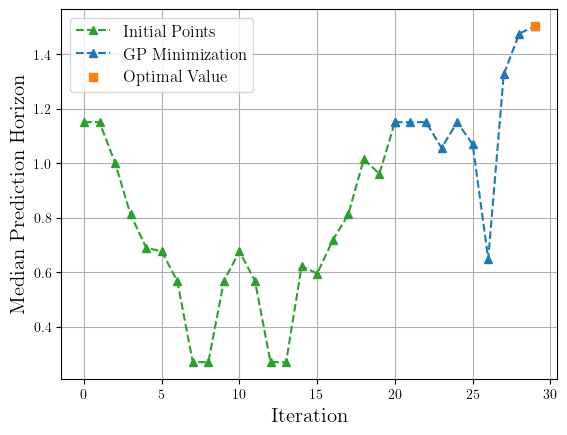

In [48]:
a = n_initial_points + len(x0)
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(func_iters.shape[0])

if a > 0:
    plt.plot(
        -func_iters[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, func_iters.shape[0])
plt.plot(
    xplot,
    -func_iters[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
plt.plot([optim_idx], [-func_iters[optim_idx]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Median Prediction Horizon', fontsize=15)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_rnn_plots+'/median_PH.pdf', bbox_inches='tight', dpi=300)
plt.show()

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

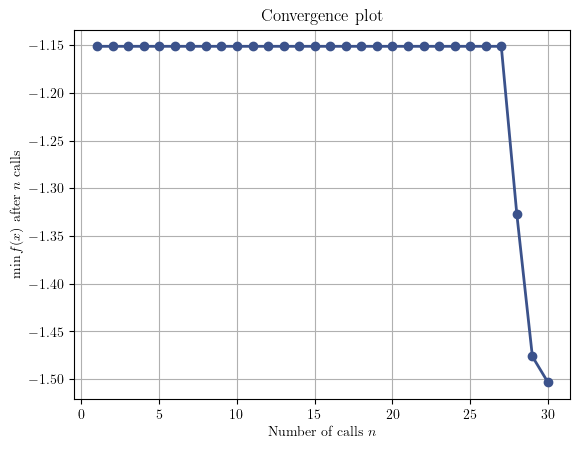

In [49]:
from skopt.plots import plot_convergence
plot_convergence(res)

In [50]:
optimized_vals_dict = {
    'x_iters':x_iters,
    'func_iters':func_iters,
    'optim_x':optim_x,
    'optim_idx':optim_idx,
    'optim_fun':func_iters[optim_idx]
}

with open(dir_name_rnn+'/optimized_vals.txt', 'w') as f:
    f.write(str(optimized_vals_dict))
    
np.savez(
    dir_name_rnn+'/optimized_vals',
    x_iters=x_iters,
    func_iters=func_iters,
    optim_x=optim_x,
    optim_idx=optim_idx,
    optim_fun=func_iters[optim_idx]
)

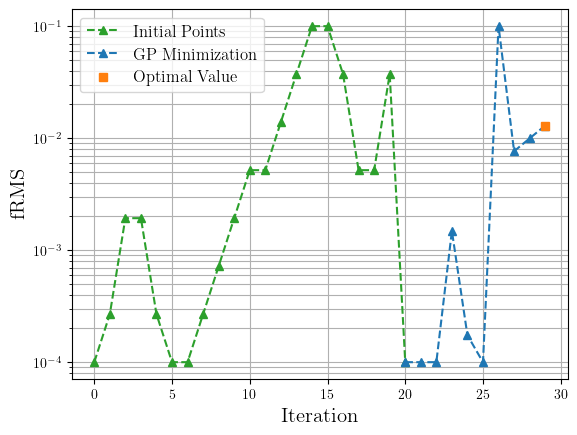

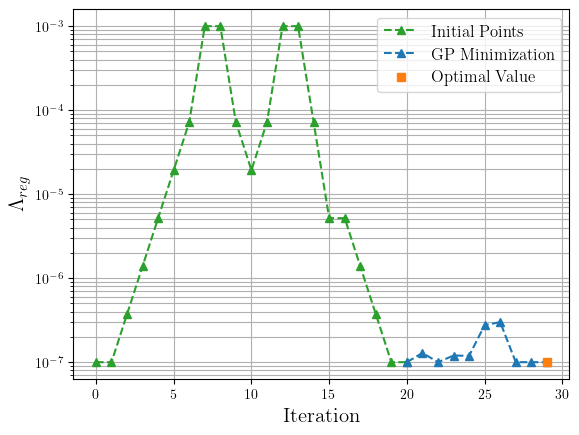

In [51]:
xoptim_names = [
    [r'fRMS', 'fRMS', plt.semilogy],
    [r'$\Lambda_{reg}$', 'lambda_reg', plt.semilogy],
]
if vary_zoneout == True:
    xoptim_names.append(
        [r'$p^{zoneout}$', 'zoneout', plt.plot]
    )

for i in range(len(xoptim_names)):
    a = n_initial_points + len(x0)
    # sorted_idx = np.argsort(x_iters[a:, 0])

    xplot = np.arange(x_iters.shape[0])
    if a > 0:
        xoptim_names[i][2](
            x_iters[:, i][0:a+1],
            linestyle='--',
            color='C2',
            marker='^',
            label='Initial Points',
        )
        xplot = np.arange(a, x_iters.shape[0])
    xoptim_names[i][2](
        xplot,
        x_iters[:, i][a:],
        linestyle='--',
        marker='^',
        label='GP Minimization',#'__nolegend__',
    )
    xoptim_names[i][2]([optim_idx], [x_iters[optim_idx, i]], 's', label='Optimal Value')

    plt.xlabel('Iteration', fontsize=15)
    plt.ylabel(xoptim_names[i][0], fontsize=15)
    plt.grid(True, which='major', axis='x')
    plt.grid(True, which='both', axis='y')
    plt.legend(fontsize=12)

    plt.savefig(dir_name_rnn_plots+'/'+xoptim_names[i][1]+'.pdf', bbox_inches='tight', dpi=300)
    plt.show()

In [52]:
dir_list = os.listdir(dir_name_rnn+'/tested_rnn')
# dir_list

In [53]:
ph_mean_lst = []
for dir_name in dir_list:
    with np.load(dir_name_rnn+'/tested_rnn/'+dir_name+'/prediction_horizons-testingdata--combinedAERNN--ZEROoutsteps.npz') as f:
        ph_mean = np.mean(f['prediction_horizon_arr'])
        ph_mean_lst.append(ph_mean)
ph_mean_lst = np.array(ph_mean_lst)

In [54]:
idx = np.where(ph_mean_lst == ph_mean_lst.max())[0]

In [55]:
idx, dir_list[idx[0]]

(array([9]), 'test_rnn_029')

In [56]:
# convergence plot
convergence_f = np.empty_like(func_iters)
min_val = np.inf
for i in range(func_iters.shape[0]):
    if func_iters[i] < min_val:
        min_val = func_iters[i]
    convergence_f[i] = min_val

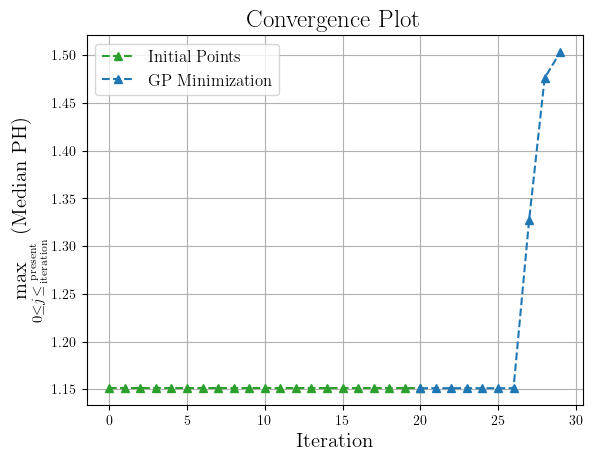

In [57]:
a = n_initial_points + len(x0)
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(x_iters.shape[0])

if a > 0:
    plt.plot(
        -convergence_f[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, x_iters.shape[0])
plt.plot(
    xplot,
    -convergence_f[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
# plt.semilogy([optim_idx], [func_iters[optim_idx, 0]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel(
#     r"$$\min_{0 \leq j \leq \mathrm{present \ iteration}} \left( \mathrm{Test \ MSE} \right)$$",
#     r"$$\min_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Test \ MSE} \right)$$",
    r"$$\max_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Median \ PH} \right)$$",
    fontsize=15,
)
plt.title('Convergence Plot', fontsize=18)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_rnn_plots+'/convergence_plot.pdf', bbox_inches='tight', dpi=300)
plt.show()

### Prediction horizon computation